## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        return {"sample": sample, "label": label}
#print(train_df)
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=1)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', None)
train_df.head(5)

host_is_superhost  latitude  longitude  property_type  room_type  \
0                  0 -0.396491   0.215068      -0.444532  -0.686927   
1                  0 -0.841516   0.095963       1.182045  -0.686927   
2                  0 -0.725178  -0.909397      -0.444532   1.329375   
3                  0 -0.048882   0.086232      -0.444532  -0.686927   
4                  0 -0.635052   0.094278      -0.444532  -0.686927   

   accommodates  bathrooms  bedrooms      beds     price  instant_bookable  \
0     -0.597957  -0.436242 -0.353343 -0.650700  0.438466                 0   
1     -0.597957  -0.436242 -0.353343 -0.650700  2.623250                 0   
2     -0.597957  -0.436242 -0.353343 -0.650700 -1.027833                 1   
3     -0.597957  -0.436242 -1.660357 -0.650700  1.171615                 0   
4     -0.030463  -0.436242  0.953672  0.389812  1.010322                 0   

   cancellation_policy  amenities_Kitchen  amenities_Heating  \
0             1.160642                  1                  1   
1            -1.125796                  1                  1   
2            -1.125796                  1                  1   
3            -0.422277                  1                  1   
4             1.160642                  1                  1   

   amenities_Washer  amenities_Wifi  amenities_Indoor fireplace  \
0                 1               1                           0   
1                 1               1                           0   
2                 1               1                           0   
3                 1               1                           0   
4                 1               1                           0   

   amenities_Iron  amenities_Laptop friendly workspace  amenities_Crib  \
0               1                                    1               0   
1               1                                    1               0   
2               0                                    0               0   
3               0                                    0               0   
4               1                                    1               0   

   amenities_Self check-in  amenities_Carbon monoxide detector  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   1   

   amenities_Shampoo  amenities_Air conditioning  amenities_Dryer  \
0                  1                           1                1   
1                  1                           1                1   
2                  1                           1                1   
3                  0                           1                1   
4                  0                           1                1   

   amenities_Breakfast  amenities_Hangers  amenities_Hair dryer  amenities_TV  \
0                    1                  0                     1             1   
1                    0                  1                     1             1   
2                    0                  0                     0             1   
3                    0                  1                     0             1   
4                    0                  1                     1             1   

   amenities_High chair  amenities_Smoke detector  amenities_Private bathroom  \
0                     0                         1                           0   
1                     0                         1                           0   
2                     0                         1                           0   
3                     0                         1                           0   
4                     0                         1                           0   

   amenities_count  facilities_Free parking on premises  facilities_Gym  \
0         0.2

#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

mean        std
price                120.097102  68.198942
latitude              43.677492   0.046110
longitude            -79.398326   0.059359
property_type          2.819879   1.844364
room_type              0.340686   0.495957
accommodates           3.053679   1.762132
bathrooms              1.200374   0.459320
bedrooms               1.270343   0.765102
beds                   1.625366   0.961066
cancellation_policy    7.400940   5.685699
amenities_count       12.185917   2.775618
facilities_count       1.065138   1.181071
house_rules_count      0.184610   0.449641

## Define Model

In [6]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*3)
        self.layer2 = nn.Linear(41*3, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*2)
        self.layer5 = nn.Linear(41*2, 41*1)
        self.layer6 = nn.Linear(41*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer5(x))
        return self.layer6(x)

## Training Function

In [7]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        #print("hello")
        for i, data in enumerate(train_loader):
            #print(i)
            #print((data))
            sample = data["sample"].float()
            label = data["label"].float().view(-1)
            output = net(sample).view(-1)
            #print(output.shape)
            #print(label.shape)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 0.768331  time: 0.536
---[ITER 20] loss: 0.764079  time: 0.175
---[ITER 30] loss: 0.751549  time: 0.247
---[ITER 40] loss: 0.746862  time: 0.247
---[ITER 50] loss: 0.755347  time: 0.241
---[ITER 60] loss: 0.736753  time: 0.245
---[ITER 70] loss: 0.736651  time: 0.272
---[ITER 80] loss: 0.709362  time: 0.188
---[ITER 90] loss: 0.700520  time: 0.188
---[ITER 100] loss: 0.679628  time: 0.231
---[ITER 110] loss: 0.655055  time: 0.248
---[ITER 120] loss: 0.636487  time: 0.241
---[ITER 130] loss: 0.626532  time: 0.300
---[ITER 140] loss: 0.606470  time: 0.247
---[ITER 150] loss: 0.589004  time: 0.284
---[ITER 160] loss: 0.586332  time: 0.188
[EPOCH 1] loss: 0.684874  time: 4.268
---[ITER 10] loss: 0.561523  time: 0.490
---[ITER 20] loss: 0.559558  time: 0.210
---[ITER 30] loss: 0.540861  time: 0.297
---[ITER 40] loss: 0.543343  time: 0.195
---[ITER 50] loss: 0.533870  time: 0.286
---[ITER 60] loss: 0.528686  time: 0.231
---[ITER 70] loss: 0.541838  tim

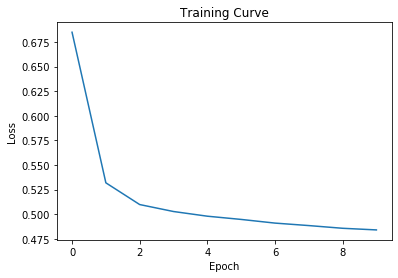

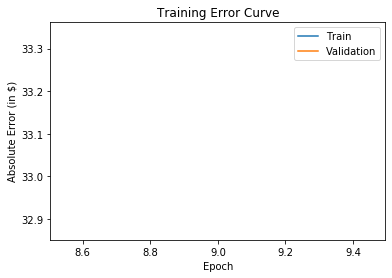

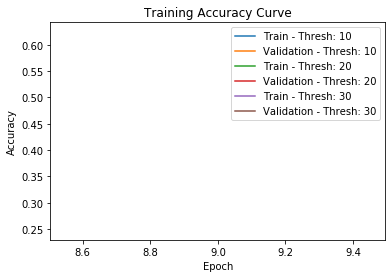

---[ITER 10] loss: 0.477354  time: 0.323
---[ITER 20] loss: 0.486943  time: 0.287
---[ITER 30] loss: 0.472686  time: 0.281
---[ITER 40] loss: 0.472855  time: 0.200
---[ITER 50] loss: 0.486570  time: 0.219
---[ITER 60] loss: 0.482537  time: 0.245
---[ITER 70] loss: 0.478620  time: 0.194
---[ITER 80] loss: 0.480160  time: 0.199
---[ITER 90] loss: 0.491688  time: 0.203
---[ITER 100] loss: 0.482356  time: 0.192
---[ITER 110] loss: 0.490224  time: 0.204
---[ITER 120] loss: 0.480317  time: 0.200
---[ITER 130] loss: 0.475508  time: 0.193
---[ITER 140] loss: 0.487307  time: 0.244
---[ITER 150] loss: 0.478230  time: 0.174
---[ITER 160] loss: 0.484239  time: 0.176
[EPOCH 11] loss: 0.481708  time: 3.657
---[ITER 10] loss: 0.472572  time: 0.262
---[ITER 20] loss: 0.473837  time: 0.221
---[ITER 30] loss: 0.479885  time: 0.344
---[ITER 40] loss: 0.480458  time: 0.218
---[ITER 50] loss: 0.485346  time: 0.199
---[ITER 60] loss: 0.479495  time: 0.240
---[ITER 70] loss: 0.477189  time: 0.212
---[ITER 80

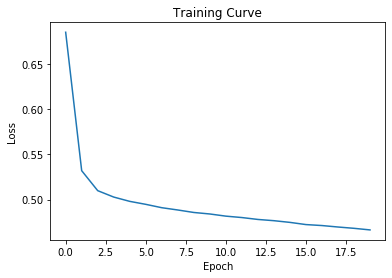

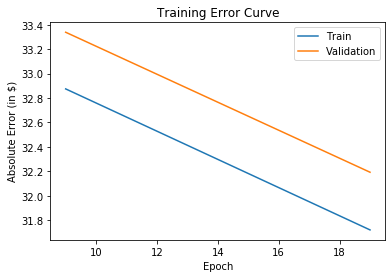

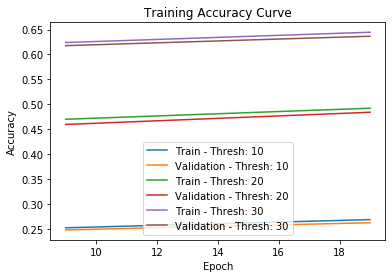

---[ITER 10] loss: 0.464874  time: 0.271
---[ITER 20] loss: 0.470508  time: 0.281
---[ITER 30] loss: 0.465699  time: 0.187
---[ITER 40] loss: 0.471300  time: 0.208
---[ITER 50] loss: 0.464389  time: 0.179
---[ITER 60] loss: 0.453303  time: 0.175
---[ITER 70] loss: 0.469737  time: 0.181
---[ITER 80] loss: 0.455512  time: 0.198
---[ITER 90] loss: 0.466289  time: 0.200
---[ITER 100] loss: 0.466268  time: 0.185
---[ITER 110] loss: 0.465990  time: 0.234
---[ITER 120] loss: 0.473634  time: 0.277
---[ITER 130] loss: 0.471348  time: 0.250
---[ITER 140] loss: 0.466461  time: 0.259
---[ITER 150] loss: 0.465729  time: 0.191
---[ITER 160] loss: 0.461145  time: 0.173
[EPOCH 21] loss: 0.465299  time: 3.652
---[ITER 10] loss: 0.460178  time: 0.281
---[ITER 20] loss: 0.462413  time: 0.307
---[ITER 30] loss: 0.464632  time: 0.272
---[ITER 40] loss: 0.457920  time: 0.219
---[ITER 50] loss: 0.464723  time: 0.249
---[ITER 60] loss: 0.460219  time: 0.246
---[ITER 70] loss: 0.465449  time: 0.205
---[ITER 80

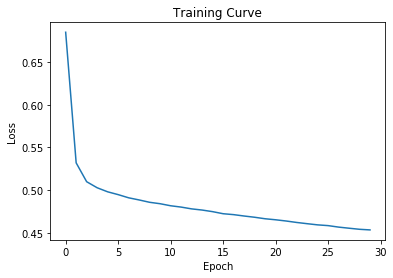

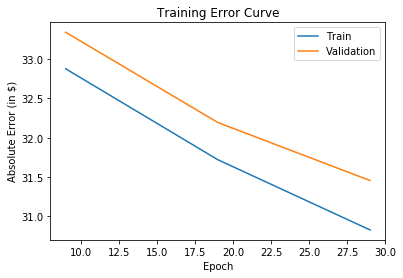

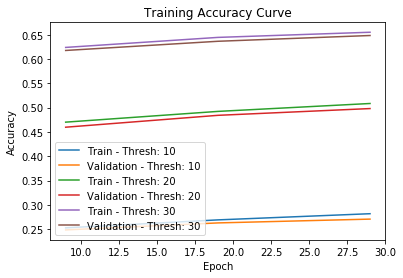

---[ITER 10] loss: 0.455397  time: 0.356
---[ITER 20] loss: 0.448991  time: 0.211
---[ITER 30] loss: 0.451979  time: 0.159
---[ITER 40] loss: 0.452842  time: 0.194
---[ITER 50] loss: 0.451671  time: 0.129
---[ITER 60] loss: 0.450385  time: 0.184
---[ITER 70] loss: 0.450632  time: 0.168
---[ITER 80] loss: 0.460048  time: 0.174
---[ITER 90] loss: 0.446532  time: 0.151
---[ITER 100] loss: 0.453188  time: 0.184
---[ITER 110] loss: 0.443240  time: 0.179
---[ITER 120] loss: 0.454344  time: 0.209
---[ITER 130] loss: 0.449773  time: 0.194
---[ITER 140] loss: 0.452570  time: 0.187
---[ITER 150] loss: 0.456317  time: 0.169
---[ITER 160] loss: 0.448526  time: 0.175
[EPOCH 31] loss: 0.451796  time: 3.166
---[ITER 10] loss: 0.446134  time: 0.374
---[ITER 20] loss: 0.453438  time: 0.152
---[ITER 30] loss: 0.456888  time: 0.175
---[ITER 40] loss: 0.449233  time: 0.172
---[ITER 50] loss: 0.450108  time: 0.161
---[ITER 60] loss: 0.448375  time: 0.140
---[ITER 70] loss: 0.451729  time: 0.193
---[ITER 80

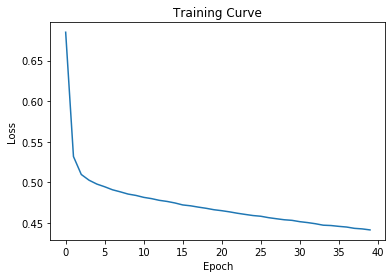

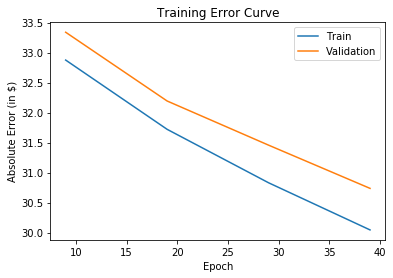

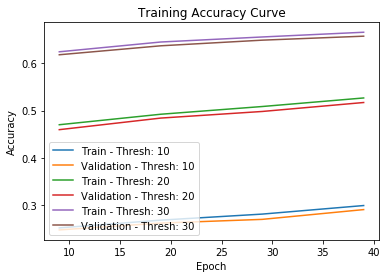

---[ITER 10] loss: 0.441803  time: 0.275
---[ITER 20] loss: 0.448277  time: 0.299
---[ITER 30] loss: 0.438595  time: 0.222
---[ITER 40] loss: 0.440231  time: 0.296
---[ITER 50] loss: 0.445304  time: 0.252
---[ITER 60] loss: 0.440036  time: 0.273
---[ITER 70] loss: 0.446929  time: 0.199
---[ITER 80] loss: 0.439314  time: 0.209
---[ITER 90] loss: 0.440296  time: 0.215
---[ITER 100] loss: 0.434570  time: 0.194
---[ITER 110] loss: 0.438036  time: 0.463
---[ITER 120] loss: 0.437531  time: 0.420
---[ITER 130] loss: 0.432752  time: 0.315
---[ITER 140] loss: 0.435531  time: 0.313
---[ITER 150] loss: 0.446631  time: 0.242
---[ITER 160] loss: 0.442238  time: 0.287
[EPOCH 41] loss: 0.440645  time: 4.744
---[ITER 10] loss: 0.440160  time: 0.377
---[ITER 20] loss: 0.434614  time: 0.211
---[ITER 30] loss: 0.440649  time: 0.198
---[ITER 40] loss: 0.445794  time: 0.310
---[ITER 50] loss: 0.443553  time: 0.244
---[ITER 60] loss: 0.438935  time: 0.220
---[ITER 70] loss: 0.441445  time: 0.168
---[ITER 80

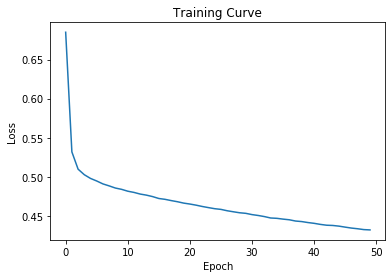

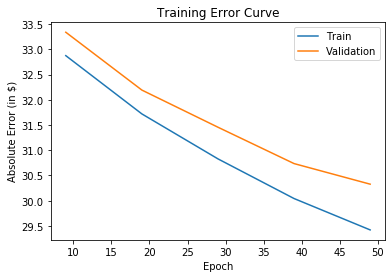

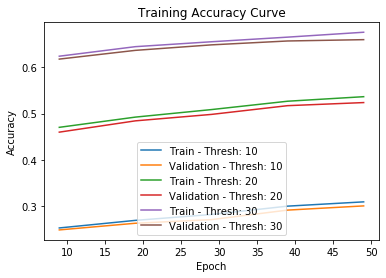

---[ITER 10] loss: 0.435828  time: 0.305
---[ITER 20] loss: 0.428981  time: 0.227
---[ITER 30] loss: 0.431986  time: 0.581
---[ITER 40] loss: 0.440792  time: 0.300
---[ITER 50] loss: 0.435488  time: 0.321
---[ITER 60] loss: 0.431083  time: 0.194
---[ITER 70] loss: 0.428508  time: 0.223
---[ITER 80] loss: 0.432829  time: 0.211
---[ITER 90] loss: 0.428080  time: 0.299
---[ITER 100] loss: 0.423293  time: 0.252
---[ITER 110] loss: 0.427253  time: 0.270
---[ITER 120] loss: 0.422677  time: 0.344
---[ITER 130] loss: 0.436486  time: 0.305
---[ITER 140] loss: 0.433872  time: 0.330
---[ITER 150] loss: 0.435186  time: 0.345
---[ITER 160] loss: 0.429174  time: 0.407
[EPOCH 51] loss: 0.430952  time: 5.729
---[ITER 10] loss: 0.424932  time: 0.893
---[ITER 20] loss: 0.423424  time: 0.993
---[ITER 30] loss: 0.435082  time: 0.497
---[ITER 40] loss: 0.436180  time: 0.248
---[ITER 50] loss: 0.434584  time: 0.263
---[ITER 60] loss: 0.441705  time: 0.188
---[ITER 70] loss: 0.423235  time: 0.346
---[ITER 80

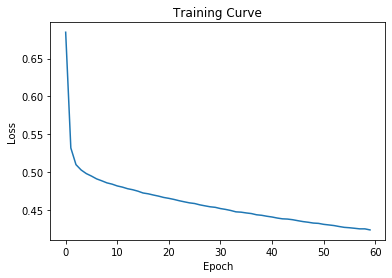

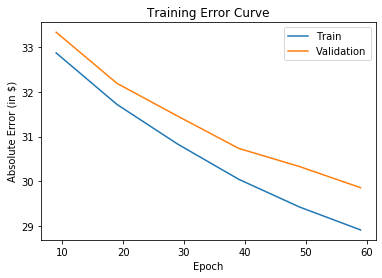

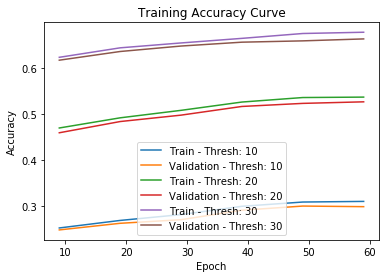

---[ITER 10] loss: 0.425228  time: 0.370
---[ITER 20] loss: 0.420702  time: 0.307
---[ITER 30] loss: 0.415237  time: 0.151
---[ITER 40] loss: 0.430167  time: 0.245
---[ITER 50] loss: 0.423454  time: 0.243
---[ITER 60] loss: 0.418003  time: 0.186
---[ITER 70] loss: 0.418886  time: 0.196
---[ITER 80] loss: 0.419450  time: 0.233
---[ITER 90] loss: 0.433766  time: 0.181
---[ITER 100] loss: 0.427774  time: 0.157
---[ITER 110] loss: 0.426054  time: 0.172
---[ITER 120] loss: 0.422852  time: 0.211
---[ITER 130] loss: 0.421946  time: 0.198
---[ITER 140] loss: 0.420428  time: 0.194
---[ITER 150] loss: 0.425109  time: 0.155
---[ITER 160] loss: 0.422742  time: 0.234
[EPOCH 61] loss: 0.423016  time: 3.671
---[ITER 10] loss: 0.420358  time: 0.355
---[ITER 20] loss: 0.416207  time: 0.409
---[ITER 30] loss: 0.428303  time: 0.248
---[ITER 40] loss: 0.424646  time: 0.179
---[ITER 50] loss: 0.415815  time: 0.190
---[ITER 60] loss: 0.427452  time: 0.217
---[ITER 70] loss: 0.418996  time: 0.281
---[ITER 80

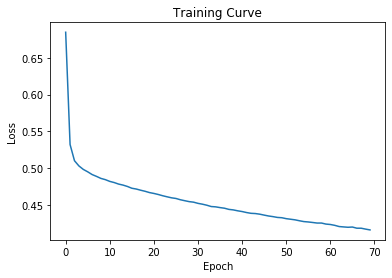

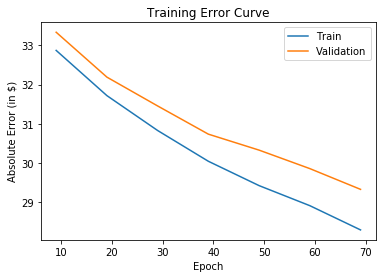

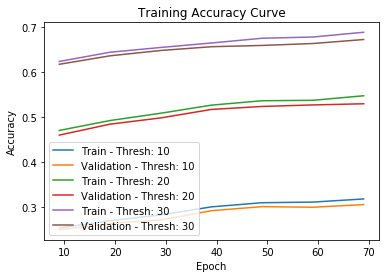

---[ITER 10] loss: 0.414385  time: 0.400
---[ITER 20] loss: 0.422285  time: 0.252
---[ITER 30] loss: 0.420299  time: 0.303
---[ITER 40] loss: 0.417023  time: 0.241
---[ITER 50] loss: 0.409111  time: 0.247
---[ITER 60] loss: 0.416510  time: 0.224
---[ITER 70] loss: 0.414434  time: 0.196
---[ITER 80] loss: 0.419296  time: 0.184
---[ITER 90] loss: 0.413080  time: 0.223
---[ITER 100] loss: 0.423366  time: 0.183
---[ITER 110] loss: 0.413424  time: 0.189
---[ITER 120] loss: 0.407981  time: 0.377
---[ITER 130] loss: 0.412502  time: 0.348
---[ITER 140] loss: 0.408418  time: 0.300
---[ITER 150] loss: 0.410529  time: 0.193
---[ITER 160] loss: 0.418302  time: 0.184
[EPOCH 71] loss: 0.415068  time: 4.208
---[ITER 10] loss: 0.413420  time: 0.408
---[ITER 20] loss: 0.415585  time: 0.191
---[ITER 30] loss: 0.412159  time: 0.189
---[ITER 40] loss: 0.419344  time: 0.172
---[ITER 50] loss: 0.411610  time: 0.165
---[ITER 60] loss: 0.413323  time: 0.161
---[ITER 70] loss: 0.419040  time: 0.170
---[ITER 80

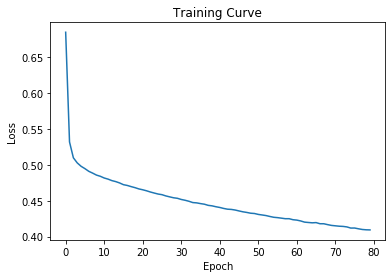

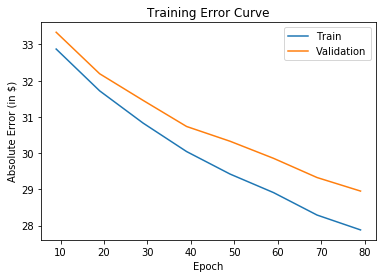

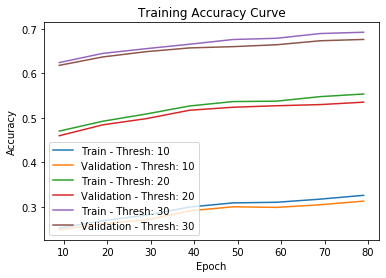

---[ITER 10] loss: 0.408956  time: 0.483
---[ITER 20] loss: 0.403073  time: 0.289
---[ITER 30] loss: 0.409359  time: 0.489
---[ITER 40] loss: 0.401300  time: 0.419
---[ITER 50] loss: 0.414028  time: 0.397
---[ITER 60] loss: 0.407519  time: 0.318
---[ITER 70] loss: 0.408890  time: 0.217
---[ITER 80] loss: 0.410416  time: 0.236
---[ITER 90] loss: 0.414803  time: 0.183
---[ITER 100] loss: 0.400124  time: 0.261
---[ITER 110] loss: 0.414179  time: 0.221
---[ITER 120] loss: 0.403790  time: 0.241
---[ITER 130] loss: 0.410697  time: 0.238
---[ITER 140] loss: 0.408304  time: 0.268
---[ITER 150] loss: 0.408169  time: 0.260
---[ITER 160] loss: 0.410101  time: 0.240
[EPOCH 81] loss: 0.408651  time: 4.936
---[ITER 10] loss: 0.408706  time: 0.419
---[ITER 20] loss: 0.405505  time: 0.263
---[ITER 30] loss: 0.408319  time: 0.337
---[ITER 40] loss: 0.407108  time: 0.262
---[ITER 50] loss: 0.402751  time: 0.261
---[ITER 60] loss: 0.412542  time: 0.272
---[ITER 70] loss: 0.412258  time: 0.214
---[ITER 80

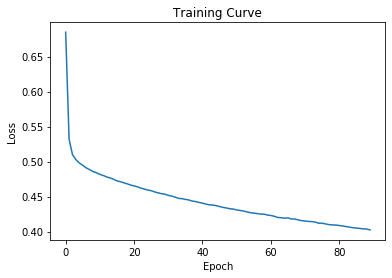

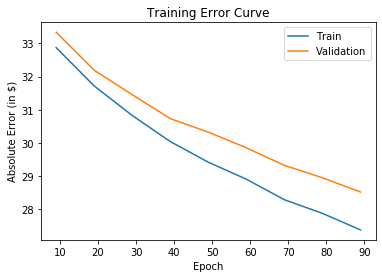

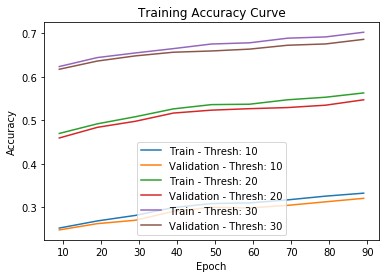

---[ITER 10] loss: 0.405628  time: 0.235
---[ITER 20] loss: 0.407248  time: 0.255
---[ITER 30] loss: 0.401349  time: 0.158
---[ITER 40] loss: 0.394688  time: 0.183
---[ITER 50] loss: 0.400502  time: 0.150
---[ITER 60] loss: 0.399488  time: 0.173
---[ITER 70] loss: 0.402421  time: 0.133
---[ITER 80] loss: 0.407340  time: 0.169
---[ITER 90] loss: 0.408506  time: 0.164
---[ITER 100] loss: 0.400889  time: 0.153
---[ITER 110] loss: 0.402712  time: 0.156
---[ITER 120] loss: 0.391922  time: 0.180
---[ITER 130] loss: 0.399226  time: 0.152
---[ITER 140] loss: 0.408155  time: 0.198
---[ITER 150] loss: 0.402674  time: 0.145
---[ITER 160] loss: 0.396206  time: 0.228
[EPOCH 91] loss: 0.402133  time: 2.987
---[ITER 10] loss: 0.401623  time: 0.225
---[ITER 20] loss: 0.397339  time: 0.255
---[ITER 30] loss: 0.400360  time: 0.182
---[ITER 40] loss: 0.395612  time: 0.138
---[ITER 50] loss: 0.396349  time: 0.174
---[ITER 60] loss: 0.405647  time: 0.177
---[ITER 70] loss: 0.405889  time: 0.151
---[ITER 80

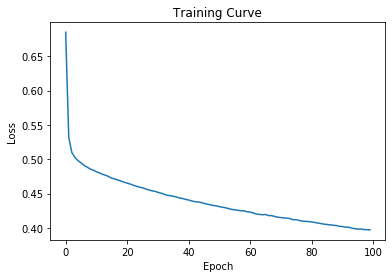

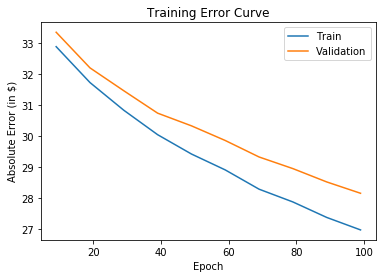

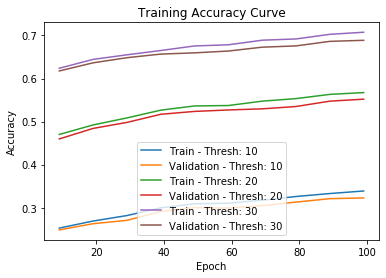

---[ITER 10] loss: 0.386691  time: 0.341
---[ITER 20] loss: 0.391851  time: 0.184
---[ITER 30] loss: 0.394052  time: 0.170
---[ITER 40] loss: 0.393810  time: 0.161
---[ITER 50] loss: 0.396389  time: 0.143
---[ITER 60] loss: 0.393004  time: 0.158
---[ITER 70] loss: 0.397636  time: 0.188
---[ITER 80] loss: 0.401151  time: 0.200
---[ITER 90] loss: 0.391158  time: 0.142
---[ITER 100] loss: 0.404459  time: 0.168
---[ITER 110] loss: 0.399936  time: 0.153
---[ITER 120] loss: 0.403690  time: 0.175
---[ITER 130] loss: 0.396503  time: 0.191
---[ITER 140] loss: 0.394956  time: 0.154
---[ITER 150] loss: 0.391769  time: 0.174
---[ITER 160] loss: 0.397282  time: 0.174
[EPOCH 101] loss: 0.395707  time: 3.003
---[ITER 10] loss: 0.393645  time: 0.344
---[ITER 20] loss: 0.400581  time: 0.182
---[ITER 30] loss: 0.391409  time: 0.171
---[ITER 40] loss: 0.394005  time: 0.152
---[ITER 50] loss: 0.392958  time: 0.149
---[ITER 60] loss: 0.387075  time: 0.178
---[ITER 70] loss: 0.393729  time: 0.154
---[ITER 8

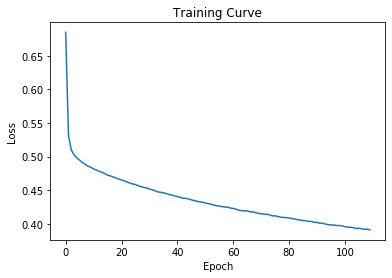

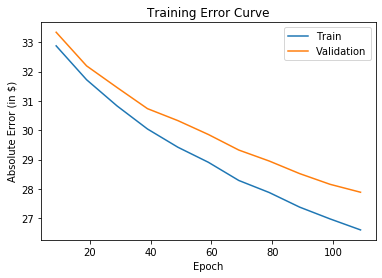

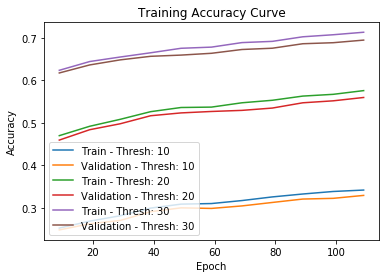

---[ITER 10] loss: 0.394119  time: 0.374
---[ITER 20] loss: 0.386604  time: 0.184
---[ITER 30] loss: 0.389251  time: 0.157
---[ITER 40] loss: 0.395396  time: 0.169
---[ITER 50] loss: 0.393092  time: 0.146
---[ITER 60] loss: 0.393374  time: 0.174
---[ITER 70] loss: 0.396348  time: 0.147
---[ITER 80] loss: 0.392024  time: 0.160
---[ITER 90] loss: 0.386203  time: 0.154
---[ITER 100] loss: 0.394324  time: 0.171
---[ITER 110] loss: 0.384092  time: 0.159
---[ITER 120] loss: 0.380885  time: 0.208
---[ITER 130] loss: 0.393202  time: 0.157
---[ITER 140] loss: 0.390026  time: 0.185
---[ITER 150] loss: 0.388292  time: 0.147
---[ITER 160] loss: 0.385957  time: 0.185
[EPOCH 111] loss: 0.390401  time: 3.019
---[ITER 10] loss: 0.384259  time: 0.367
---[ITER 20] loss: 0.382109  time: 0.185
---[ITER 30] loss: 0.387436  time: 0.157
---[ITER 40] loss: 0.388411  time: 0.178
---[ITER 50] loss: 0.389681  time: 0.164
---[ITER 60] loss: 0.384782  time: 0.161
---[ITER 70] loss: 0.394141  time: 0.153
---[ITER 8

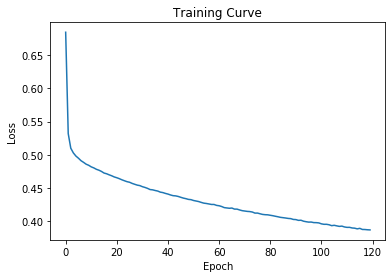

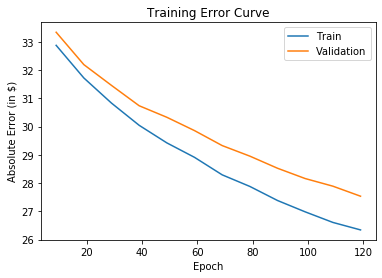

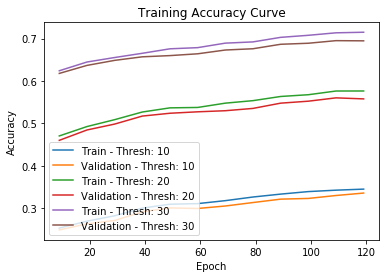

---[ITER 10] loss: 0.381532  time: 0.238
---[ITER 20] loss: 0.390501  time: 0.150
---[ITER 30] loss: 0.382807  time: 0.265
---[ITER 40] loss: 0.390708  time: 0.175
---[ITER 50] loss: 0.385819  time: 0.161
---[ITER 60] loss: 0.381820  time: 0.144
---[ITER 70] loss: 0.382960  time: 0.181
---[ITER 80] loss: 0.386046  time: 0.193
---[ITER 90] loss: 0.389072  time: 0.162
---[ITER 100] loss: 0.383552  time: 0.194
---[ITER 110] loss: 0.388354  time: 0.165
---[ITER 120] loss: 0.384584  time: 0.153
---[ITER 130] loss: 0.389159  time: 0.151
---[ITER 140] loss: 0.383095  time: 0.230
---[ITER 150] loss: 0.385472  time: 0.161
---[ITER 160] loss: 0.394994  time: 0.175
[EPOCH 121] loss: 0.386963  time: 3.027
---[ITER 10] loss: 0.389589  time: 0.233
---[ITER 20] loss: 0.383443  time: 0.159
---[ITER 30] loss: 0.389175  time: 0.278
---[ITER 40] loss: 0.383780  time: 0.170
---[ITER 50] loss: 0.387484  time: 0.195
---[ITER 60] loss: 0.386378  time: 0.140
---[ITER 70] loss: 0.384258  time: 0.148
---[ITER 8

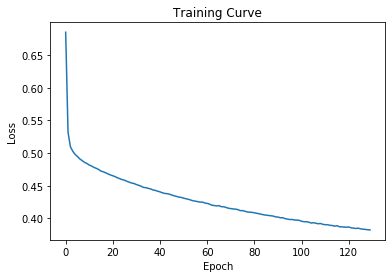

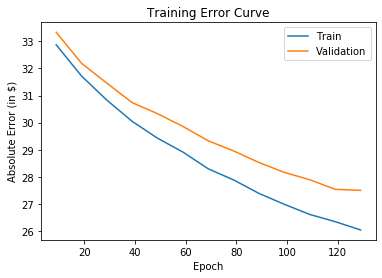

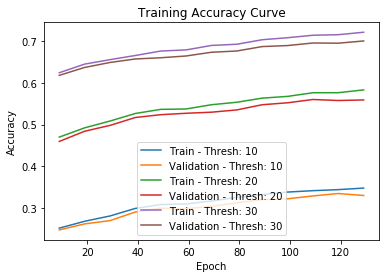

---[ITER 10] loss: 0.383177  time: 0.240
---[ITER 20] loss: 0.373819  time: 0.269
---[ITER 30] loss: 0.383695  time: 0.159
---[ITER 40] loss: 0.378561  time: 0.175
---[ITER 50] loss: 0.376376  time: 0.142
---[ITER 60] loss: 0.376623  time: 0.177
---[ITER 70] loss: 0.393771  time: 0.159
---[ITER 80] loss: 0.376464  time: 0.148
---[ITER 90] loss: 0.376925  time: 0.150
---[ITER 100] loss: 0.387522  time: 0.190
---[ITER 110] loss: 0.386744  time: 0.187
---[ITER 120] loss: 0.381845  time: 0.165
---[ITER 130] loss: 0.381255  time: 0.191
---[ITER 140] loss: 0.390902  time: 0.170
---[ITER 150] loss: 0.383285  time: 0.157
---[ITER 160] loss: 0.380776  time: 0.270
[EPOCH 131] loss: 0.381760  time: 3.082
---[ITER 10] loss: 0.380316  time: 0.236
---[ITER 20] loss: 0.382150  time: 0.317
---[ITER 30] loss: 0.383389  time: 0.170
---[ITER 40] loss: 0.380552  time: 0.160
---[ITER 50] loss: 0.383417  time: 0.148
---[ITER 60] loss: 0.382064  time: 0.179
---[ITER 70] loss: 0.381726  time: 0.175
---[ITER 8

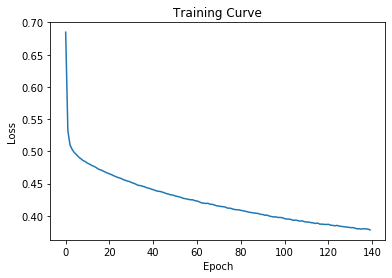

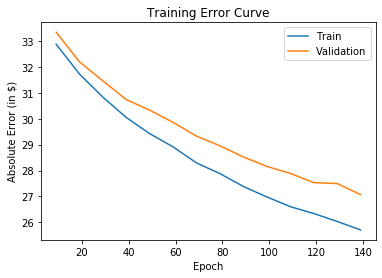

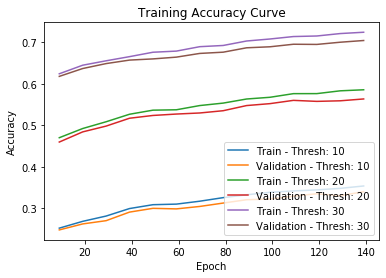

---[ITER 10] loss: 0.379739  time: 0.378
---[ITER 20] loss: 0.381246  time: 0.164
---[ITER 30] loss: 0.379505  time: 0.165
---[ITER 40] loss: 0.385721  time: 0.167
---[ITER 50] loss: 0.379280  time: 0.155
---[ITER 60] loss: 0.376711  time: 0.196
---[ITER 70] loss: 0.377031  time: 0.165
---[ITER 80] loss: 0.372514  time: 0.154
---[ITER 90] loss: 0.378034  time: 0.159
---[ITER 100] loss: 0.373811  time: 0.175
---[ITER 110] loss: 0.379264  time: 0.150
---[ITER 120] loss: 0.376125  time: 0.169
---[ITER 130] loss: 0.374566  time: 0.248
---[ITER 140] loss: 0.388301  time: 0.152
---[ITER 150] loss: 0.383360  time: 0.153
---[ITER 160] loss: 0.372214  time: 0.161
[EPOCH 141] loss: 0.378263  time: 3.044
---[ITER 10] loss: 0.377324  time: 0.377
---[ITER 20] loss: 0.376407  time: 0.147
---[ITER 30] loss: 0.369646  time: 0.157
---[ITER 40] loss: 0.376551  time: 0.224
---[ITER 50] loss: 0.379305  time: 0.136
---[ITER 60] loss: 0.374918  time: 0.184
---[ITER 70] loss: 0.380003  time: 0.160
---[ITER 8

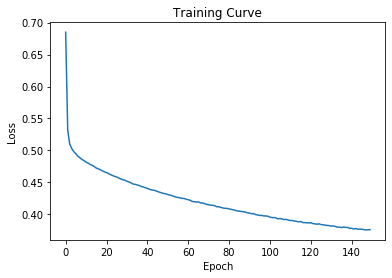

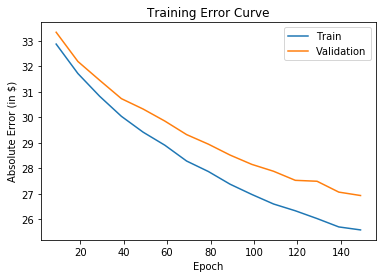

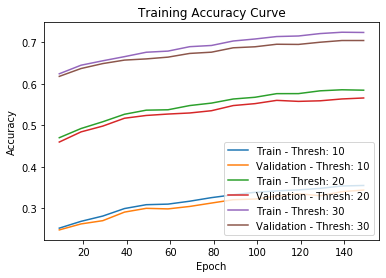

---[ITER 10] loss: 0.378249  time: 0.241
---[ITER 20] loss: 0.380222  time: 0.185
---[ITER 30] loss: 0.374749  time: 0.161
---[ITER 40] loss: 0.377775  time: 0.244
---[ITER 50] loss: 0.366764  time: 0.151
---[ITER 60] loss: 0.371153  time: 0.188
---[ITER 70] loss: 0.374051  time: 0.184
---[ITER 80] loss: 0.378901  time: 0.179
---[ITER 90] loss: 0.378178  time: 0.151
---[ITER 100] loss: 0.375648  time: 0.155
---[ITER 110] loss: 0.374255  time: 0.166
---[ITER 120] loss: 0.376444  time: 0.152
---[ITER 130] loss: 0.374085  time: 0.152
---[ITER 140] loss: 0.375791  time: 0.162
---[ITER 150] loss: 0.381171  time: 0.200
---[ITER 160] loss: 0.376459  time: 0.172
[EPOCH 151] loss: 0.375601  time: 2.979
---[ITER 10] loss: 0.372392  time: 0.221
---[ITER 20] loss: 0.377994  time: 0.182
---[ITER 30] loss: 0.375871  time: 0.183
---[ITER 40] loss: 0.374269  time: 0.259
---[ITER 50] loss: 0.368297  time: 0.186
---[ITER 60] loss: 0.375883  time: 0.164
---[ITER 70] loss: 0.375638  time: 0.166
---[ITER 8

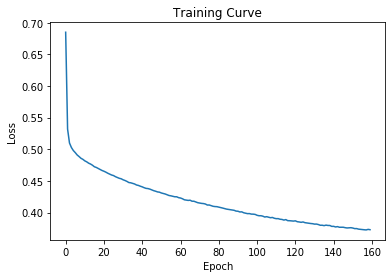

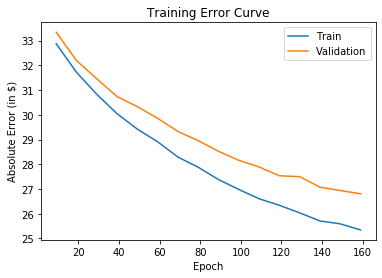

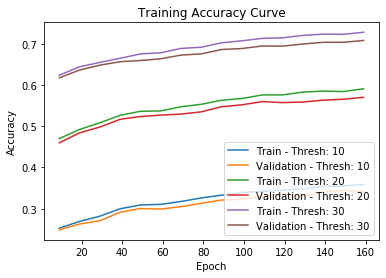

---[ITER 10] loss: 0.367188  time: 0.226
---[ITER 20] loss: 0.375208  time: 0.146
---[ITER 30] loss: 0.377330  time: 0.249
---[ITER 40] loss: 0.371646  time: 0.178
---[ITER 50] loss: 0.375070  time: 0.197
---[ITER 60] loss: 0.378636  time: 0.221
---[ITER 70] loss: 0.371325  time: 0.208
---[ITER 80] loss: 0.378034  time: 0.300
---[ITER 90] loss: 0.369006  time: 0.270
---[ITER 100] loss: 0.368362  time: 0.217
---[ITER 110] loss: 0.370857  time: 0.242
---[ITER 120] loss: 0.374951  time: 0.151
---[ITER 130] loss: 0.371387  time: 0.149
---[ITER 140] loss: 0.367761  time: 0.230
---[ITER 150] loss: 0.376748  time: 0.155
---[ITER 160] loss: 0.371480  time: 0.174
[EPOCH 161] loss: 0.372612  time: 3.440
---[ITER 10] loss: 0.370666  time: 0.500
---[ITER 20] loss: 0.373479  time: 0.279
---[ITER 30] loss: 0.375349  time: 0.285
---[ITER 40] loss: 0.372357  time: 0.239
---[ITER 50] loss: 0.373330  time: 0.227
---[ITER 60] loss: 0.368716  time: 0.259
---[ITER 70] loss: 0.374478  time: 0.221
---[ITER 8

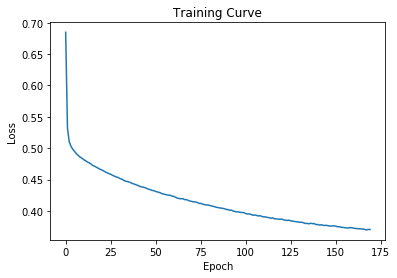

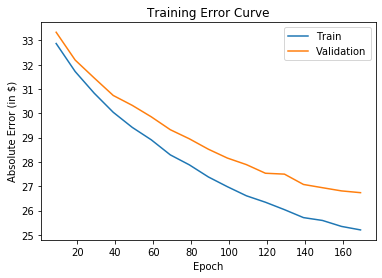

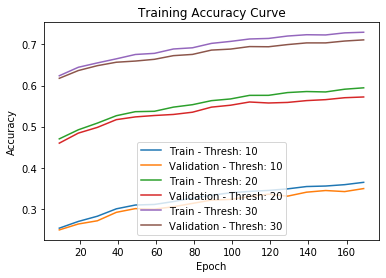

---[ITER 10] loss: 0.375098  time: 0.233
---[ITER 20] loss: 0.367026  time: 0.265
---[ITER 30] loss: 0.381520  time: 0.159
---[ITER 40] loss: 0.368928  time: 0.156
---[ITER 50] loss: 0.370120  time: 0.174
---[ITER 60] loss: 0.372603  time: 0.166
---[ITER 70] loss: 0.365662  time: 0.143
---[ITER 80] loss: 0.364102  time: 0.193
---[ITER 90] loss: 0.374575  time: 0.155
---[ITER 100] loss: 0.368203  time: 0.180
---[ITER 110] loss: 0.364100  time: 0.185
---[ITER 120] loss: 0.369729  time: 0.184
---[ITER 130] loss: 0.369484  time: 0.208
---[ITER 140] loss: 0.370068  time: 0.180
---[ITER 150] loss: 0.373658  time: 0.155
---[ITER 160] loss: 0.372951  time: 0.188
[EPOCH 171] loss: 0.370348  time: 3.085
---[ITER 10] loss: 0.359844  time: 0.243
---[ITER 20] loss: 0.368904  time: 0.262
---[ITER 30] loss: 0.379461  time: 0.150
---[ITER 40] loss: 0.380162  time: 0.189
---[ITER 50] loss: 0.367594  time: 0.176
---[ITER 60] loss: 0.367201  time: 0.194
---[ITER 70] loss: 0.375131  time: 0.170
---[ITER 8

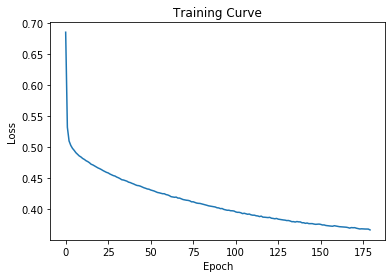

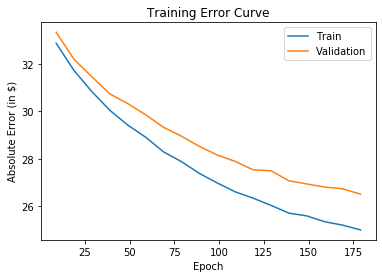

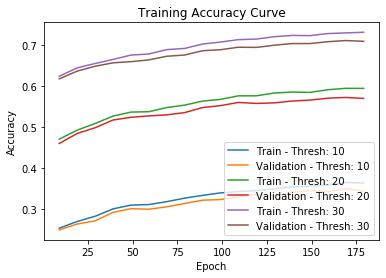

---[ITER 10] loss: 0.366271  time: 0.387
---[ITER 20] loss: 0.366965  time: 0.200
---[ITER 30] loss: 0.366430  time: 0.192
---[ITER 40] loss: 0.369696  time: 0.189
---[ITER 50] loss: 0.368863  time: 0.164
---[ITER 60] loss: 0.363216  time: 0.172
---[ITER 70] loss: 0.367159  time: 0.186
---[ITER 80] loss: 0.367102  time: 0.215
---[ITER 90] loss: 0.363657  time: 0.169
---[ITER 100] loss: 0.370597  time: 0.165
---[ITER 110] loss: 0.376301  time: 0.153
---[ITER 120] loss: 0.371887  time: 0.234
---[ITER 130] loss: 0.369245  time: 0.210
---[ITER 140] loss: 0.362404  time: 0.186
---[ITER 150] loss: 0.362500  time: 0.192
---[ITER 160] loss: 0.365166  time: 0.167
[EPOCH 181] loss: 0.367383  time: 3.332
---[ITER 10] loss: 0.360177  time: 0.367
---[ITER 20] loss: 0.363181  time: 0.176
---[ITER 30] loss: 0.365222  time: 0.161
---[ITER 40] loss: 0.369830  time: 0.212
---[ITER 50] loss: 0.374421  time: 0.179
---[ITER 60] loss: 0.369847  time: 0.201
---[ITER 70] loss: 0.366545  time: 0.200
---[ITER 8

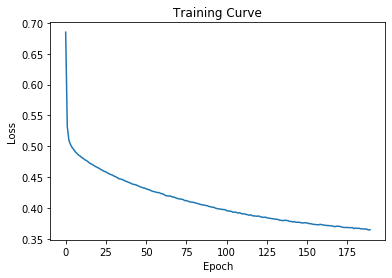

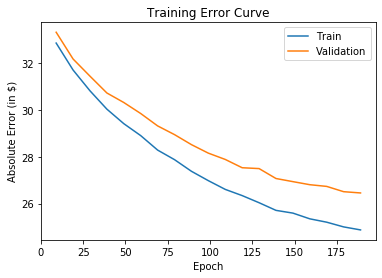

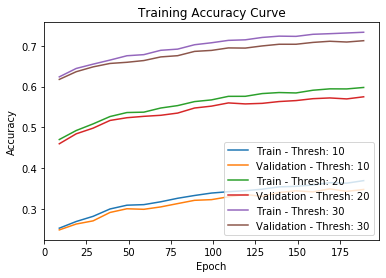

---[ITER 10] loss: 0.362158  time: 0.286
---[ITER 20] loss: 0.361078  time: 0.179
---[ITER 30] loss: 0.364080  time: 0.269
---[ITER 40] loss: 0.364014  time: 0.158
---[ITER 50] loss: 0.365935  time: 0.180
---[ITER 60] loss: 0.364926  time: 0.169
---[ITER 70] loss: 0.364593  time: 0.189
---[ITER 80] loss: 0.371443  time: 0.154
---[ITER 90] loss: 0.357516  time: 0.153
---[ITER 100] loss: 0.363498  time: 0.168
---[ITER 110] loss: 0.363093  time: 0.145
---[ITER 120] loss: 0.367861  time: 0.150
---[ITER 130] loss: 0.367904  time: 0.186
---[ITER 140] loss: 0.374017  time: 0.151
---[ITER 150] loss: 0.363479  time: 0.219
---[ITER 160] loss: 0.367020  time: 0.172
[EPOCH 191] loss: 0.365161  time: 3.125
---[ITER 10] loss: 0.366668  time: 0.283
---[ITER 20] loss: 0.367798  time: 0.209
---[ITER 30] loss: 0.356542  time: 0.274
---[ITER 40] loss: 0.359318  time: 0.185
---[ITER 50] loss: 0.365111  time: 0.213
---[ITER 60] loss: 0.356063  time: 0.185
---[ITER 70] loss: 0.366353  time: 0.191
---[ITER 8

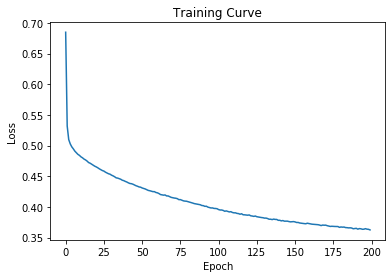

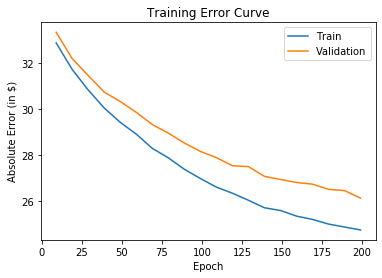

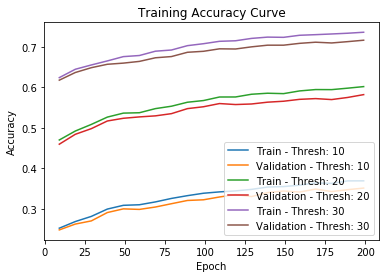

---[ITER 10] loss: 0.362706  time: 0.249
---[ITER 20] loss: 0.367176  time: 0.257
---[ITER 30] loss: 0.362685  time: 0.185
---[ITER 40] loss: 0.361243  time: 0.156
---[ITER 50] loss: 0.367915  time: 0.148
---[ITER 60] loss: 0.359685  time: 0.184
---[ITER 70] loss: 0.354848  time: 0.154
---[ITER 80] loss: 0.361240  time: 0.201
---[ITER 90] loss: 0.367507  time: 0.161
---[ITER 100] loss: 0.362734  time: 0.158
---[ITER 110] loss: 0.367372  time: 0.152
---[ITER 120] loss: 0.362089  time: 0.172
---[ITER 130] loss: 0.349541  time: 0.177
---[ITER 140] loss: 0.367637  time: 0.204
---[ITER 150] loss: 0.374017  time: 0.165
---[ITER 160] loss: 0.362680  time: 0.162
[EPOCH 201] loss: 0.363318  time: 3.016
---[ITER 10] loss: 0.361077  time: 0.229
---[ITER 20] loss: 0.359935  time: 0.265
---[ITER 30] loss: 0.364576  time: 0.182
---[ITER 40] loss: 0.351950  time: 0.163
---[ITER 50] loss: 0.359299  time: 0.197
---[ITER 60] loss: 0.370296  time: 0.202
---[ITER 70] loss: 0.360333  time: 0.206
---[ITER 8

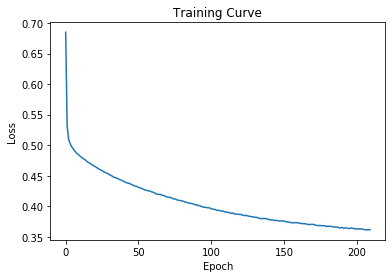

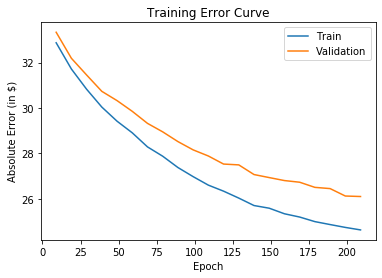

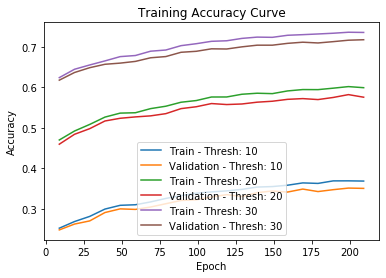

---[ITER 10] loss: 0.357067  time: 0.389
---[ITER 20] loss: 0.361277  time: 0.162
---[ITER 30] loss: 0.363821  time: 0.207
---[ITER 40] loss: 0.359170  time: 0.179
---[ITER 50] loss: 0.358110  time: 0.161
---[ITER 60] loss: 0.357605  time: 0.213
---[ITER 70] loss: 0.357610  time: 0.187
---[ITER 80] loss: 0.365937  time: 0.199
---[ITER 90] loss: 0.363288  time: 0.192
---[ITER 100] loss: 0.362460  time: 0.204
---[ITER 110] loss: 0.366895  time: 0.195
---[ITER 120] loss: 0.358194  time: 0.198
---[ITER 130] loss: 0.356902  time: 0.222
---[ITER 140] loss: 0.359806  time: 0.205
---[ITER 150] loss: 0.358518  time: 0.201
---[ITER 160] loss: 0.364290  time: 0.191
[EPOCH 211] loss: 0.360909  time: 3.464
---[ITER 10] loss: 0.355189  time: 0.390
---[ITER 20] loss: 0.361887  time: 0.188
---[ITER 30] loss: 0.360519  time: 0.198
---[ITER 40] loss: 0.357178  time: 0.170
---[ITER 50] loss: 0.362947  time: 0.198
---[ITER 60] loss: 0.364968  time: 0.209
---[ITER 70] loss: 0.360283  time: 0.188
---[ITER 8

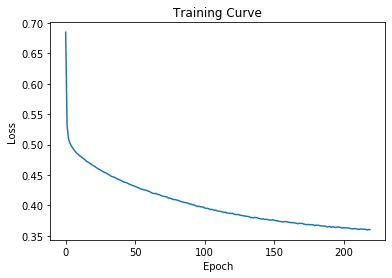

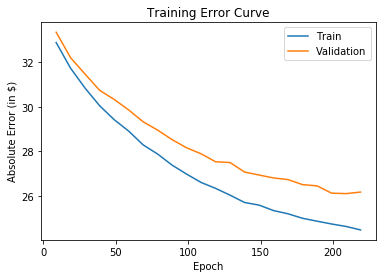

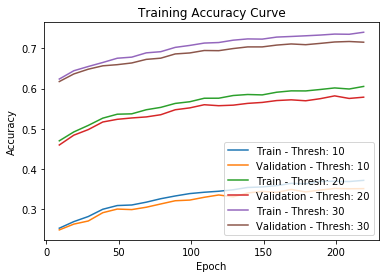

---[ITER 10] loss: 0.358118  time: 0.368
---[ITER 20] loss: 0.358457  time: 0.162
---[ITER 30] loss: 0.360637  time: 0.153
---[ITER 40] loss: 0.357738  time: 0.172
---[ITER 50] loss: 0.359662  time: 0.160
---[ITER 60] loss: 0.362431  time: 0.197
---[ITER 70] loss: 0.355161  time: 0.184
---[ITER 80] loss: 0.363014  time: 0.161
---[ITER 90] loss: 0.363263  time: 0.198
---[ITER 100] loss: 0.361055  time: 0.175
---[ITER 110] loss: 0.362113  time: 0.176
---[ITER 120] loss: 0.360552  time: 0.194
---[ITER 130] loss: 0.358444  time: 0.163
---[ITER 140] loss: 0.364802  time: 0.154
---[ITER 150] loss: 0.359592  time: 0.200
---[ITER 160] loss: 0.360526  time: 0.188
[EPOCH 221] loss: 0.359972  time: 3.174
---[ITER 10] loss: 0.356820  time: 0.393
---[ITER 20] loss: 0.356217  time: 0.195
---[ITER 30] loss: 0.359863  time: 0.184
---[ITER 40] loss: 0.359925  time: 0.160
---[ITER 50] loss: 0.350866  time: 0.177
---[ITER 60] loss: 0.363765  time: 0.156
---[ITER 70] loss: 0.356958  time: 0.175
---[ITER 8

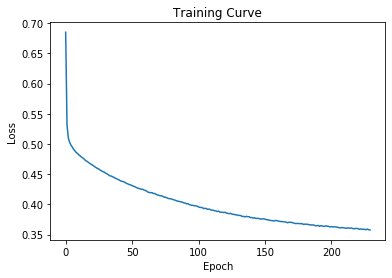

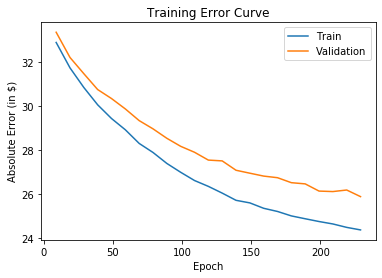

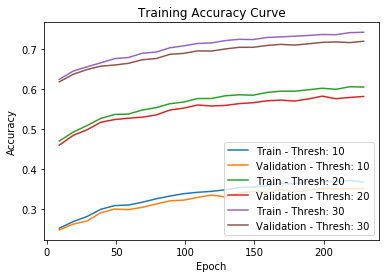

---[ITER 10] loss: 0.361159  time: 0.249
---[ITER 20] loss: 0.358126  time: 0.244
---[ITER 30] loss: 0.360039  time: 0.258
---[ITER 40] loss: 0.354564  time: 0.166
---[ITER 50] loss: 0.357364  time: 0.227
---[ITER 60] loss: 0.357579  time: 0.175
---[ITER 70] loss: 0.366127  time: 0.155
---[ITER 80] loss: 0.360685  time: 0.161
---[ITER 90] loss: 0.356089  time: 0.171
---[ITER 100] loss: 0.364786  time: 0.164
---[ITER 110] loss: 0.352705  time: 0.179
---[ITER 120] loss: 0.351156  time: 0.162
---[ITER 130] loss: 0.360840  time: 0.183
---[ITER 140] loss: 0.355100  time: 0.186
---[ITER 150] loss: 0.355744  time: 0.167
---[ITER 160] loss: 0.357165  time: 0.171
[EPOCH 231] loss: 0.358347  time: 3.155
---[ITER 10] loss: 0.353804  time: 0.271
---[ITER 20] loss: 0.356318  time: 0.165
---[ITER 30] loss: 0.361849  time: 0.256
---[ITER 40] loss: 0.361158  time: 0.181
---[ITER 50] loss: 0.363702  time: 0.164
---[ITER 60] loss: 0.358241  time: 0.180
---[ITER 70] loss: 0.357646  time: 0.164
---[ITER 8

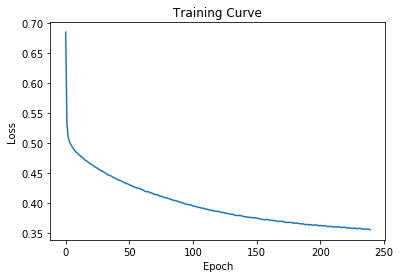

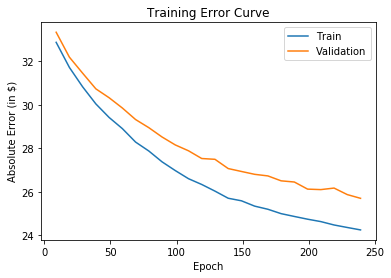

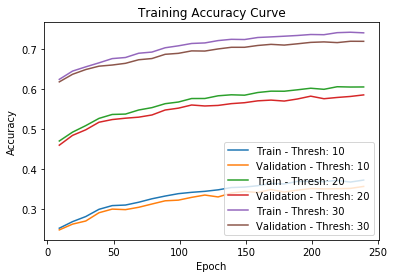

---[ITER 10] loss: 0.353020  time: 0.234
---[ITER 20] loss: 0.365122  time: 0.292
---[ITER 30] loss: 0.354136  time: 0.178
---[ITER 40] loss: 0.355518  time: 0.168
---[ITER 50] loss: 0.354473  time: 0.164
---[ITER 60] loss: 0.352185  time: 0.182
---[ITER 70] loss: 0.351660  time: 0.196
---[ITER 80] loss: 0.357207  time: 0.196
---[ITER 90] loss: 0.358382  time: 0.180
---[ITER 100] loss: 0.352244  time: 0.180
---[ITER 110] loss: 0.357602  time: 0.144
---[ITER 120] loss: 0.365774  time: 0.188
---[ITER 130] loss: 0.356946  time: 0.199
---[ITER 140] loss: 0.361127  time: 0.184
---[ITER 150] loss: 0.355559  time: 0.155
---[ITER 160] loss: 0.349280  time: 0.169
[EPOCH 241] loss: 0.356034  time: 3.144
---[ITER 10] loss: 0.360366  time: 0.302
---[ITER 20] loss: 0.354159  time: 0.290
---[ITER 30] loss: 0.357532  time: 0.182
---[ITER 40] loss: 0.354996  time: 0.171
---[ITER 50] loss: 0.354573  time: 0.174
---[ITER 60] loss: 0.357723  time: 0.169
---[ITER 70] loss: 0.366056  time: 0.189
---[ITER 8

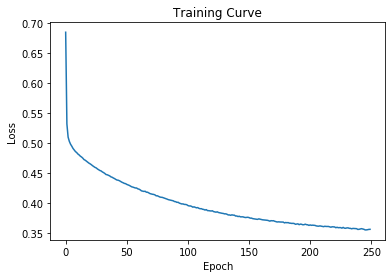

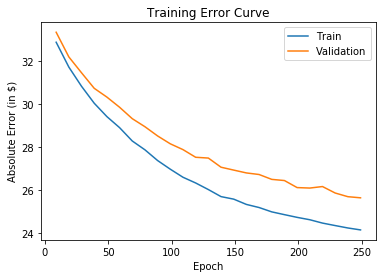

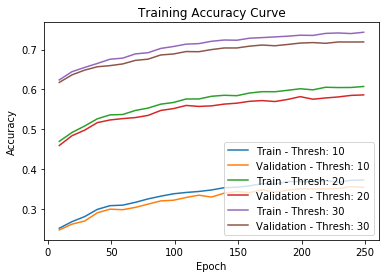

---[ITER 10] loss: 0.355218  time: 0.420
---[ITER 20] loss: 0.358570  time: 0.203
---[ITER 30] loss: 0.351818  time: 0.177
---[ITER 40] loss: 0.355737  time: 0.376
---[ITER 50] loss: 0.354151  time: 0.296
---[ITER 60] loss: 0.354080  time: 0.301
---[ITER 70] loss: 0.356214  time: 0.429
---[ITER 80] loss: 0.354376  time: 0.257
---[ITER 90] loss: 0.363422  time: 0.185
---[ITER 100] loss: 0.356701  time: 0.205
---[ITER 110] loss: 0.353518  time: 0.230
---[ITER 120] loss: 0.354719  time: 0.190
---[ITER 130] loss: 0.353533  time: 0.239
---[ITER 140] loss: 0.353968  time: 0.161
---[ITER 150] loss: 0.350820  time: 0.176
---[ITER 160] loss: 0.347538  time: 0.196
[EPOCH 251] loss: 0.354717  time: 4.194
---[ITER 10] loss: 0.356727  time: 0.406
---[ITER 20] loss: 0.361374  time: 0.173
---[ITER 30] loss: 0.349335  time: 0.174
---[ITER 40] loss: 0.355717  time: 0.192
---[ITER 50] loss: 0.352566  time: 0.198
---[ITER 60] loss: 0.353306  time: 0.193
---[ITER 70] loss: 0.356885  time: 0.184
---[ITER 8

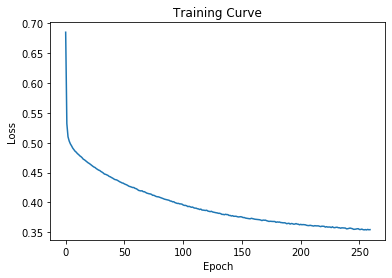

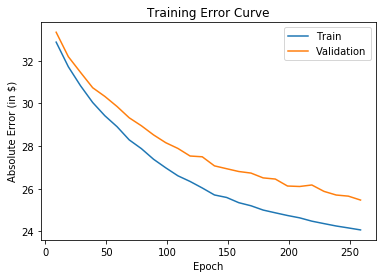

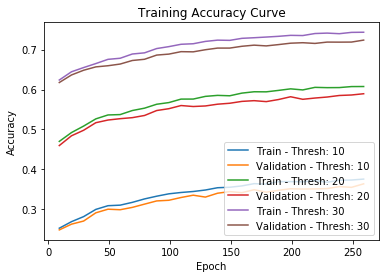

---[ITER 10] loss: 0.350502  time: 0.252
---[ITER 20] loss: 0.347981  time: 0.222
---[ITER 30] loss: 0.358393  time: 0.218
---[ITER 40] loss: 0.356007  time: 0.304
---[ITER 50] loss: 0.355131  time: 0.225
---[ITER 60] loss: 0.356238  time: 0.215
---[ITER 70] loss: 0.352320  time: 0.204
---[ITER 80] loss: 0.355171  time: 0.238
---[ITER 90] loss: 0.349240  time: 0.295
---[ITER 100] loss: 0.352721  time: 0.269
---[ITER 110] loss: 0.352519  time: 0.197
---[ITER 120] loss: 0.357791  time: 0.191
---[ITER 130] loss: 0.355241  time: 0.170
---[ITER 140] loss: 0.353756  time: 0.185
---[ITER 150] loss: 0.357618  time: 0.192
---[ITER 160] loss: 0.356155  time: 0.192
[EPOCH 261] loss: 0.354163  time: 3.718
---[ITER 10] loss: 0.348709  time: 0.224
---[ITER 20] loss: 0.352924  time: 0.199
---[ITER 30] loss: 0.351275  time: 0.178
---[ITER 40] loss: 0.344850  time: 0.276
---[ITER 50] loss: 0.354479  time: 0.183
---[ITER 60] loss: 0.351030  time: 0.163
---[ITER 70] loss: 0.352474  time: 0.200
---[ITER 8

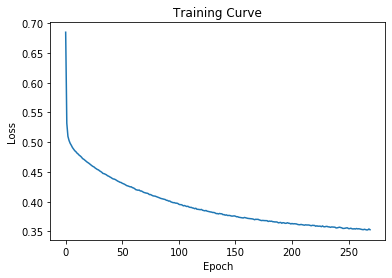

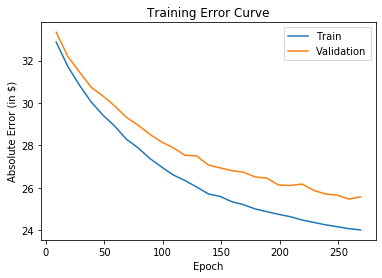

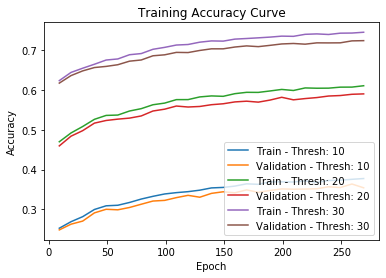

---[ITER 10] loss: 0.353951  time: 0.260
---[ITER 20] loss: 0.351006  time: 0.151
---[ITER 30] loss: 0.348546  time: 0.299
---[ITER 40] loss: 0.351718  time: 0.171
---[ITER 50] loss: 0.344458  time: 0.175
---[ITER 60] loss: 0.351246  time: 0.153
---[ITER 70] loss: 0.356449  time: 0.194
---[ITER 80] loss: 0.353607  time: 0.169
---[ITER 90] loss: 0.355200  time: 0.174
---[ITER 100] loss: 0.352716  time: 0.171
---[ITER 110] loss: 0.352419  time: 0.202
---[ITER 120] loss: 0.353289  time: 0.166
---[ITER 130] loss: 0.352633  time: 0.191
---[ITER 140] loss: 0.356141  time: 0.206
---[ITER 150] loss: 0.351290  time: 0.185
---[ITER 160] loss: 0.348362  time: 0.200
[EPOCH 271] loss: 0.352284  time: 3.211
---[ITER 10] loss: 0.350726  time: 0.260
---[ITER 20] loss: 0.350810  time: 0.157
---[ITER 30] loss: 0.351592  time: 0.192
---[ITER 40] loss: 0.350099  time: 0.151
---[ITER 50] loss: 0.342321  time: 0.192
---[ITER 60] loss: 0.352067  time: 0.281
---[ITER 70] loss: 0.354812  time: 0.243
---[ITER 8

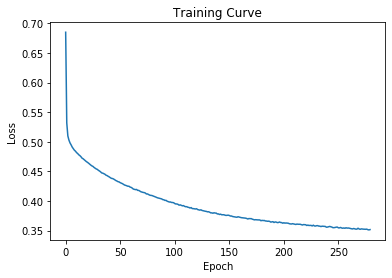

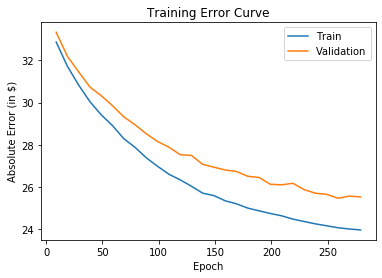

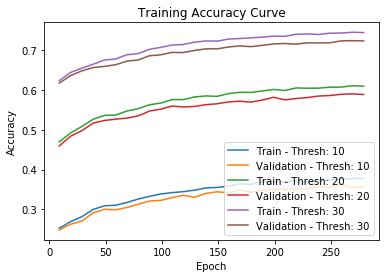

---[ITER 10] loss: 0.350705  time: 0.385
---[ITER 20] loss: 0.353530  time: 0.322
---[ITER 30] loss: 0.351768  time: 0.249
---[ITER 40] loss: 0.352727  time: 0.228
---[ITER 50] loss: 0.346263  time: 0.236
---[ITER 60] loss: 0.349758  time: 0.201
---[ITER 70] loss: 0.347435  time: 0.271
---[ITER 80] loss: 0.352343  time: 0.218
---[ITER 90] loss: 0.346739  time: 0.226
---[ITER 100] loss: 0.350299  time: 0.154
---[ITER 110] loss: 0.353320  time: 0.214
---[ITER 120] loss: 0.356191  time: 0.223
---[ITER 130] loss: 0.354685  time: 0.207
---[ITER 140] loss: 0.357923  time: 0.263
---[ITER 150] loss: 0.348177  time: 0.208
---[ITER 160] loss: 0.354951  time: 0.243
[EPOCH 281] loss: 0.352196  time: 4.043
---[ITER 10] loss: 0.353233  time: 0.301
---[ITER 20] loss: 0.357144  time: 0.334
---[ITER 30] loss: 0.351191  time: 0.226
---[ITER 40] loss: 0.353545  time: 0.433
---[ITER 50] loss: 0.349727  time: 0.811
---[ITER 60] loss: 0.347903  time: 1.741
---[ITER 70] loss: 0.348470  time: 0.841
---[ITER 8

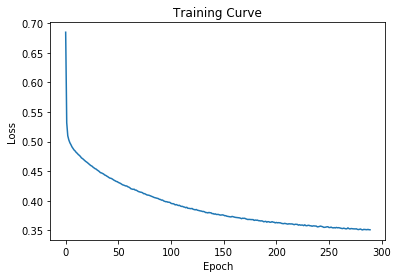

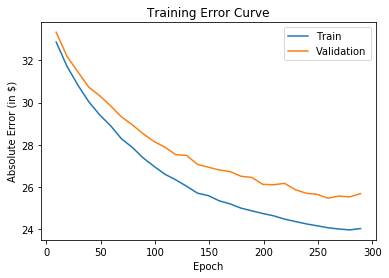

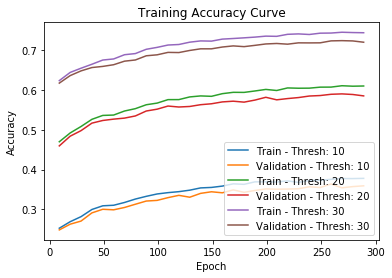

---[ITER 10] loss: 0.354582  time: 0.698
---[ITER 20] loss: 0.355889  time: 0.347
---[ITER 30] loss: 0.347127  time: 0.242
---[ITER 40] loss: 0.348168  time: 0.403
---[ITER 50] loss: 0.348426  time: 0.345
---[ITER 60] loss: 0.344838  time: 0.383
---[ITER 70] loss: 0.353270  time: 0.340
---[ITER 80] loss: 0.347723  time: 0.525
---[ITER 90] loss: 0.349829  time: 0.427
---[ITER 100] loss: 0.357558  time: 0.398
---[ITER 110] loss: 0.353179  time: 0.365
---[ITER 120] loss: 0.345354  time: 0.430
---[ITER 130] loss: 0.354623  time: 0.332
---[ITER 140] loss: 0.358950  time: 0.224
---[ITER 150] loss: 0.350558  time: 0.318
---[ITER 160] loss: 0.348035  time: 0.380
[EPOCH 291] loss: 0.351526  time: 6.491
---[ITER 10] loss: 0.351489  time: 0.856
---[ITER 20] loss: 0.350068  time: 0.277
---[ITER 30] loss: 0.352554  time: 0.221
---[ITER 40] loss: 0.347751  time: 0.423
---[ITER 50] loss: 0.354537  time: 0.254
---[ITER 60] loss: 0.350475  time: 0.243
---[ITER 70] loss: 0.356343  time: 0.254
---[ITER 8

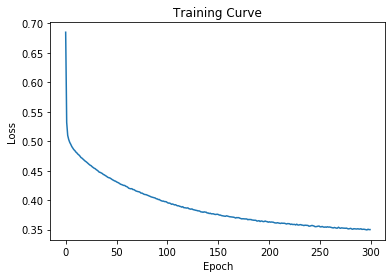

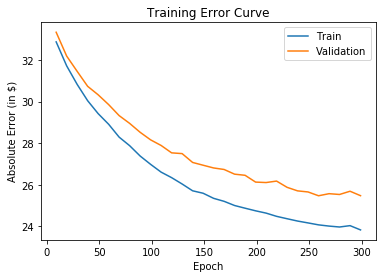

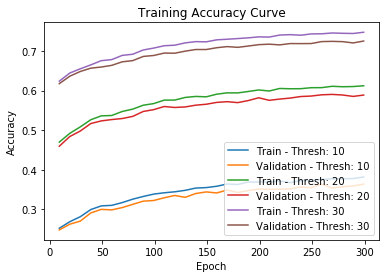

---[ITER 10] loss: 0.351004  time: 0.379
---[ITER 20] loss: 0.350939  time: 0.301
---[ITER 30] loss: 0.351470  time: 0.826
---[ITER 40] loss: 0.344880  time: 0.269
---[ITER 50] loss: 0.346675  time: 0.417
---[ITER 60] loss: 0.353814  time: 0.287
---[ITER 70] loss: 0.342540  time: 0.378
---[ITER 80] loss: 0.349637  time: 0.250
---[ITER 90] loss: 0.352613  time: 0.406
---[ITER 100] loss: 0.350894  time: 0.638
---[ITER 110] loss: 0.358569  time: 0.495
---[ITER 120] loss: 0.339888  time: 0.363
---[ITER 130] loss: 0.350745  time: 0.259
---[ITER 140] loss: 0.349768  time: 0.282
---[ITER 150] loss: 0.355818  time: 0.205
---[ITER 160] loss: 0.348318  time: 0.206
[EPOCH 301] loss: 0.349654  time: 6.140
---[ITER 10] loss: 0.353340  time: 1.027
---[ITER 20] loss: 0.351151  time: 1.285
---[ITER 30] loss: 0.349481  time: 0.765
---[ITER 40] loss: 0.349262  time: 0.310
---[ITER 50] loss: 0.345397  time: 1.330
---[ITER 60] loss: 0.350292  time: 1.559
---[ITER 70] loss: 0.353924  time: 0.440
---[ITER 8

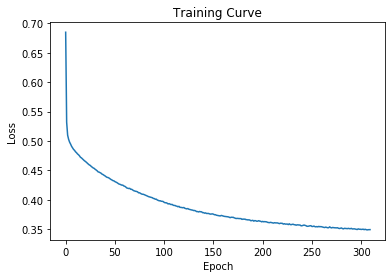

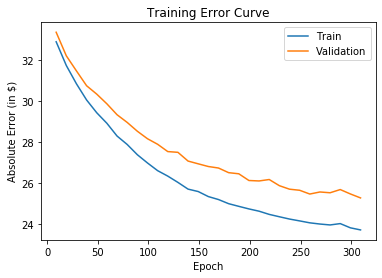

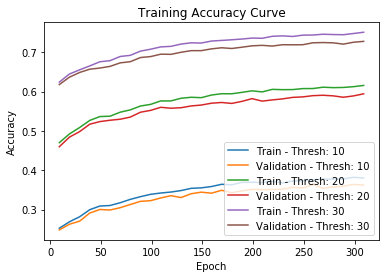

---[ITER 10] loss: 0.344681  time: 0.252
---[ITER 20] loss: 0.351397  time: 0.334
---[ITER 30] loss: 0.344266  time: 0.237
---[ITER 40] loss: 0.346041  time: 0.216
---[ITER 50] loss: 0.342038  time: 0.237
---[ITER 60] loss: 0.345658  time: 0.195
---[ITER 70] loss: 0.353674  time: 0.247
---[ITER 80] loss: 0.346299  time: 0.212
---[ITER 90] loss: 0.348997  time: 0.245
---[ITER 100] loss: 0.358480  time: 0.247
---[ITER 110] loss: 0.342990  time: 0.274
---[ITER 120] loss: 0.358863  time: 0.232
---[ITER 130] loss: 0.350194  time: 0.244
---[ITER 140] loss: 0.347963  time: 0.259
---[ITER 150] loss: 0.342114  time: 0.250
---[ITER 160] loss: 0.354357  time: 0.244
[EPOCH 311] loss: 0.348396  time: 4.110
---[ITER 10] loss: 0.340243  time: 0.327
---[ITER 20] loss: 0.354131  time: 0.366
---[ITER 30] loss: 0.345320  time: 0.232
---[ITER 40] loss: 0.351050  time: 0.232
---[ITER 50] loss: 0.350126  time: 0.216
---[ITER 60] loss: 0.351162  time: 0.196
---[ITER 70] loss: 0.350198  time: 0.216
---[ITER 8

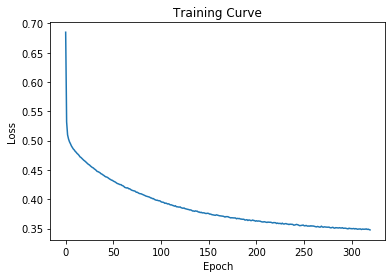

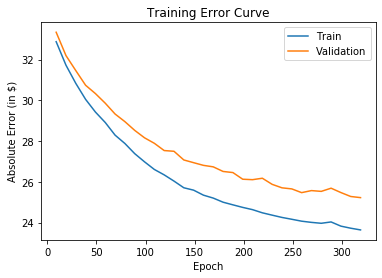

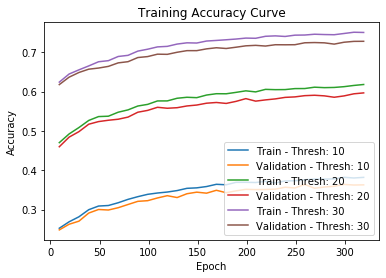

---[ITER 10] loss: 0.357085  time: 0.379
---[ITER 20] loss: 0.339319  time: 0.177
---[ITER 30] loss: 0.344164  time: 0.180
---[ITER 40] loss: 0.353999  time: 0.240
---[ITER 50] loss: 0.351481  time: 0.251
---[ITER 60] loss: 0.349021  time: 0.202
---[ITER 70] loss: 0.345920  time: 0.222
---[ITER 80] loss: 0.351191  time: 0.249
---[ITER 90] loss: 0.348612  time: 0.232
---[ITER 100] loss: 0.349594  time: 0.246
---[ITER 110] loss: 0.344276  time: 0.218
---[ITER 120] loss: 0.346351  time: 0.249
---[ITER 130] loss: 0.341059  time: 0.286
---[ITER 140] loss: 0.357467  time: 0.246
---[ITER 150] loss: 0.349393  time: 0.221
---[ITER 160] loss: 0.340350  time: 0.253
[EPOCH 321] loss: 0.347763  time: 4.043
---[ITER 10] loss: 0.347722  time: 0.447
---[ITER 20] loss: 0.344232  time: 0.254
---[ITER 30] loss: 0.345928  time: 0.227
---[ITER 40] loss: 0.355040  time: 0.228
---[ITER 50] loss: 0.356245  time: 0.234
---[ITER 60] loss: 0.351915  time: 0.200
---[ITER 70] loss: 0.353433  time: 0.256
---[ITER 8

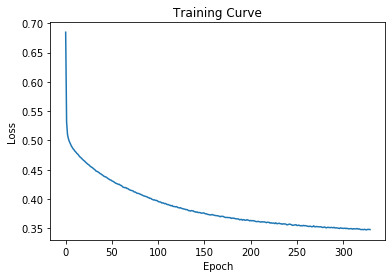

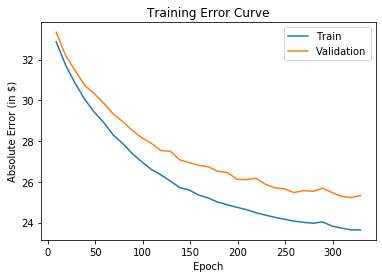

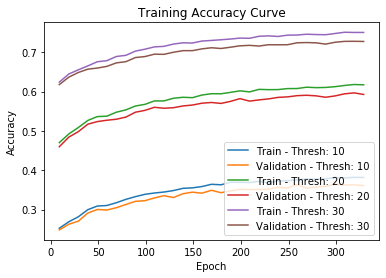

---[ITER 10] loss: 0.345456  time: 0.400
---[ITER 20] loss: 0.347916  time: 0.182
---[ITER 30] loss: 0.348435  time: 0.183
---[ITER 40] loss: 0.345495  time: 0.180
---[ITER 50] loss: 0.344537  time: 0.179
---[ITER 60] loss: 0.347305  time: 0.179
---[ITER 70] loss: 0.352877  time: 0.183
---[ITER 80] loss: 0.344172  time: 0.187
---[ITER 90] loss: 0.350274  time: 0.264
---[ITER 100] loss: 0.348808  time: 0.249
---[ITER 110] loss: 0.351226  time: 0.248
---[ITER 120] loss: 0.351805  time: 0.298
---[ITER 130] loss: 0.346579  time: 0.220
---[ITER 140] loss: 0.342751  time: 0.379
---[ITER 150] loss: 0.346452  time: 0.233
---[ITER 160] loss: 0.349175  time: 0.246
[EPOCH 331] loss: 0.347673  time: 4.000
---[ITER 10] loss: 0.337640  time: 0.483
---[ITER 20] loss: 0.342387  time: 0.213
---[ITER 30] loss: 0.349431  time: 0.199
---[ITER 40] loss: 0.350009  time: 0.229
---[ITER 50] loss: 0.350829  time: 0.215
---[ITER 60] loss: 0.342978  time: 0.209
---[ITER 70] loss: 0.350332  time: 0.220
---[ITER 8

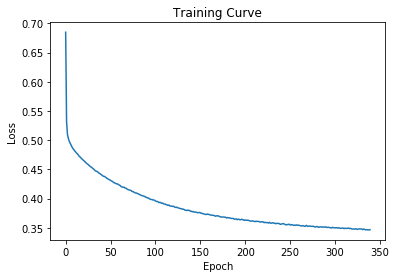

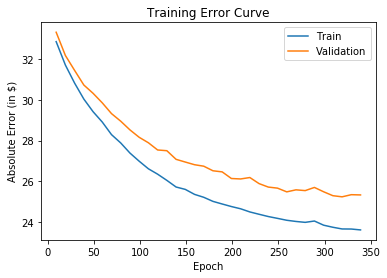

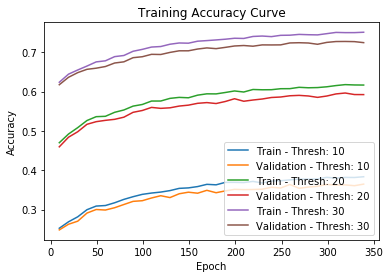

---[ITER 10] loss: 0.348029  time: 0.330
---[ITER 20] loss: 0.340546  time: 0.193
---[ITER 30] loss: 0.340920  time: 0.320
---[ITER 40] loss: 0.346352  time: 0.272
---[ITER 50] loss: 0.345380  time: 0.171
---[ITER 60] loss: 0.342790  time: 0.245
---[ITER 70] loss: 0.346113  time: 0.192
---[ITER 80] loss: 0.338542  time: 0.194
---[ITER 90] loss: 0.342472  time: 0.212
---[ITER 100] loss: 0.348424  time: 0.160
---[ITER 110] loss: 0.344438  time: 0.178
---[ITER 120] loss: 0.345956  time: 0.197
---[ITER 130] loss: 0.347589  time: 0.183
---[ITER 140] loss: 0.342670  time: 0.278
---[ITER 150] loss: 0.353484  time: 0.205
---[ITER 160] loss: 0.359992  time: 0.181
[EPOCH 341] loss: 0.345858  time: 3.687
---[ITER 10] loss: 0.343214  time: 0.301
---[ITER 20] loss: 0.341952  time: 0.196
---[ITER 30] loss: 0.344255  time: 0.315
---[ITER 40] loss: 0.338592  time: 0.213
---[ITER 50] loss: 0.349271  time: 0.218
---[ITER 60] loss: 0.345373  time: 0.217
---[ITER 70] loss: 0.343288  time: 0.229
---[ITER 8

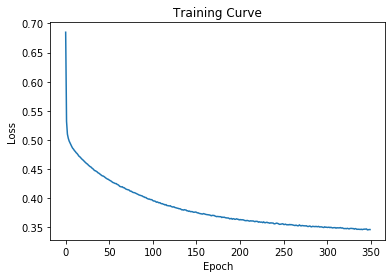

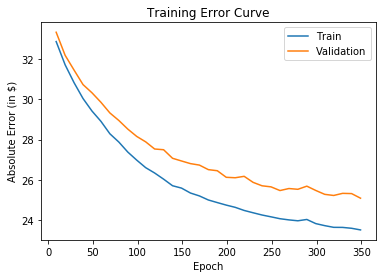

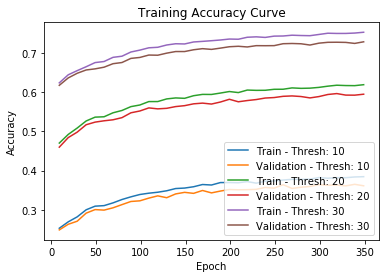

---[ITER 10] loss: 0.344926  time: 0.248
---[ITER 20] loss: 0.347881  time: 0.306
---[ITER 30] loss: 0.346648  time: 0.195
---[ITER 40] loss: 0.346594  time: 0.194
---[ITER 50] loss: 0.337822  time: 0.203
---[ITER 60] loss: 0.342060  time: 0.187
---[ITER 70] loss: 0.340563  time: 0.200
---[ITER 80] loss: 0.349799  time: 0.211
---[ITER 90] loss: 0.347193  time: 0.190
---[ITER 100] loss: 0.347041  time: 0.193
---[ITER 110] loss: 0.347773  time: 0.163
---[ITER 120] loss: 0.343788  time: 0.175
---[ITER 130] loss: 0.350925  time: 0.214
---[ITER 140] loss: 0.349874  time: 0.179
---[ITER 150] loss: 0.349913  time: 0.252
---[ITER 160] loss: 0.343739  time: 0.208
[EPOCH 351] loss: 0.345945  time: 3.463
---[ITER 10] loss: 0.347621  time: 0.333
---[ITER 20] loss: 0.344657  time: 0.343
---[ITER 30] loss: 0.349706  time: 0.222
---[ITER 40] loss: 0.349923  time: 0.255
---[ITER 50] loss: 0.347249  time: 0.191
---[ITER 60] loss: 0.348963  time: 0.196
---[ITER 70] loss: 0.344992  time: 0.226
---[ITER 8

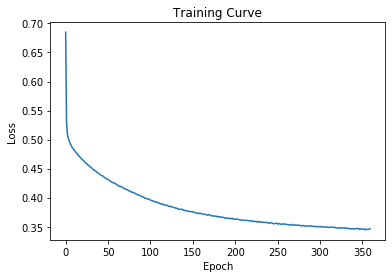

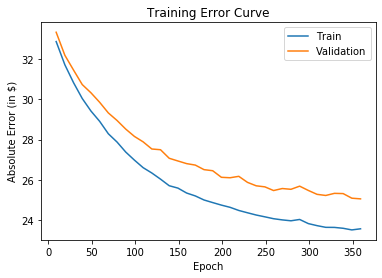

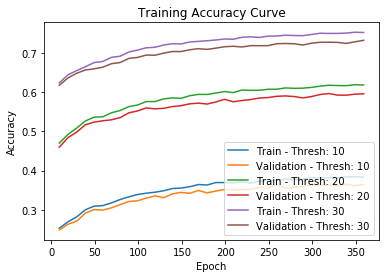

---[ITER 10] loss: 0.348212  time: 0.413
---[ITER 20] loss: 0.348426  time: 0.182
---[ITER 30] loss: 0.344363  time: 0.170
---[ITER 40] loss: 0.340121  time: 0.184
---[ITER 50] loss: 0.342157  time: 0.182
---[ITER 60] loss: 0.346773  time: 0.188
---[ITER 70] loss: 0.346442  time: 0.179
---[ITER 80] loss: 0.346429  time: 0.199
---[ITER 90] loss: 0.341335  time: 0.205
---[ITER 100] loss: 0.344607  time: 0.184
---[ITER 110] loss: 0.343055  time: 0.179
---[ITER 120] loss: 0.349154  time: 0.168
---[ITER 130] loss: 0.345643  time: 0.219
---[ITER 140] loss: 0.341801  time: 0.179
---[ITER 150] loss: 0.348116  time: 0.164
---[ITER 160] loss: 0.353382  time: 0.165
[EPOCH 361] loss: 0.345478  time: 3.332
---[ITER 10] loss: 0.347361  time: 0.410
---[ITER 20] loss: 0.345746  time: 0.209
---[ITER 30] loss: 0.346112  time: 0.186
---[ITER 40] loss: 0.345080  time: 0.230
---[ITER 50] loss: 0.350639  time: 0.242
---[ITER 60] loss: 0.350337  time: 0.182
---[ITER 70] loss: 0.347017  time: 0.188
---[ITER 8

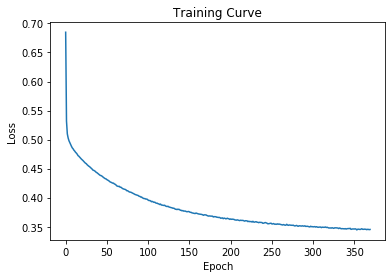

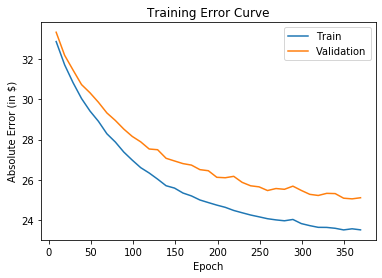

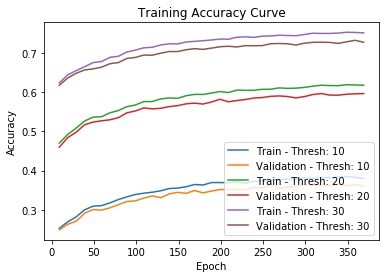

---[ITER 10] loss: 0.342173  time: 0.292
---[ITER 20] loss: 0.344944  time: 0.190
---[ITER 30] loss: 0.344298  time: 0.197
---[ITER 40] loss: 0.347572  time: 0.305
---[ITER 50] loss: 0.346330  time: 0.193
---[ITER 60] loss: 0.345986  time: 0.179
---[ITER 70] loss: 0.337927  time: 0.217
---[ITER 80] loss: 0.343350  time: 0.169
---[ITER 90] loss: 0.350793  time: 0.193
---[ITER 100] loss: 0.348688  time: 0.236
---[ITER 110] loss: 0.349929  time: 0.171
---[ITER 120] loss: 0.349703  time: 0.215
---[ITER 130] loss: 0.339824  time: 0.188
---[ITER 140] loss: 0.347566  time: 0.186
---[ITER 150] loss: 0.347482  time: 0.237
---[ITER 160] loss: 0.345082  time: 0.179
[EPOCH 371] loss: 0.345446  time: 3.510
---[ITER 10] loss: 0.346127  time: 0.249
---[ITER 20] loss: 0.342209  time: 0.172
---[ITER 30] loss: 0.351808  time: 0.194
---[ITER 40] loss: 0.346127  time: 0.271
---[ITER 50] loss: 0.337260  time: 0.223
---[ITER 60] loss: 0.339955  time: 0.227
---[ITER 70] loss: 0.342778  time: 0.242
---[ITER 8

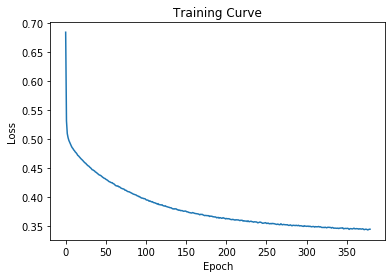

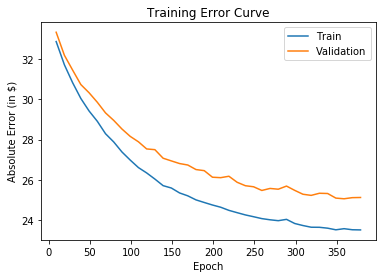

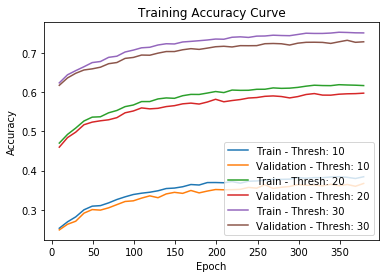

---[ITER 10] loss: 0.351034  time: 0.276
---[ITER 20] loss: 0.343640  time: 0.165
---[ITER 30] loss: 0.345358  time: 0.346
---[ITER 40] loss: 0.342115  time: 0.215
---[ITER 50] loss: 0.337473  time: 0.238
---[ITER 60] loss: 0.342673  time: 0.233
---[ITER 70] loss: 0.343365  time: 0.204
---[ITER 80] loss: 0.340448  time: 0.205
---[ITER 90] loss: 0.346468  time: 0.182
---[ITER 100] loss: 0.349758  time: 0.180
---[ITER 110] loss: 0.342254  time: 0.195
---[ITER 120] loss: 0.341623  time: 0.185
---[ITER 130] loss: 0.346634  time: 0.170
---[ITER 140] loss: 0.341234  time: 0.233
---[ITER 150] loss: 0.354854  time: 0.187
---[ITER 160] loss: 0.341325  time: 0.214
[EPOCH 381] loss: 0.344455  time: 3.599
---[ITER 10] loss: 0.347519  time: 0.250
---[ITER 20] loss: 0.343786  time: 0.180
---[ITER 30] loss: 0.338348  time: 0.296
---[ITER 40] loss: 0.347923  time: 0.175
---[ITER 50] loss: 0.339883  time: 0.186
---[ITER 60] loss: 0.350554  time: 0.169
---[ITER 70] loss: 0.340419  time: 0.184
---[ITER 8

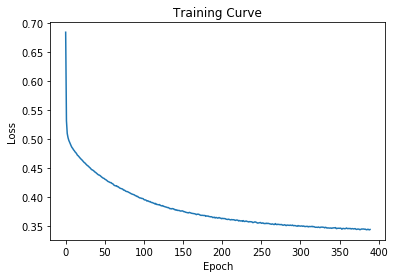

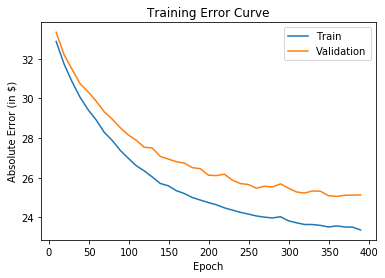

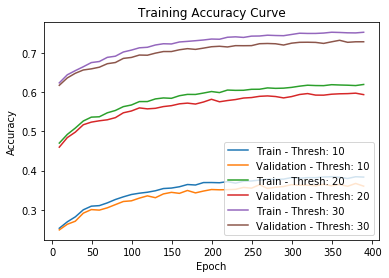

---[ITER 10] loss: 0.335222  time: 0.308
---[ITER 20] loss: 0.343678  time: 0.346
---[ITER 30] loss: 0.348165  time: 0.201
---[ITER 40] loss: 0.348576  time: 0.208
---[ITER 50] loss: 0.345576  time: 0.187
---[ITER 60] loss: 0.341995  time: 0.199
---[ITER 70] loss: 0.337643  time: 0.200
---[ITER 80] loss: 0.343836  time: 0.182
---[ITER 90] loss: 0.339794  time: 0.178
---[ITER 100] loss: 0.347614  time: 0.199
---[ITER 110] loss: 0.333936  time: 0.197
---[ITER 120] loss: 0.346040  time: 0.191
---[ITER 130] loss: 0.348585  time: 0.257
---[ITER 140] loss: 0.338303  time: 0.171
---[ITER 150] loss: 0.345633  time: 0.197
---[ITER 160] loss: 0.339060  time: 0.193
[EPOCH 391] loss: 0.342812  time: 3.625
---[ITER 10] loss: 0.338458  time: 0.380
---[ITER 20] loss: 0.340651  time: 0.315
---[ITER 30] loss: 0.345305  time: 0.199
---[ITER 40] loss: 0.340486  time: 0.186
---[ITER 50] loss: 0.346833  time: 0.168
---[ITER 60] loss: 0.343149  time: 0.194
---[ITER 70] loss: 0.345261  time: 0.177
---[ITER 8

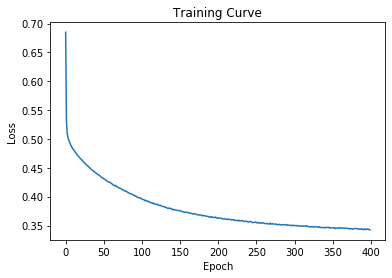

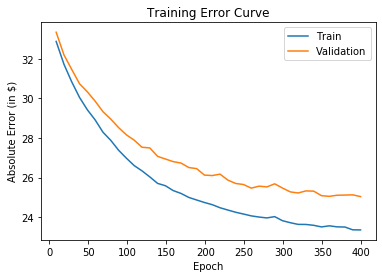

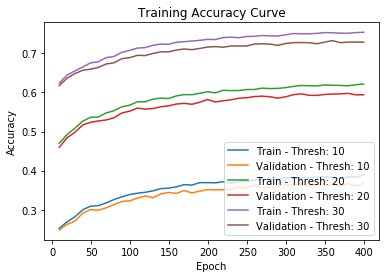

---[ITER 10] loss: 0.339964  time: 0.432
---[ITER 20] loss: 0.342123  time: 0.238
---[ITER 30] loss: 0.340300  time: 0.185
---[ITER 40] loss: 0.339189  time: 0.212
---[ITER 50] loss: 0.342649  time: 0.197
---[ITER 60] loss: 0.346821  time: 0.237
---[ITER 70] loss: 0.343413  time: 0.171
---[ITER 80] loss: 0.345261  time: 0.193
---[ITER 90] loss: 0.340666  time: 0.184
---[ITER 100] loss: 0.348245  time: 0.177
---[ITER 110] loss: 0.347788  time: 0.191
---[ITER 120] loss: 0.343277  time: 0.231
---[ITER 130] loss: 0.345088  time: 0.164
---[ITER 140] loss: 0.338058  time: 0.197
---[ITER 150] loss: 0.343002  time: 0.181
---[ITER 160] loss: 0.336935  time: 0.177
[EPOCH 401] loss: 0.342524  time: 3.523
---[ITER 10] loss: 0.333495  time: 0.395
---[ITER 20] loss: 0.343269  time: 0.199
---[ITER 30] loss: 0.339454  time: 0.189
---[ITER 40] loss: 0.343665  time: 0.160
---[ITER 50] loss: 0.345535  time: 0.183
---[ITER 60] loss: 0.339511  time: 0.165
---[ITER 70] loss: 0.344429  time: 0.194
---[ITER 8

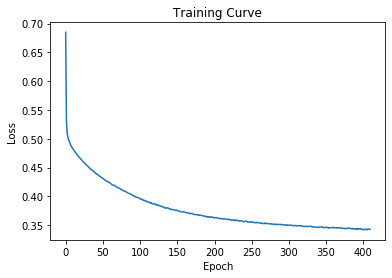

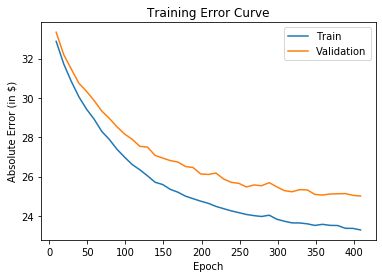

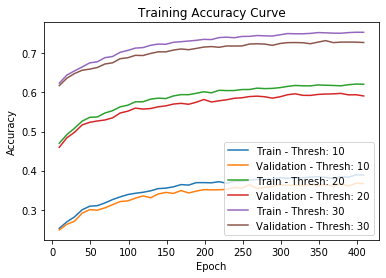

---[ITER 10] loss: 0.342085  time: 0.280
---[ITER 20] loss: 0.343297  time: 0.203
---[ITER 30] loss: 0.341438  time: 0.328
---[ITER 40] loss: 0.339766  time: 0.222
---[ITER 50] loss: 0.342820  time: 0.163
---[ITER 60] loss: 0.348296  time: 0.191
---[ITER 70] loss: 0.336772  time: 0.184
---[ITER 80] loss: 0.339276  time: 0.175
---[ITER 90] loss: 0.337482  time: 0.179
---[ITER 100] loss: 0.337407  time: 0.200
---[ITER 110] loss: 0.345712  time: 0.166
---[ITER 120] loss: 0.341640  time: 0.185
---[ITER 130] loss: 0.347230  time: 0.208
---[ITER 140] loss: 0.335090  time: 0.162
---[ITER 150] loss: 0.351463  time: 0.243
---[ITER 160] loss: 0.342769  time: 0.231
[EPOCH 411] loss: 0.342155  time: 3.496
---[ITER 10] loss: 0.339290  time: 0.247
---[ITER 20] loss: 0.343058  time: 0.190
---[ITER 30] loss: 0.344235  time: 0.294
---[ITER 40] loss: 0.343079  time: 0.176
---[ITER 50] loss: 0.349489  time: 0.177
---[ITER 60] loss: 0.347017  time: 0.209
---[ITER 70] loss: 0.335710  time: 0.164
---[ITER 8

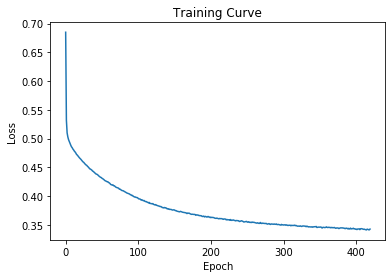

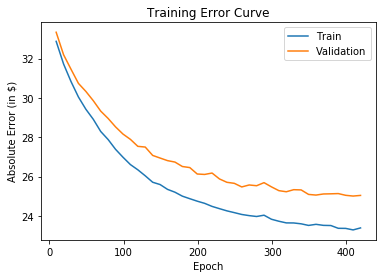

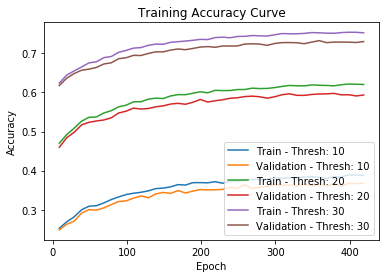

---[ITER 10] loss: 0.342440  time: 0.334
---[ITER 20] loss: 0.336202  time: 0.337
---[ITER 30] loss: 0.343800  time: 0.257
---[ITER 40] loss: 0.345811  time: 0.288
---[ITER 50] loss: 0.333450  time: 0.238
---[ITER 60] loss: 0.347649  time: 0.232
---[ITER 70] loss: 0.348823  time: 0.233
---[ITER 80] loss: 0.334841  time: 0.218
---[ITER 90] loss: 0.341692  time: 0.192
---[ITER 100] loss: 0.348100  time: 0.190
---[ITER 110] loss: 0.341531  time: 0.170
---[ITER 120] loss: 0.340151  time: 0.184
---[ITER 130] loss: 0.339426  time: 0.196
---[ITER 140] loss: 0.344904  time: 0.218
---[ITER 150] loss: 0.334847  time: 0.191
---[ITER 160] loss: 0.344634  time: 0.206
[EPOCH 421] loss: 0.341732  time: 3.835
---[ITER 10] loss: 0.344967  time: 0.257
---[ITER 20] loss: 0.340712  time: 0.332
---[ITER 30] loss: 0.342929  time: 0.159
---[ITER 40] loss: 0.345619  time: 0.187
---[ITER 50] loss: 0.343129  time: 0.209
---[ITER 60] loss: 0.336303  time: 0.170
---[ITER 70] loss: 0.340519  time: 0.193
---[ITER 8

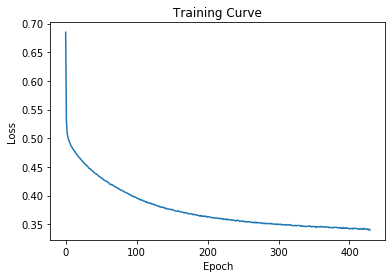

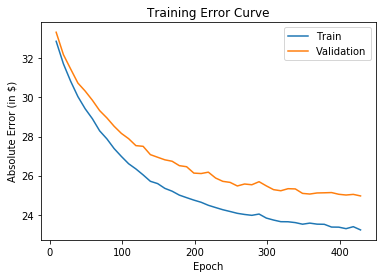

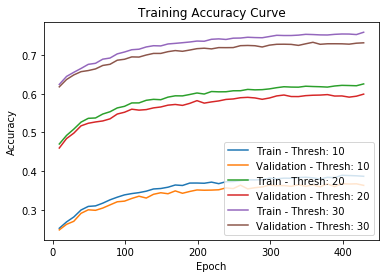

---[ITER 10] loss: 0.342070  time: 0.419
---[ITER 20] loss: 0.338700  time: 0.239
---[ITER 30] loss: 0.333561  time: 0.224
---[ITER 40] loss: 0.331958  time: 0.198
---[ITER 50] loss: 0.342498  time: 0.181
---[ITER 60] loss: 0.343695  time: 0.177
---[ITER 70] loss: 0.336339  time: 0.225
---[ITER 80] loss: 0.336391  time: 0.196
---[ITER 90] loss: 0.349240  time: 0.226
---[ITER 100] loss: 0.346034  time: 0.188
---[ITER 110] loss: 0.340443  time: 0.175
---[ITER 120] loss: 0.346513  time: 0.172
---[ITER 130] loss: 0.343604  time: 0.241
---[ITER 140] loss: 0.338292  time: 0.183
---[ITER 150] loss: 0.337581  time: 0.174
---[ITER 160] loss: 0.341902  time: 0.182
[EPOCH 431] loss: 0.340784  time: 3.563
---[ITER 10] loss: 0.341325  time: 0.374
---[ITER 20] loss: 0.337709  time: 0.166
---[ITER 30] loss: 0.341636  time: 0.177
---[ITER 40] loss: 0.342390  time: 0.182
---[ITER 50] loss: 0.336468  time: 0.171
---[ITER 60] loss: 0.341514  time: 0.176
---[ITER 70] loss: 0.339884  time: 0.182
---[ITER 8

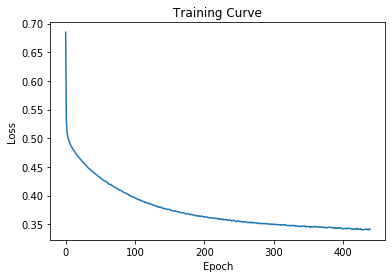

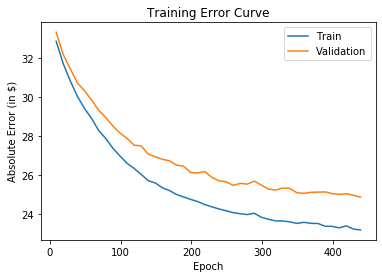

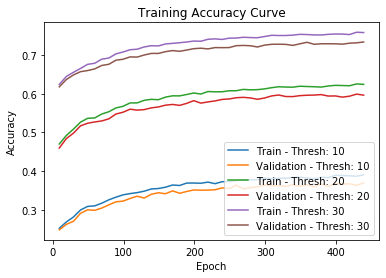

---[ITER 10] loss: 0.344718  time: 0.481
---[ITER 20] loss: 0.338721  time: 0.232
---[ITER 30] loss: 0.339472  time: 0.222
---[ITER 40] loss: 0.336635  time: 0.201
---[ITER 50] loss: 0.340045  time: 0.225
---[ITER 60] loss: 0.343875  time: 0.217
---[ITER 70] loss: 0.339979  time: 0.206
---[ITER 80] loss: 0.341231  time: 0.234
---[ITER 90] loss: 0.339024  time: 0.220
---[ITER 100] loss: 0.342518  time: 0.224
---[ITER 110] loss: 0.340944  time: 0.219
---[ITER 120] loss: 0.344075  time: 0.280
---[ITER 130] loss: 0.347169  time: 0.213
---[ITER 140] loss: 0.346113  time: 0.195
---[ITER 150] loss: 0.344505  time: 0.205
---[ITER 160] loss: 0.332956  time: 0.187
[EPOCH 441] loss: 0.341252  time: 3.927
---[ITER 10] loss: 0.341740  time: 0.398
---[ITER 20] loss: 0.338245  time: 0.190
---[ITER 30] loss: 0.343211  time: 0.163
---[ITER 40] loss: 0.343495  time: 0.211
---[ITER 50] loss: 0.335440  time: 0.179
---[ITER 60] loss: 0.338312  time: 0.165
---[ITER 70] loss: 0.340985  time: 0.197
---[ITER 8

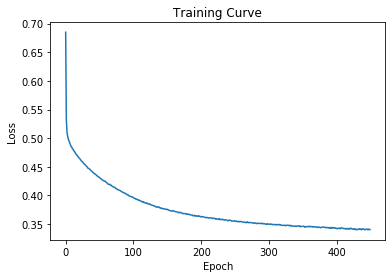

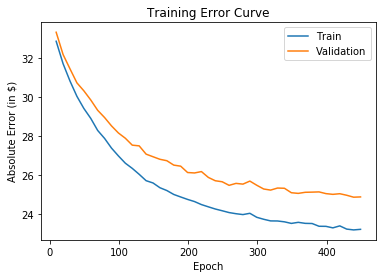

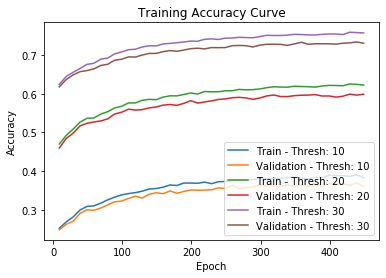

---[ITER 10] loss: 0.338760  time: 0.261
---[ITER 20] loss: 0.333414  time: 0.318
---[ITER 30] loss: 0.339337  time: 0.390
---[ITER 40] loss: 0.340564  time: 0.268
---[ITER 50] loss: 0.336889  time: 0.309
---[ITER 60] loss: 0.347472  time: 0.289
---[ITER 70] loss: 0.339449  time: 0.281
---[ITER 80] loss: 0.343928  time: 0.220
---[ITER 90] loss: 0.339632  time: 0.208
---[ITER 100] loss: 0.343691  time: 0.225
---[ITER 110] loss: 0.342339  time: 0.227
---[ITER 120] loss: 0.345116  time: 0.217
---[ITER 130] loss: 0.344811  time: 0.245
---[ITER 140] loss: 0.338865  time: 0.241
---[ITER 150] loss: 0.335831  time: 0.202
---[ITER 160] loss: 0.332486  time: 0.215
[EPOCH 451] loss: 0.340685  time: 4.287
---[ITER 10] loss: 0.333391  time: 0.276
---[ITER 20] loss: 0.351430  time: 0.200
---[ITER 30] loss: 0.340556  time: 0.333
---[ITER 40] loss: 0.329417  time: 0.170
---[ITER 50] loss: 0.339038  time: 0.190
---[ITER 60] loss: 0.340748  time: 0.192
---[ITER 70] loss: 0.343193  time: 0.187
---[ITER 8

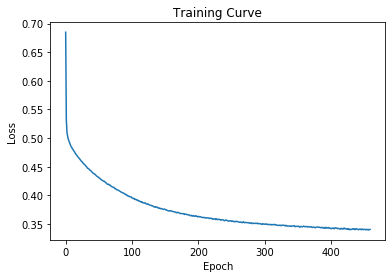

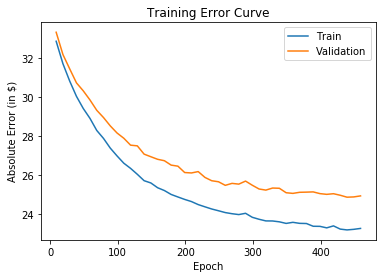

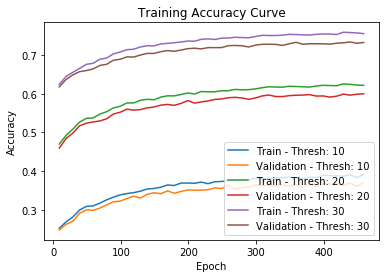

---[ITER 10] loss: 0.347804  time: 0.318
---[ITER 20] loss: 0.339117  time: 0.360
---[ITER 30] loss: 0.336176  time: 0.277
---[ITER 40] loss: 0.339598  time: 0.216
---[ITER 50] loss: 0.341926  time: 0.279
---[ITER 60] loss: 0.342505  time: 0.251
---[ITER 70] loss: 0.337068  time: 0.197
---[ITER 80] loss: 0.347991  time: 0.219
---[ITER 90] loss: 0.337302  time: 0.223
---[ITER 100] loss: 0.338800  time: 0.206
---[ITER 110] loss: 0.330702  time: 0.220
---[ITER 120] loss: 0.350996  time: 0.233
---[ITER 130] loss: 0.334717  time: 0.261
---[ITER 140] loss: 0.338433  time: 0.238
---[ITER 150] loss: 0.336940  time: 0.215
---[ITER 160] loss: 0.334212  time: 0.235
[EPOCH 461] loss: 0.339528  time: 4.121
---[ITER 10] loss: 0.341165  time: 0.298
---[ITER 20] loss: 0.342986  time: 0.328
---[ITER 30] loss: 0.338793  time: 0.202
---[ITER 40] loss: 0.340305  time: 0.167
---[ITER 50] loss: 0.340473  time: 0.170
---[ITER 60] loss: 0.335527  time: 0.197
---[ITER 70] loss: 0.340438  time: 0.186
---[ITER 8

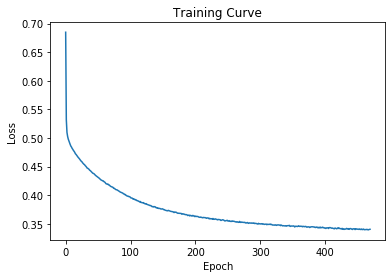

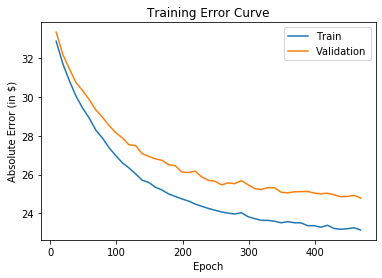

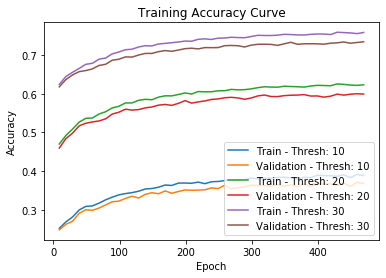

---[ITER 10] loss: 0.341134  time: 0.408
---[ITER 20] loss: 0.336664  time: 0.200
---[ITER 30] loss: 0.334238  time: 0.185
---[ITER 40] loss: 0.338479  time: 0.200
---[ITER 50] loss: 0.343136  time: 0.197
---[ITER 60] loss: 0.329281  time: 0.175
---[ITER 70] loss: 0.336535  time: 0.214
---[ITER 80] loss: 0.338739  time: 0.212
---[ITER 90] loss: 0.343145  time: 0.164
---[ITER 100] loss: 0.338962  time: 0.207
---[ITER 110] loss: 0.343994  time: 0.189
---[ITER 120] loss: 0.343153  time: 0.261
---[ITER 130] loss: 0.333925  time: 0.209
---[ITER 140] loss: 0.342143  time: 0.202
---[ITER 150] loss: 0.343979  time: 0.190
---[ITER 160] loss: 0.343760  time: 0.220
[EPOCH 471] loss: 0.339407  time: 3.587
---[ITER 10] loss: 0.336758  time: 0.428
---[ITER 20] loss: 0.339766  time: 0.194
---[ITER 30] loss: 0.340863  time: 0.192
---[ITER 40] loss: 0.335189  time: 0.177
---[ITER 50] loss: 0.339886  time: 0.221
---[ITER 60] loss: 0.336301  time: 0.183
---[ITER 70] loss: 0.343670  time: 0.182
---[ITER 8

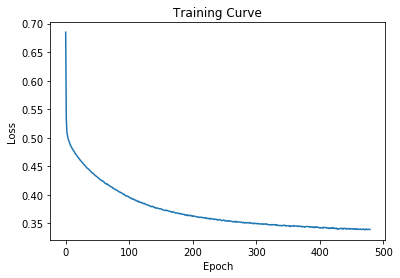

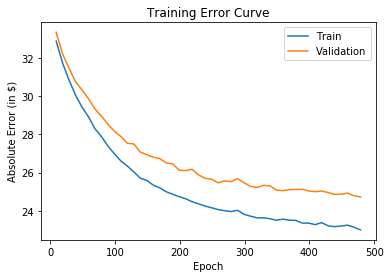

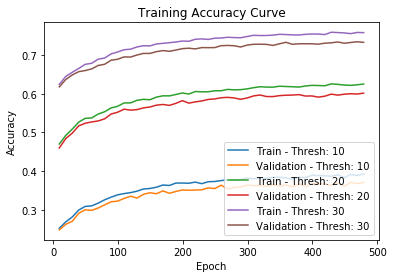

---[ITER 10] loss: 0.337193  time: 0.327
---[ITER 20] loss: 0.337442  time: 0.194
---[ITER 30] loss: 0.344132  time: 0.231
---[ITER 40] loss: 0.338420  time: 0.304
---[ITER 50] loss: 0.346471  time: 0.216
---[ITER 60] loss: 0.338416  time: 0.229
---[ITER 70] loss: 0.335184  time: 0.200
---[ITER 80] loss: 0.334071  time: 0.200
---[ITER 90] loss: 0.336416  time: 0.191
---[ITER 100] loss: 0.337218  time: 0.184
---[ITER 110] loss: 0.337590  time: 0.192
---[ITER 120] loss: 0.335673  time: 0.210
---[ITER 130] loss: 0.344653  time: 0.194
---[ITER 140] loss: 0.339230  time: 0.189
---[ITER 150] loss: 0.343485  time: 0.248
---[ITER 160] loss: 0.338554  time: 0.190
[EPOCH 481] loss: 0.339129  time: 3.678
---[ITER 10] loss: 0.331474  time: 0.287
---[ITER 20] loss: 0.342119  time: 0.189
---[ITER 30] loss: 0.337874  time: 0.187
---[ITER 40] loss: 0.334095  time: 0.316
---[ITER 50] loss: 0.338632  time: 0.187
---[ITER 60] loss: 0.341380  time: 0.191
---[ITER 70] loss: 0.340503  time: 0.204
---[ITER 8

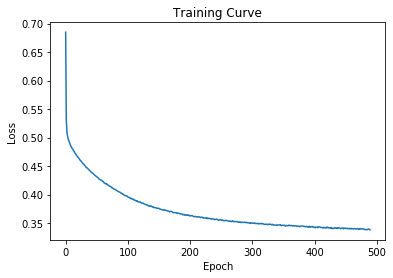

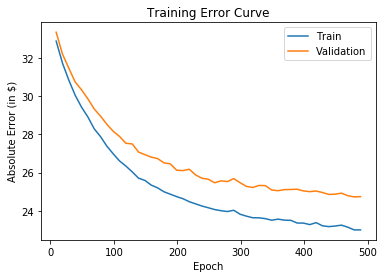

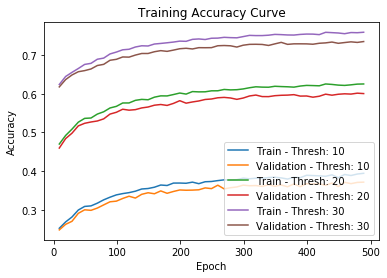

---[ITER 10] loss: 0.333588  time: 0.389
---[ITER 20] loss: 0.341528  time: 0.248
---[ITER 30] loss: 0.342942  time: 0.265
---[ITER 40] loss: 0.341269  time: 0.445
---[ITER 50] loss: 0.335739  time: 0.301
---[ITER 60] loss: 0.331612  time: 0.198
---[ITER 70] loss: 0.332130  time: 0.338
---[ITER 80] loss: 0.336566  time: 0.244
---[ITER 90] loss: 0.336661  time: 0.230
---[ITER 100] loss: 0.340482  time: 0.227
---[ITER 110] loss: 0.345520  time: 0.837
---[ITER 120] loss: 0.332627  time: 0.323
---[ITER 130] loss: 0.345297  time: 0.276
---[ITER 140] loss: 0.340869  time: 0.258
---[ITER 150] loss: 0.342564  time: 0.253
---[ITER 160] loss: 0.339615  time: 0.275
[EPOCH 491] loss: 0.338718  time: 5.404
---[ITER 10] loss: 0.343030  time: 0.368
---[ITER 20] loss: 0.342564  time: 0.331
---[ITER 30] loss: 0.341236  time: 0.369
---[ITER 40] loss: 0.339762  time: 0.222
---[ITER 50] loss: 0.346418  time: 0.250
---[ITER 60] loss: 0.330324  time: 0.236
---[ITER 70] loss: 0.336108  time: 0.244
---[ITER 8

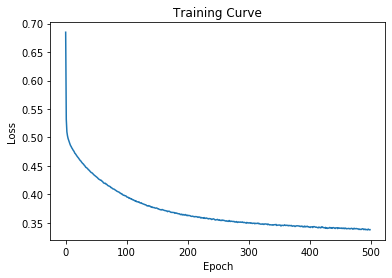

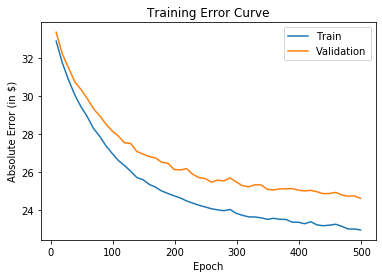

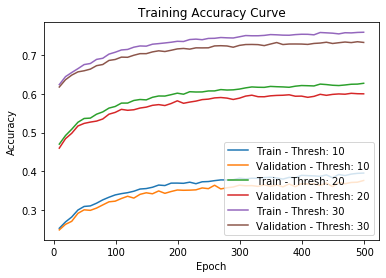

---[ITER 10] loss: 0.337752  time: 0.340
---[ITER 20] loss: 0.336819  time: 0.351
---[ITER 30] loss: 0.328647  time: 0.245
---[ITER 40] loss: 0.338603  time: 0.238
---[ITER 50] loss: 0.334805  time: 0.204
---[ITER 60] loss: 0.344493  time: 0.219
---[ITER 70] loss: 0.329646  time: 0.235
---[ITER 80] loss: 0.335702  time: 0.206
---[ITER 90] loss: 0.339755  time: 0.277
---[ITER 100] loss: 0.333683  time: 0.230
---[ITER 110] loss: 0.335862  time: 0.251
---[ITER 120] loss: 0.341233  time: 0.227
---[ITER 130] loss: 0.341566  time: 0.282
---[ITER 140] loss: 0.348355  time: 0.237
---[ITER 150] loss: 0.335190  time: 0.214
---[ITER 160] loss: 0.351906  time: 0.231
[EPOCH 501] loss: 0.338050  time: 4.206
---[ITER 10] loss: 0.335723  time: 0.314
---[ITER 20] loss: 0.341974  time: 0.365
---[ITER 30] loss: 0.342595  time: 0.252
---[ITER 40] loss: 0.342828  time: 0.234
---[ITER 50] loss: 0.341760  time: 0.249
---[ITER 60] loss: 0.333273  time: 0.247
---[ITER 70] loss: 0.333084  time: 0.257
---[ITER 8

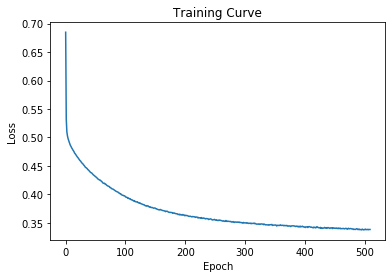

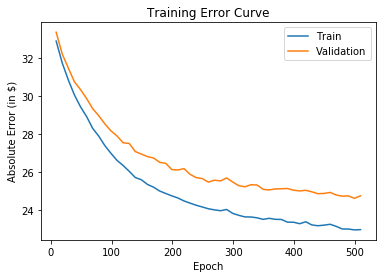

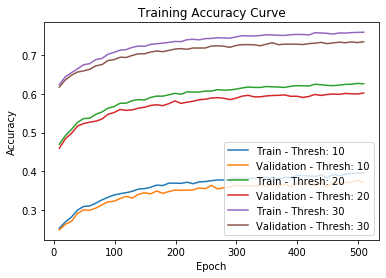

---[ITER 10] loss: 0.334260  time: 0.481
---[ITER 20] loss: 0.346057  time: 0.205
---[ITER 30] loss: 0.339374  time: 0.255
---[ITER 40] loss: 0.337499  time: 0.251
---[ITER 50] loss: 0.334619  time: 0.242
---[ITER 60] loss: 0.335046  time: 0.243
---[ITER 70] loss: 0.341482  time: 0.226
---[ITER 80] loss: 0.342377  time: 0.242
---[ITER 90] loss: 0.336557  time: 0.237
---[ITER 100] loss: 0.335960  time: 0.241
---[ITER 110] loss: 0.332878  time: 0.218
---[ITER 120] loss: 0.340647  time: 0.293
---[ITER 130] loss: 0.331697  time: 0.256
---[ITER 140] loss: 0.339284  time: 0.233
---[ITER 150] loss: 0.340277  time: 0.252
---[ITER 160] loss: 0.344014  time: 0.225
[EPOCH 511] loss: 0.338509  time: 4.306
---[ITER 10] loss: 0.337090  time: 0.444
---[ITER 20] loss: 0.333637  time: 0.227
---[ITER 30] loss: 0.337694  time: 0.211
---[ITER 40] loss: 0.332669  time: 0.245
---[ITER 50] loss: 0.340969  time: 0.220
---[ITER 60] loss: 0.339324  time: 0.232
---[ITER 70] loss: 0.338376  time: 0.248
---[ITER 8

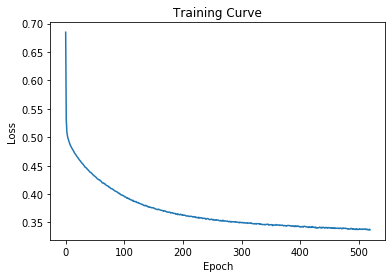

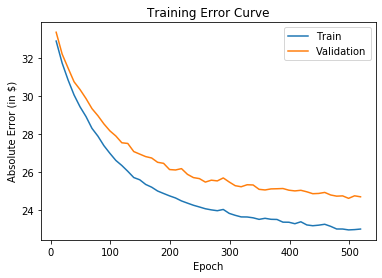

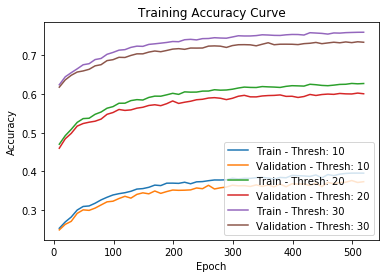

---[ITER 10] loss: 0.339566  time: 0.353
---[ITER 20] loss: 0.336370  time: 0.186
---[ITER 30] loss: 0.338350  time: 0.364
---[ITER 40] loss: 0.342578  time: 0.255
---[ITER 50] loss: 0.336414  time: 0.224
---[ITER 60] loss: 0.327106  time: 0.271
---[ITER 70] loss: 0.335965  time: 0.205
---[ITER 80] loss: 0.343235  time: 0.227
---[ITER 90] loss: 0.337869  time: 0.246
---[ITER 100] loss: 0.340906  time: 0.251
---[ITER 110] loss: 0.337454  time: 0.249
---[ITER 120] loss: 0.341102  time: 0.245
---[ITER 130] loss: 0.337421  time: 0.208
---[ITER 140] loss: 0.335334  time: 0.262
---[ITER 150] loss: 0.338518  time: 0.261
---[ITER 160] loss: 0.332268  time: 0.234
[EPOCH 521] loss: 0.337325  time: 4.224
---[ITER 10] loss: 0.332838  time: 0.312
---[ITER 20] loss: 0.335947  time: 0.174
---[ITER 30] loss: 0.340554  time: 0.336
---[ITER 40] loss: 0.329074  time: 0.255
---[ITER 50] loss: 0.341111  time: 0.249
---[ITER 60] loss: 0.338754  time: 0.234
---[ITER 70] loss: 0.341585  time: 0.253
---[ITER 8

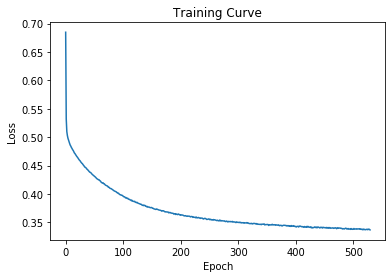

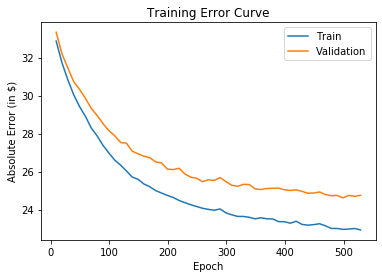

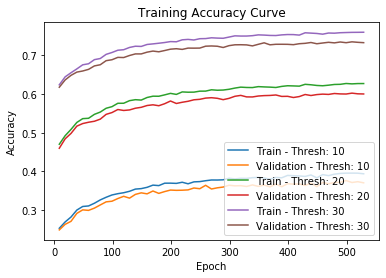

---[ITER 10] loss: 0.334232  time: 0.384
---[ITER 20] loss: 0.336027  time: 0.398
---[ITER 30] loss: 0.337926  time: 0.256
---[ITER 40] loss: 0.335871  time: 0.333
---[ITER 50] loss: 0.332898  time: 0.305
---[ITER 60] loss: 0.341893  time: 0.337
---[ITER 70] loss: 0.333685  time: 0.281
---[ITER 80] loss: 0.333421  time: 0.338
---[ITER 90] loss: 0.339054  time: 0.324
---[ITER 100] loss: 0.334954  time: 0.300
---[ITER 110] loss: 0.339222  time: 0.255
---[ITER 120] loss: 0.340891  time: 0.225
---[ITER 130] loss: 0.334883  time: 0.239
---[ITER 140] loss: 0.344007  time: 0.260
---[ITER 150] loss: 0.337043  time: 0.271
---[ITER 160] loss: 0.334970  time: 0.250
[EPOCH 531] loss: 0.336795  time: 4.941
---[ITER 10] loss: 0.341856  time: 0.327
---[ITER 20] loss: 0.343319  time: 0.373
---[ITER 30] loss: 0.329646  time: 0.242
---[ITER 40] loss: 0.332253  time: 0.246
---[ITER 50] loss: 0.342669  time: 0.234
---[ITER 60] loss: 0.329742  time: 0.209
---[ITER 70] loss: 0.335581  time: 0.218
---[ITER 8

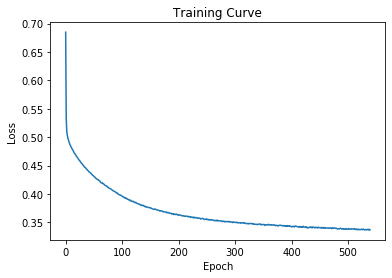

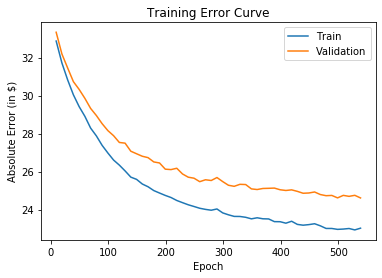

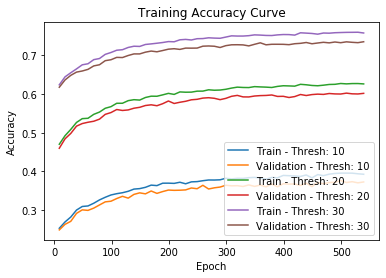

---[ITER 10] loss: 0.343491  time: 0.488
---[ITER 20] loss: 0.336123  time: 0.243
---[ITER 30] loss: 0.333613  time: 0.227
---[ITER 40] loss: 0.332839  time: 0.221
---[ITER 50] loss: 0.342467  time: 0.230
---[ITER 60] loss: 0.337739  time: 0.240
---[ITER 70] loss: 0.334983  time: 0.198
---[ITER 80] loss: 0.339825  time: 0.228
---[ITER 90] loss: 0.332600  time: 0.205
---[ITER 100] loss: 0.336328  time: 0.473
---[ITER 110] loss: 0.336649  time: 0.333
---[ITER 120] loss: 0.336705  time: 0.241
---[ITER 130] loss: 0.336426  time: 0.314
---[ITER 140] loss: 0.335632  time: 0.292
---[ITER 150] loss: 0.342790  time: 0.295
---[ITER 160] loss: 0.335959  time: 0.693
[EPOCH 541] loss: 0.337509  time: 5.560
---[ITER 10] loss: 0.338083  time: 0.593
---[ITER 20] loss: 0.338946  time: 0.329
---[ITER 30] loss: 0.335404  time: 0.306
---[ITER 40] loss: 0.347255  time: 0.348
---[ITER 50] loss: 0.329604  time: 0.346
---[ITER 60] loss: 0.339877  time: 0.317
---[ITER 70] loss: 0.333582  time: 0.302
---[ITER 8

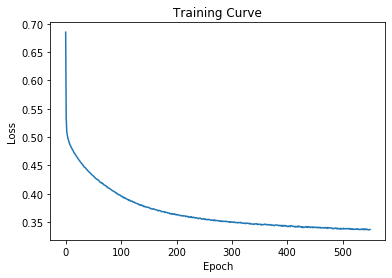

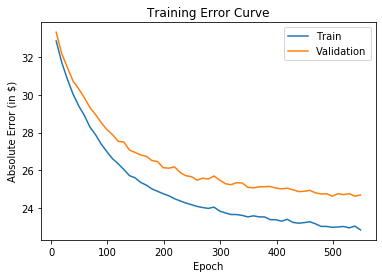

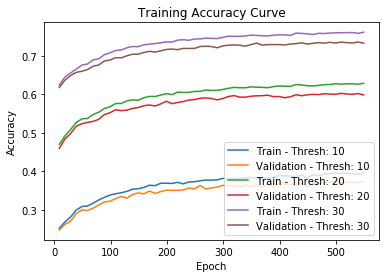

---[ITER 10] loss: 0.339050  time: 0.484
---[ITER 20] loss: 0.338171  time: 0.269
---[ITER 30] loss: 0.329721  time: 0.226
---[ITER 40] loss: 0.332334  time: 0.211
---[ITER 50] loss: 0.341842  time: 0.235
---[ITER 60] loss: 0.333619  time: 0.215
---[ITER 70] loss: 0.334730  time: 0.236
---[ITER 80] loss: 0.336684  time: 0.222
---[ITER 90] loss: 0.339389  time: 0.196
---[ITER 100] loss: 0.336752  time: 0.241
---[ITER 110] loss: 0.338903  time: 0.210
---[ITER 120] loss: 0.333949  time: 0.257
---[ITER 130] loss: 0.341311  time: 0.231
---[ITER 140] loss: 0.337860  time: 0.219
---[ITER 150] loss: 0.334685  time: 0.226
---[ITER 160] loss: 0.331516  time: 0.222
[EPOCH 551] loss: 0.336631  time: 4.065
---[ITER 10] loss: 0.337680  time: 0.441
---[ITER 20] loss: 0.338048  time: 0.194
---[ITER 30] loss: 0.334262  time: 0.210
---[ITER 40] loss: 0.340409  time: 0.213
---[ITER 50] loss: 0.342264  time: 0.220
---[ITER 60] loss: 0.339950  time: 0.208
---[ITER 70] loss: 0.333206  time: 0.194
---[ITER 8

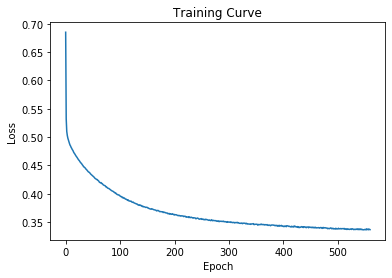

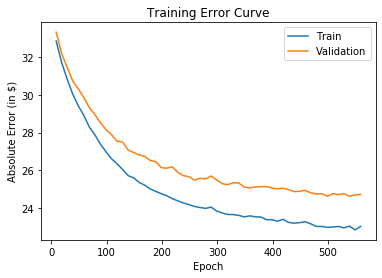

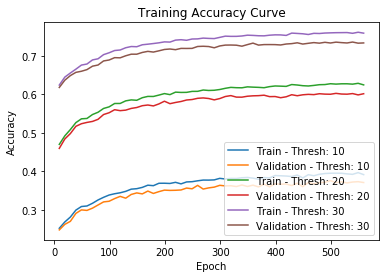

---[ITER 10] loss: 0.330912  time: 0.351
---[ITER 20] loss: 0.337784  time: 0.219
---[ITER 30] loss: 0.333693  time: 0.335
---[ITER 40] loss: 0.342831  time: 0.266
---[ITER 50] loss: 0.338828  time: 0.203
---[ITER 60] loss: 0.332428  time: 0.269
---[ITER 70] loss: 0.330830  time: 0.220
---[ITER 80] loss: 0.335720  time: 0.230
---[ITER 90] loss: 0.337279  time: 0.193
---[ITER 100] loss: 0.336885  time: 0.177
---[ITER 110] loss: 0.338183  time: 0.257
---[ITER 120] loss: 0.339872  time: 0.229
---[ITER 130] loss: 0.339008  time: 0.264
---[ITER 140] loss: 0.337491  time: 0.254
---[ITER 150] loss: 0.341836  time: 0.241
---[ITER 160] loss: 0.335554  time: 0.224
[EPOCH 561] loss: 0.336437  time: 4.143
---[ITER 10] loss: 0.338753  time: 0.305
---[ITER 20] loss: 0.339582  time: 0.213
---[ITER 30] loss: 0.338800  time: 0.342
---[ITER 40] loss: 0.337644  time: 0.213
---[ITER 50] loss: 0.332026  time: 0.229
---[ITER 60] loss: 0.328904  time: 0.229
---[ITER 70] loss: 0.346169  time: 0.222
---[ITER 8

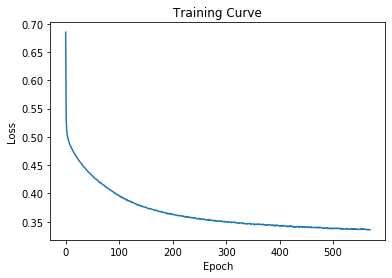

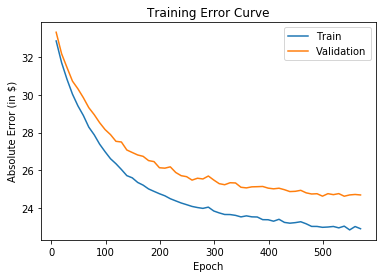

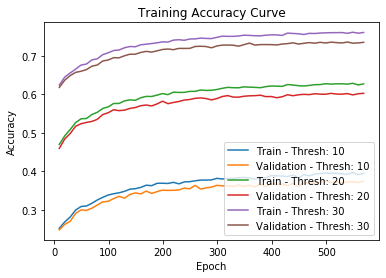

---[ITER 10] loss: 0.334375  time: 0.330
---[ITER 20] loss: 0.342232  time: 0.340
---[ITER 30] loss: 0.328583  time: 0.250
---[ITER 40] loss: 0.329754  time: 0.254
---[ITER 50] loss: 0.341463  time: 0.245
---[ITER 60] loss: 0.337352  time: 0.237
---[ITER 70] loss: 0.338460  time: 0.257
---[ITER 80] loss: 0.335807  time: 0.246
---[ITER 90] loss: 0.329872  time: 0.249
---[ITER 100] loss: 0.334947  time: 0.264
---[ITER 110] loss: 0.338065  time: 0.237
---[ITER 120] loss: 0.329885  time: 0.231
---[ITER 130] loss: 0.333236  time: 0.217
---[ITER 140] loss: 0.340385  time: 0.237
---[ITER 150] loss: 0.338657  time: 0.217
---[ITER 160] loss: 0.338407  time: 0.186
[EPOCH 571] loss: 0.335798  time: 4.166
---[ITER 10] loss: 0.330430  time: 0.302
---[ITER 20] loss: 0.340574  time: 0.333
---[ITER 30] loss: 0.338257  time: 0.217
---[ITER 40] loss: 0.336804  time: 0.237
---[ITER 50] loss: 0.333251  time: 0.218
---[ITER 60] loss: 0.332785  time: 0.217
---[ITER 70] loss: 0.332590  time: 0.232
---[ITER 8

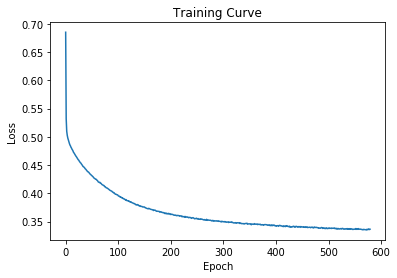

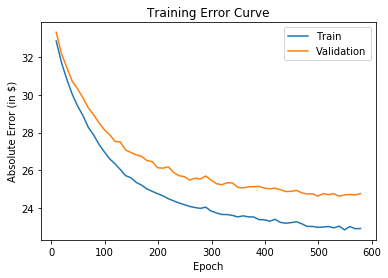

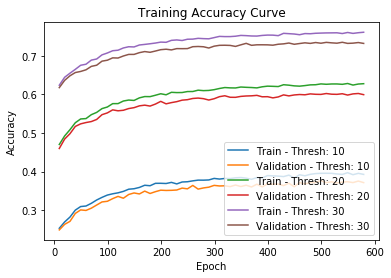

---[ITER 10] loss: 0.329442  time: 0.461
---[ITER 20] loss: 0.334430  time: 0.233
---[ITER 30] loss: 0.337309  time: 0.280
---[ITER 40] loss: 0.330218  time: 0.261
---[ITER 50] loss: 0.335002  time: 0.252
---[ITER 60] loss: 0.337328  time: 0.253
---[ITER 70] loss: 0.339064  time: 0.251
---[ITER 80] loss: 0.340501  time: 0.231
---[ITER 90] loss: 0.333298  time: 0.237
---[ITER 100] loss: 0.334452  time: 0.253
---[ITER 110] loss: 0.341589  time: 0.250
---[ITER 120] loss: 0.338005  time: 0.215
---[ITER 130] loss: 0.340424  time: 0.349
---[ITER 140] loss: 0.334741  time: 0.256
---[ITER 150] loss: 0.340458  time: 0.230
---[ITER 160] loss: 0.334991  time: 0.218
[EPOCH 581] loss: 0.336490  time: 4.441
---[ITER 10] loss: 0.334653  time: 0.438
---[ITER 20] loss: 0.336456  time: 0.243
---[ITER 30] loss: 0.335713  time: 0.234
---[ITER 40] loss: 0.332082  time: 0.242
---[ITER 50] loss: 0.336725  time: 0.238
---[ITER 60] loss: 0.338616  time: 0.246
---[ITER 70] loss: 0.346699  time: 0.224
---[ITER 8

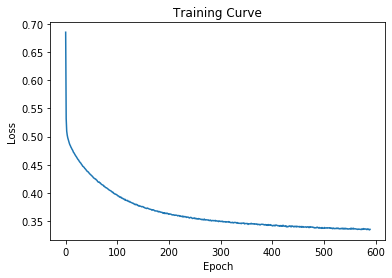

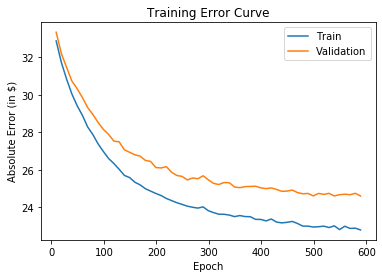

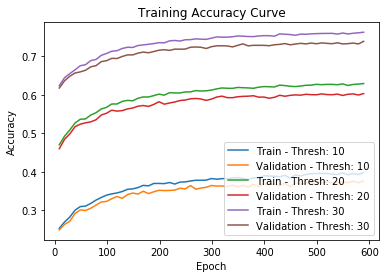

---[ITER 10] loss: 0.338131  time: 0.336
---[ITER 20] loss: 0.332125  time: 0.252
---[ITER 30] loss: 0.336971  time: 0.253
---[ITER 40] loss: 0.336761  time: 0.383
---[ITER 50] loss: 0.339450  time: 0.260
---[ITER 60] loss: 0.332975  time: 0.240
---[ITER 70] loss: 0.333389  time: 0.218
---[ITER 80] loss: 0.339440  time: 0.230
---[ITER 90] loss: 0.328977  time: 0.222
---[ITER 100] loss: 0.334742  time: 0.250
---[ITER 110] loss: 0.337608  time: 0.227
---[ITER 120] loss: 0.342542  time: 0.223
---[ITER 130] loss: 0.333045  time: 0.223
---[ITER 140] loss: 0.332939  time: 0.252
---[ITER 150] loss: 0.337623  time: 0.265
---[ITER 160] loss: 0.337697  time: 0.241
[EPOCH 591] loss: 0.336134  time: 4.215
---[ITER 10] loss: 0.338758  time: 0.369
---[ITER 20] loss: 0.329051  time: 0.237
---[ITER 30] loss: 0.337799  time: 0.269
---[ITER 40] loss: 0.332163  time: 0.312
---[ITER 50] loss: 0.335177  time: 0.228
---[ITER 60] loss: 0.337756  time: 0.239
---[ITER 70] loss: 0.335932  time: 0.225
---[ITER 8

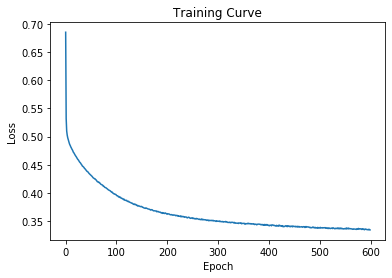

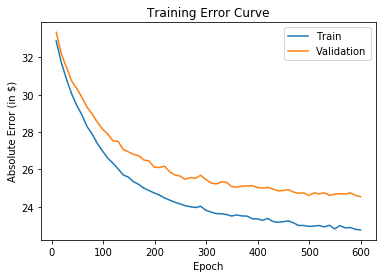

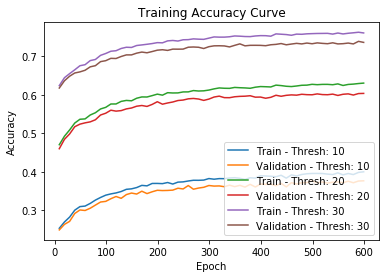

---[ITER 10] loss: 0.337791  time: 0.327
---[ITER 20] loss: 0.341487  time: 0.279
---[ITER 30] loss: 0.335262  time: 0.304
---[ITER 40] loss: 0.331521  time: 0.249
---[ITER 50] loss: 0.334573  time: 0.238
---[ITER 60] loss: 0.340430  time: 0.213
---[ITER 70] loss: 0.338522  time: 0.240
---[ITER 80] loss: 0.334583  time: 0.223
---[ITER 90] loss: 0.330129  time: 0.243
---[ITER 100] loss: 0.330798  time: 0.251
---[ITER 110] loss: 0.338287  time: 0.244
---[ITER 120] loss: 0.340073  time: 0.244
---[ITER 130] loss: 0.338384  time: 0.236
---[ITER 140] loss: 0.329823  time: 0.253
---[ITER 150] loss: 0.332197  time: 0.265
---[ITER 160] loss: 0.328539  time: 0.210
[EPOCH 601] loss: 0.335107  time: 4.194
---[ITER 10] loss: 0.331976  time: 0.327
---[ITER 20] loss: 0.341235  time: 0.192
---[ITER 30] loss: 0.334095  time: 0.356
---[ITER 40] loss: 0.329821  time: 0.244
---[ITER 50] loss: 0.336391  time: 0.239
---[ITER 60] loss: 0.342458  time: 0.245
---[ITER 70] loss: 0.326177  time: 0.267
---[ITER 8

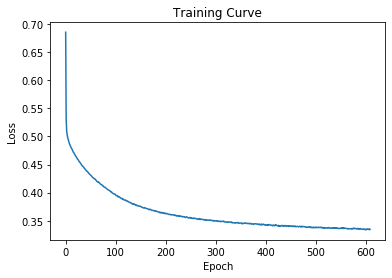

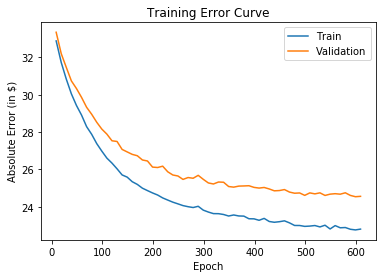

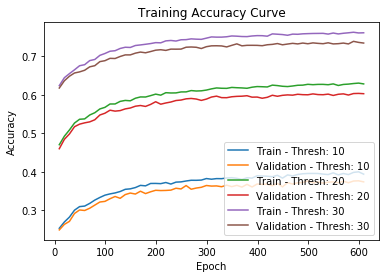

---[ITER 10] loss: 0.329514  time: 0.345
---[ITER 20] loss: 0.331481  time: 0.354
---[ITER 30] loss: 0.331624  time: 0.238
---[ITER 40] loss: 0.334102  time: 0.255
---[ITER 50] loss: 0.339955  time: 0.255
---[ITER 60] loss: 0.329612  time: 0.279
---[ITER 70] loss: 0.339215  time: 0.258
---[ITER 80] loss: 0.335058  time: 0.216
---[ITER 90] loss: 0.330935  time: 0.225
---[ITER 100] loss: 0.333857  time: 0.254
---[ITER 110] loss: 0.335217  time: 0.247
---[ITER 120] loss: 0.335623  time: 0.257
---[ITER 130] loss: 0.337334  time: 0.290
---[ITER 140] loss: 0.334698  time: 0.247
---[ITER 150] loss: 0.334840  time: 0.255
---[ITER 160] loss: 0.337958  time: 0.265
[EPOCH 611] loss: 0.334447  time: 4.442
---[ITER 10] loss: 0.333684  time: 0.353
---[ITER 20] loss: 0.340417  time: 0.382
---[ITER 30] loss: 0.330801  time: 0.257
---[ITER 40] loss: 0.340627  time: 0.250
---[ITER 50] loss: 0.334163  time: 0.217
---[ITER 60] loss: 0.334179  time: 0.270
---[ITER 70] loss: 0.333820  time: 0.232
---[ITER 8

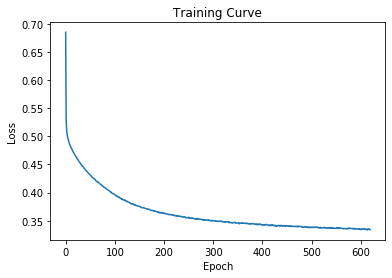

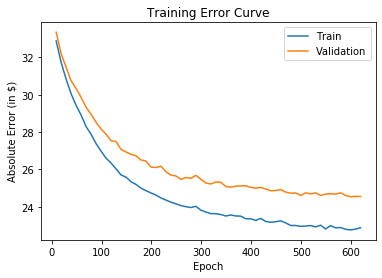

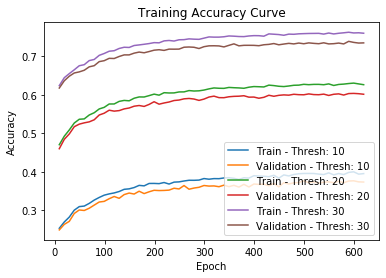

---[ITER 10] loss: 0.332959  time: 0.476
---[ITER 20] loss: 0.335473  time: 0.227
---[ITER 30] loss: 0.338222  time: 0.227
---[ITER 40] loss: 0.328421  time: 0.218
---[ITER 50] loss: 0.332139  time: 0.253
---[ITER 60] loss: 0.330516  time: 0.231
---[ITER 70] loss: 0.331381  time: 0.233
---[ITER 80] loss: 0.332372  time: 0.223
---[ITER 90] loss: 0.332722  time: 0.190
---[ITER 100] loss: 0.335220  time: 0.253
---[ITER 110] loss: 0.331360  time: 0.204
---[ITER 120] loss: 0.339717  time: 0.296
---[ITER 130] loss: 0.335675  time: 0.241
---[ITER 140] loss: 0.330986  time: 0.251
---[ITER 150] loss: 0.334869  time: 0.257
---[ITER 160] loss: 0.332052  time: 0.246
[EPOCH 621] loss: 0.333416  time: 4.217
---[ITER 10] loss: 0.333585  time: 0.460
---[ITER 20] loss: 0.334202  time: 0.247
---[ITER 30] loss: 0.325198  time: 0.250
---[ITER 40] loss: 0.339303  time: 0.264
---[ITER 50] loss: 0.332626  time: 0.234
---[ITER 60] loss: 0.329273  time: 0.259
---[ITER 70] loss: 0.335504  time: 0.255
---[ITER 8

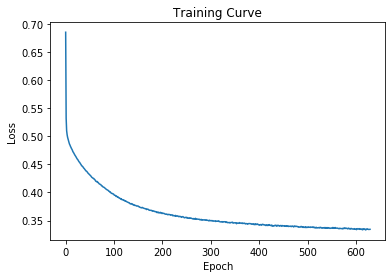

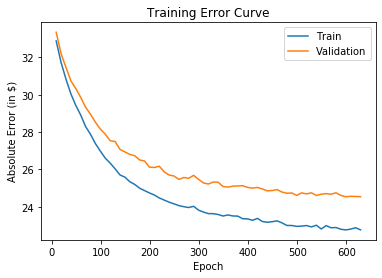

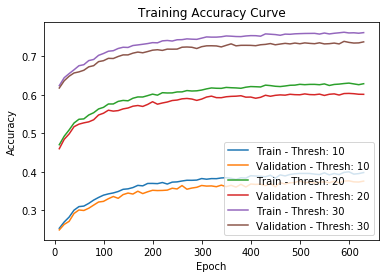

---[ITER 10] loss: 0.330978  time: 0.370
---[ITER 20] loss: 0.338474  time: 0.250
---[ITER 30] loss: 0.340148  time: 0.369
---[ITER 40] loss: 0.335572  time: 0.301
---[ITER 50] loss: 0.331422  time: 0.251
---[ITER 60] loss: 0.341568  time: 0.288
---[ITER 70] loss: 0.326945  time: 0.252
---[ITER 80] loss: 0.332919  time: 0.257
---[ITER 90] loss: 0.334434  time: 0.247
---[ITER 100] loss: 0.333304  time: 0.251
---[ITER 110] loss: 0.331551  time: 0.244
---[ITER 120] loss: 0.342355  time: 0.297
---[ITER 130] loss: 0.333505  time: 0.247
---[ITER 140] loss: 0.335910  time: 0.246
---[ITER 150] loss: 0.330541  time: 0.257
---[ITER 160] loss: 0.338031  time: 0.245
[EPOCH 631] loss: 0.334931  time: 4.574
---[ITER 10] loss: 0.329911  time: 0.367
---[ITER 20] loss: 0.335696  time: 0.242
---[ITER 30] loss: 0.332488  time: 0.345
---[ITER 40] loss: 0.330232  time: 0.204
---[ITER 50] loss: 0.341062  time: 0.185
---[ITER 60] loss: 0.338064  time: 0.232
---[ITER 70] loss: 0.334084  time: 0.224
---[ITER 8

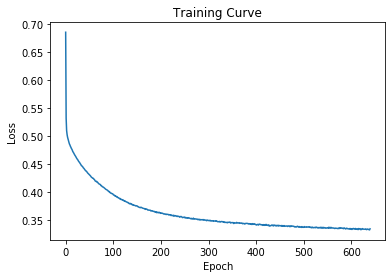

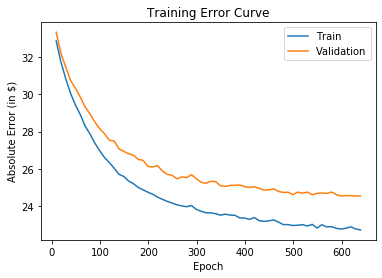

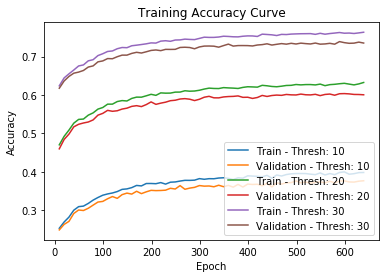

---[ITER 10] loss: 0.333885  time: 0.386
---[ITER 20] loss: 0.336254  time: 0.359
---[ITER 30] loss: 0.336282  time: 0.284
---[ITER 40] loss: 0.333569  time: 0.268
---[ITER 50] loss: 0.332627  time: 0.279
---[ITER 60] loss: 0.327890  time: 0.265
---[ITER 70] loss: 0.332881  time: 0.241
---[ITER 80] loss: 0.339776  time: 0.214
---[ITER 90] loss: 0.330740  time: 0.247
---[ITER 100] loss: 0.330675  time: 0.231
---[ITER 110] loss: 0.337119  time: 0.246
---[ITER 120] loss: 0.327490  time: 0.226
---[ITER 130] loss: 0.330473  time: 0.230
---[ITER 140] loss: 0.332463  time: 0.290
---[ITER 150] loss: 0.333972  time: 0.260
---[ITER 160] loss: 0.329186  time: 0.244
[EPOCH 641] loss: 0.332675  time: 4.460
---[ITER 10] loss: 0.334250  time: 0.341
---[ITER 20] loss: 0.325739  time: 0.370
---[ITER 30] loss: 0.331847  time: 0.255
---[ITER 40] loss: 0.330350  time: 0.259
---[ITER 50] loss: 0.337214  time: 0.258
---[ITER 60] loss: 0.331276  time: 0.246
---[ITER 70] loss: 0.334469  time: 0.238
---[ITER 8

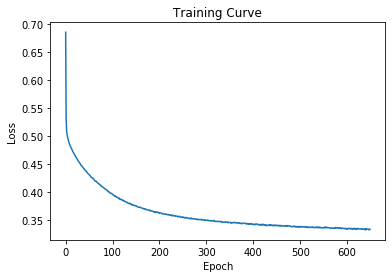

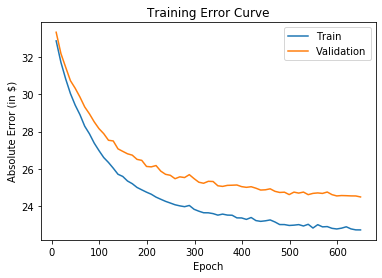

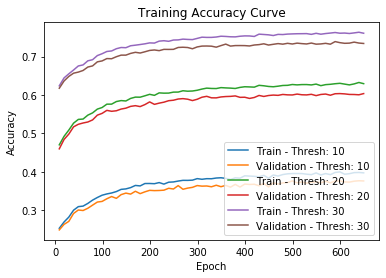

---[ITER 10] loss: 0.330747  time: 0.496
---[ITER 20] loss: 0.331908  time: 0.244
---[ITER 30] loss: 0.330881  time: 0.259
---[ITER 40] loss: 0.332834  time: 0.249
---[ITER 50] loss: 0.346618  time: 0.297
---[ITER 60] loss: 0.339379  time: 0.288
---[ITER 70] loss: 0.332040  time: 0.252
---[ITER 80] loss: 0.334068  time: 0.229
---[ITER 90] loss: 0.332390  time: 0.265
---[ITER 100] loss: 0.340678  time: 0.270
---[ITER 110] loss: 0.332436  time: 0.256
---[ITER 120] loss: 0.335525  time: 0.212
---[ITER 130] loss: 0.331338  time: 0.260
---[ITER 140] loss: 0.329404  time: 0.209
---[ITER 150] loss: 0.333329  time: 0.205
---[ITER 160] loss: 0.334712  time: 0.182
[EPOCH 651] loss: 0.334306  time: 4.359
---[ITER 10] loss: 0.332125  time: 0.447
---[ITER 20] loss: 0.331889  time: 0.240
---[ITER 30] loss: 0.331665  time: 0.231
---[ITER 40] loss: 0.334667  time: 0.227
---[ITER 50] loss: 0.337446  time: 0.213
---[ITER 60] loss: 0.335219  time: 0.264
---[ITER 70] loss: 0.337005  time: 0.212
---[ITER 8

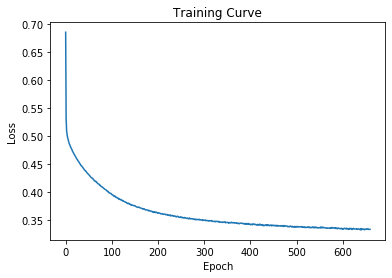

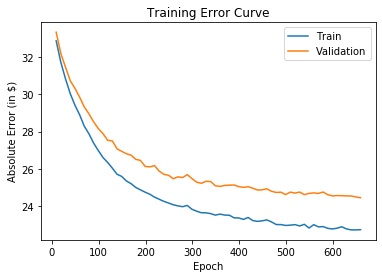

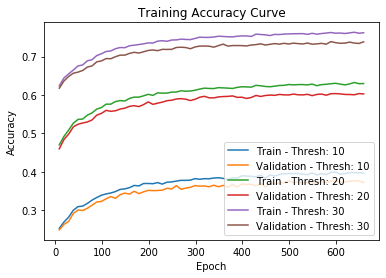

---[ITER 10] loss: 0.333280  time: 0.470
---[ITER 20] loss: 0.330712  time: 0.204
---[ITER 30] loss: 0.338999  time: 0.214
---[ITER 40] loss: 0.329388  time: 0.222
---[ITER 50] loss: 0.331697  time: 0.220
---[ITER 60] loss: 0.339074  time: 0.243
---[ITER 70] loss: 0.339280  time: 0.195
---[ITER 80] loss: 0.336351  time: 0.220
---[ITER 90] loss: 0.332020  time: 0.213
---[ITER 100] loss: 0.325474  time: 0.216
---[ITER 110] loss: 0.341052  time: 0.216
---[ITER 120] loss: 0.330254  time: 0.247
---[ITER 130] loss: 0.328636  time: 0.200
---[ITER 140] loss: 0.330294  time: 0.207
---[ITER 150] loss: 0.333700  time: 0.223
---[ITER 160] loss: 0.331695  time: 0.171
[EPOCH 661] loss: 0.333515  time: 3.861
---[ITER 10] loss: 0.339406  time: 0.440
---[ITER 20] loss: 0.333332  time: 0.236
---[ITER 30] loss: 0.334470  time: 0.192
---[ITER 40] loss: 0.336858  time: 0.200
---[ITER 50] loss: 0.332642  time: 0.213
---[ITER 60] loss: 0.328923  time: 0.237
---[ITER 70] loss: 0.327986  time: 0.236
---[ITER 8

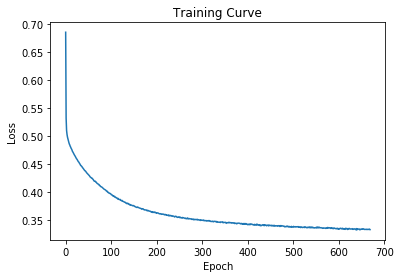

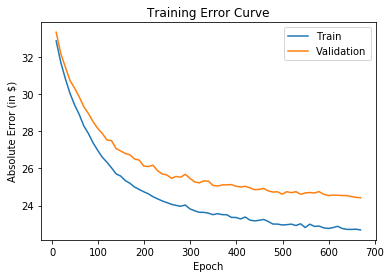

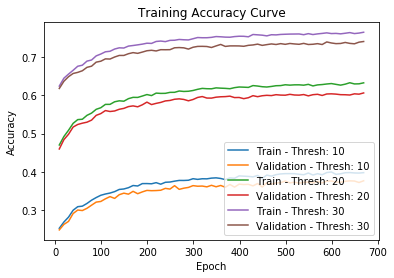

---[ITER 10] loss: 0.333461  time: 0.330
---[ITER 20] loss: 0.337139  time: 0.244
---[ITER 30] loss: 0.329000  time: 0.317
---[ITER 40] loss: 0.333148  time: 0.229
---[ITER 50] loss: 0.328237  time: 0.253
---[ITER 60] loss: 0.334384  time: 0.238
---[ITER 70] loss: 0.323387  time: 0.216
---[ITER 80] loss: 0.342337  time: 0.284
---[ITER 90] loss: 0.328597  time: 0.219
---[ITER 100] loss: 0.338448  time: 0.209
---[ITER 110] loss: 0.333208  time: 0.181
---[ITER 120] loss: 0.330577  time: 0.256
---[ITER 130] loss: 0.326061  time: 0.230
---[ITER 140] loss: 0.340540  time: 0.277
---[ITER 150] loss: 0.333137  time: 0.352
---[ITER 160] loss: 0.336209  time: 0.341
[EPOCH 671] loss: 0.333192  time: 4.417
---[ITER 10] loss: 0.340535  time: 0.333
---[ITER 20] loss: 0.332803  time: 0.230
---[ITER 30] loss: 0.331542  time: 0.365
---[ITER 40] loss: 0.338538  time: 0.230
---[ITER 50] loss: 0.339245  time: 0.211
---[ITER 60] loss: 0.326875  time: 0.211
---[ITER 70] loss: 0.340757  time: 0.236
---[ITER 8

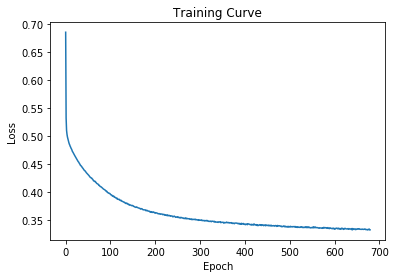

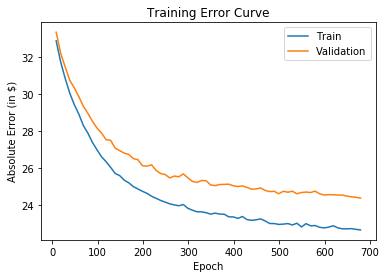

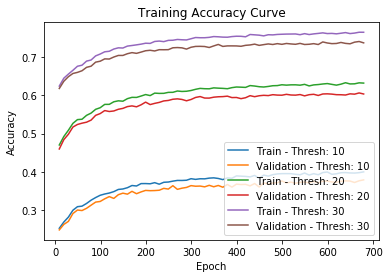

---[ITER 10] loss: 0.329826  time: 0.326
---[ITER 20] loss: 0.332017  time: 0.353
---[ITER 30] loss: 0.329658  time: 0.230
---[ITER 40] loss: 0.333577  time: 0.247
---[ITER 50] loss: 0.333314  time: 0.192
---[ITER 60] loss: 0.333471  time: 0.270
---[ITER 70] loss: 0.334051  time: 0.213
---[ITER 80] loss: 0.328588  time: 0.222
---[ITER 90] loss: 0.331244  time: 0.217
---[ITER 100] loss: 0.337059  time: 0.262
---[ITER 110] loss: 0.338749  time: 0.220
---[ITER 120] loss: 0.333271  time: 0.247
---[ITER 130] loss: 0.329883  time: 0.236
---[ITER 140] loss: 0.340490  time: 0.249
---[ITER 150] loss: 0.330465  time: 0.180
---[ITER 160] loss: 0.334603  time: 0.214
[EPOCH 681] loss: 0.332836  time: 4.066
---[ITER 10] loss: 0.326319  time: 0.318
---[ITER 20] loss: 0.333002  time: 0.366
---[ITER 30] loss: 0.329322  time: 0.202
---[ITER 40] loss: 0.329662  time: 0.201
---[ITER 50] loss: 0.326705  time: 0.185
---[ITER 60] loss: 0.332757  time: 0.249
---[ITER 70] loss: 0.330855  time: 0.219
---[ITER 8

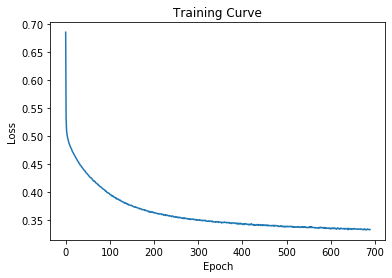

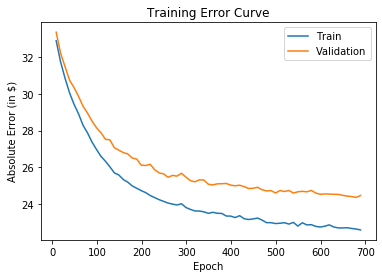

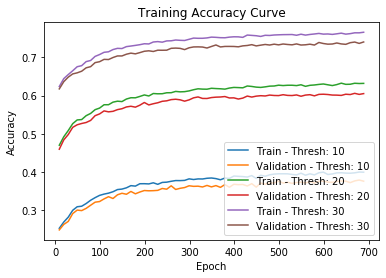

---[ITER 10] loss: 0.331640  time: 0.437
---[ITER 20] loss: 0.328345  time: 0.210
---[ITER 30] loss: 0.332998  time: 0.223
---[ITER 40] loss: 0.331311  time: 0.200
---[ITER 50] loss: 0.329894  time: 0.185
---[ITER 60] loss: 0.334844  time: 0.223
---[ITER 70] loss: 0.340094  time: 0.206
---[ITER 80] loss: 0.328374  time: 0.248
---[ITER 90] loss: 0.333445  time: 0.221
---[ITER 100] loss: 0.334572  time: 0.199
---[ITER 110] loss: 0.327157  time: 0.204
---[ITER 120] loss: 0.335751  time: 0.192
---[ITER 130] loss: 0.331676  time: 0.250
---[ITER 140] loss: 0.327215  time: 0.235
---[ITER 150] loss: 0.336577  time: 0.206
---[ITER 160] loss: 0.339342  time: 0.213
[EPOCH 691] loss: 0.332583  time: 3.813
---[ITER 10] loss: 0.335272  time: 0.447
---[ITER 20] loss: 0.332249  time: 0.195
---[ITER 30] loss: 0.337956  time: 0.221
---[ITER 40] loss: 0.331426  time: 0.231
---[ITER 50] loss: 0.328179  time: 0.174
---[ITER 60] loss: 0.329699  time: 0.239
---[ITER 70] loss: 0.336837  time: 0.217
---[ITER 8

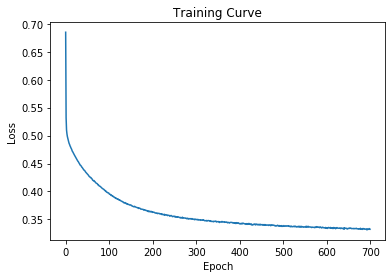

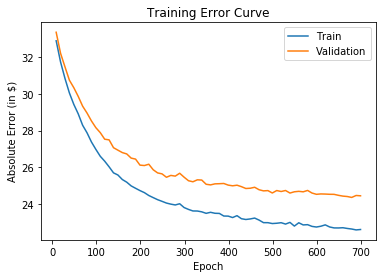

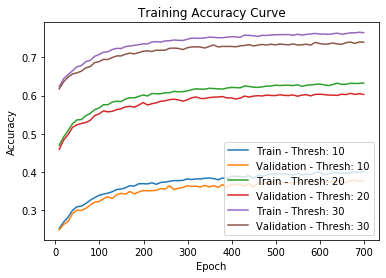

---[ITER 10] loss: 0.331526  time: 0.451
---[ITER 20] loss: 0.330885  time: 0.214
---[ITER 30] loss: 0.330126  time: 0.219
---[ITER 40] loss: 0.334882  time: 0.321
---[ITER 50] loss: 0.337205  time: 0.212
---[ITER 60] loss: 0.328276  time: 0.224
---[ITER 70] loss: 0.336647  time: 0.229
---[ITER 80] loss: 0.331149  time: 0.202
---[ITER 90] loss: 0.333994  time: 0.224
---[ITER 100] loss: 0.337245  time: 0.201
---[ITER 110] loss: 0.339917  time: 0.273
---[ITER 120] loss: 0.329808  time: 0.227
---[ITER 130] loss: 0.335160  time: 0.223
---[ITER 140] loss: 0.328956  time: 0.252
---[ITER 150] loss: 0.332892  time: 0.223
---[ITER 160] loss: 0.330585  time: 0.240
[EPOCH 701] loss: 0.333029  time: 4.098
---[ITER 10] loss: 0.331318  time: 0.340
---[ITER 20] loss: 0.334933  time: 0.223
---[ITER 30] loss: 0.330459  time: 0.207
---[ITER 40] loss: 0.333534  time: 0.479
---[ITER 50] loss: 0.339056  time: 0.299
---[ITER 60] loss: 0.332886  time: 0.256
---[ITER 70] loss: 0.328023  time: 0.219
---[ITER 8

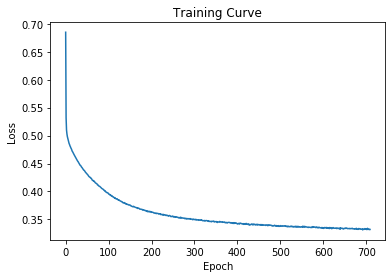

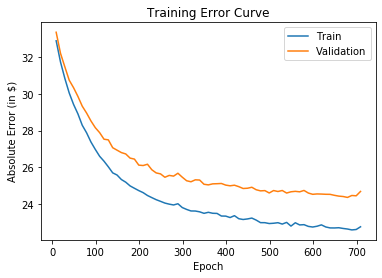

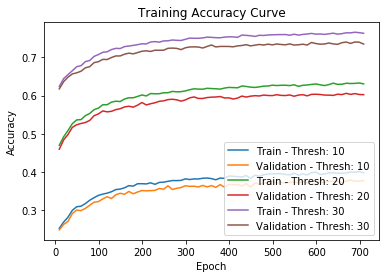

---[ITER 10] loss: 0.336372  time: 0.344
---[ITER 20] loss: 0.329315  time: 0.262
---[ITER 30] loss: 0.329839  time: 0.288
---[ITER 40] loss: 0.332879  time: 0.210
---[ITER 50] loss: 0.332584  time: 0.241
---[ITER 60] loss: 0.330885  time: 0.171
---[ITER 70] loss: 0.336561  time: 0.192
---[ITER 80] loss: 0.326740  time: 0.212
---[ITER 90] loss: 0.338879  time: 0.198
---[ITER 100] loss: 0.333405  time: 0.201
---[ITER 110] loss: 0.342675  time: 0.182
---[ITER 120] loss: 0.332257  time: 0.218
---[ITER 130] loss: 0.334412  time: 0.187
---[ITER 140] loss: 0.339192  time: 0.211
---[ITER 150] loss: 0.328668  time: 0.229
---[ITER 160] loss: 0.330832  time: 0.208
[EPOCH 711] loss: 0.333359  time: 3.728
---[ITER 10] loss: 0.337147  time: 0.255
---[ITER 20] loss: 0.336464  time: 0.200
---[ITER 30] loss: 0.334089  time: 0.345
---[ITER 40] loss: 0.331910  time: 0.196
---[ITER 50] loss: 0.335514  time: 0.212
---[ITER 60] loss: 0.331096  time: 0.185
---[ITER 70] loss: 0.328416  time: 0.199
---[ITER 8

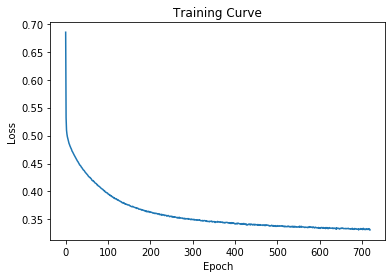

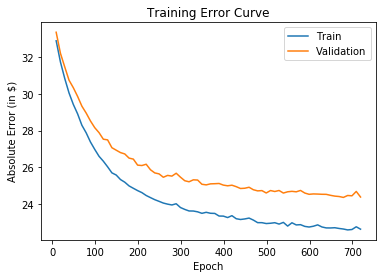

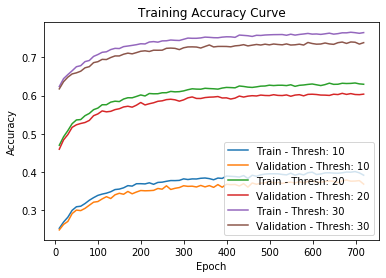

---[ITER 10] loss: 0.329240  time: 0.398
---[ITER 20] loss: 0.333554  time: 0.372
---[ITER 30] loss: 0.333335  time: 0.270
---[ITER 40] loss: 0.332388  time: 0.192
---[ITER 50] loss: 0.334750  time: 0.226
---[ITER 60] loss: 0.325140  time: 0.307
---[ITER 70] loss: 0.333693  time: 0.204
---[ITER 80] loss: 0.332946  time: 0.189
---[ITER 90] loss: 0.333412  time: 0.211
---[ITER 100] loss: 0.331265  time: 0.197
---[ITER 110] loss: 0.337641  time: 0.198
---[ITER 120] loss: 0.333774  time: 0.218
---[ITER 130] loss: 0.332609  time: 0.219
---[ITER 140] loss: 0.332679  time: 0.216
---[ITER 150] loss: 0.322441  time: 0.197
---[ITER 160] loss: 0.334455  time: 0.231
[EPOCH 721] loss: 0.331761  time: 3.994
---[ITER 10] loss: 0.327371  time: 0.289
---[ITER 20] loss: 0.332659  time: 0.329
---[ITER 30] loss: 0.329732  time: 0.189
---[ITER 40] loss: 0.324618  time: 0.216
---[ITER 50] loss: 0.327617  time: 0.197
---[ITER 60] loss: 0.328504  time: 0.207
---[ITER 70] loss: 0.328276  time: 0.206
---[ITER 8

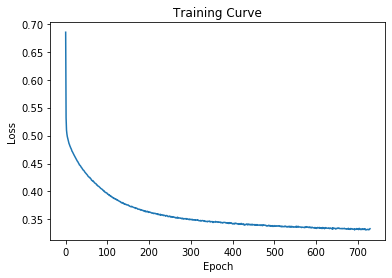

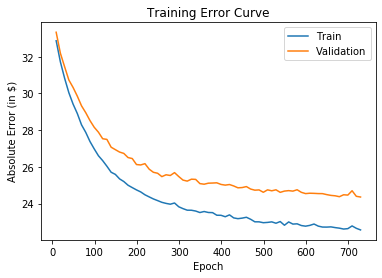

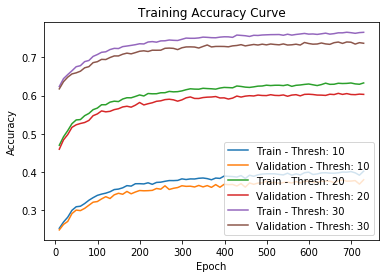

---[ITER 10] loss: 0.334974  time: 0.418
---[ITER 20] loss: 0.325316  time: 0.244
---[ITER 30] loss: 0.331191  time: 0.215
---[ITER 40] loss: 0.328342  time: 0.248
---[ITER 50] loss: 0.331007  time: 0.218
---[ITER 60] loss: 0.331041  time: 0.204
---[ITER 70] loss: 0.332560  time: 0.188
---[ITER 80] loss: 0.328714  time: 0.206
---[ITER 90] loss: 0.333239  time: 0.189
---[ITER 100] loss: 0.334678  time: 0.236
---[ITER 110] loss: 0.337195  time: 0.187
---[ITER 120] loss: 0.325727  time: 0.246
---[ITER 130] loss: 0.334877  time: 0.188
---[ITER 140] loss: 0.332766  time: 0.167
---[ITER 150] loss: 0.331784  time: 0.223
---[ITER 160] loss: 0.334012  time: 0.208
[EPOCH 731] loss: 0.331549  time: 3.744
---[ITER 10] loss: 0.331522  time: 0.475
---[ITER 20] loss: 0.329673  time: 0.202
---[ITER 30] loss: 0.331925  time: 0.213
---[ITER 40] loss: 0.327048  time: 0.203
---[ITER 50] loss: 0.326657  time: 0.213
---[ITER 60] loss: 0.330578  time: 0.218
---[ITER 70] loss: 0.329372  time: 0.221
---[ITER 8

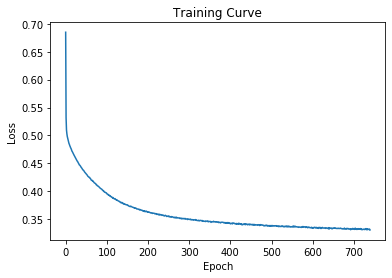

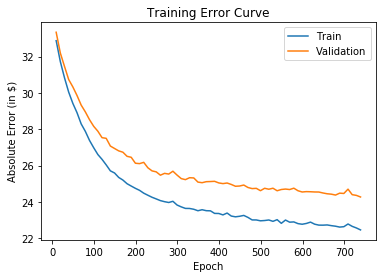

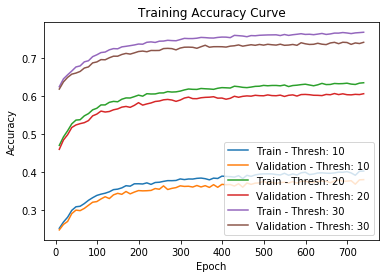

---[ITER 10] loss: 0.325032  time: 0.336
---[ITER 20] loss: 0.331196  time: 0.181
---[ITER 30] loss: 0.335780  time: 0.354
---[ITER 40] loss: 0.337517  time: 0.225
---[ITER 50] loss: 0.331049  time: 0.249
---[ITER 60] loss: 0.323043  time: 0.249
---[ITER 70] loss: 0.329227  time: 0.235
---[ITER 80] loss: 0.332865  time: 0.244
---[ITER 90] loss: 0.327921  time: 0.235
---[ITER 100] loss: 0.334272  time: 0.201
---[ITER 110] loss: 0.331275  time: 0.234
---[ITER 120] loss: 0.327226  time: 0.201
---[ITER 130] loss: 0.333820  time: 0.216
---[ITER 140] loss: 0.335661  time: 0.212
---[ITER 150] loss: 0.343160  time: 0.265
---[ITER 160] loss: 0.333810  time: 0.249
[EPOCH 741] loss: 0.332247  time: 4.061
---[ITER 10] loss: 0.330159  time: 0.342
---[ITER 20] loss: 0.335429  time: 0.242
---[ITER 30] loss: 0.334228  time: 0.362
---[ITER 40] loss: 0.328318  time: 0.229
---[ITER 50] loss: 0.331383  time: 0.222
---[ITER 60] loss: 0.327255  time: 0.230
---[ITER 70] loss: 0.323834  time: 0.248
---[ITER 8

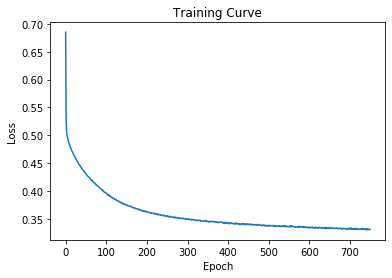

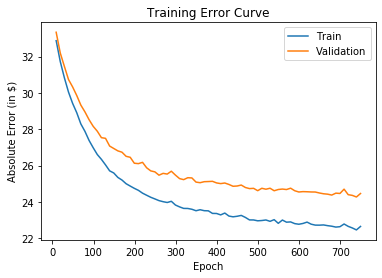

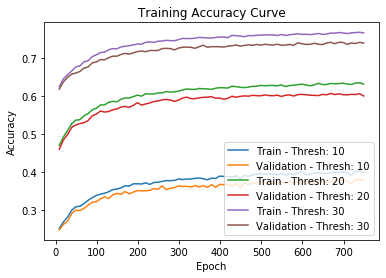

---[ITER 10] loss: 0.329492  time: 0.311
---[ITER 20] loss: 0.329326  time: 0.339
---[ITER 30] loss: 0.330311  time: 0.210
---[ITER 40] loss: 0.326690  time: 0.225
---[ITER 50] loss: 0.326670  time: 0.219
---[ITER 60] loss: 0.330594  time: 0.226
---[ITER 70] loss: 0.333861  time: 0.228
---[ITER 80] loss: 0.333325  time: 0.244
---[ITER 90] loss: 0.330434  time: 0.236
---[ITER 100] loss: 0.332825  time: 0.241
---[ITER 110] loss: 0.335956  time: 0.171
---[ITER 120] loss: 0.332102  time: 0.207
---[ITER 130] loss: 0.330655  time: 0.238
---[ITER 140] loss: 0.330184  time: 0.257
---[ITER 150] loss: 0.332815  time: 0.244
---[ITER 160] loss: 0.332687  time: 0.222
[EPOCH 751] loss: 0.330899  time: 4.005
---[ITER 10] loss: 0.334807  time: 0.343
---[ITER 20] loss: 0.336845  time: 0.362
---[ITER 30] loss: 0.333887  time: 0.210
---[ITER 40] loss: 0.333333  time: 0.237
---[ITER 50] loss: 0.334596  time: 0.226
---[ITER 60] loss: 0.332358  time: 0.218
---[ITER 70] loss: 0.335222  time: 0.227
---[ITER 8

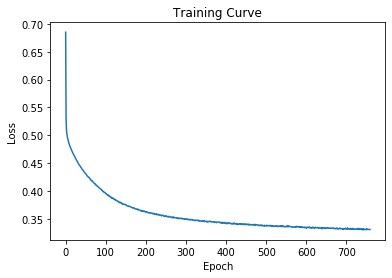

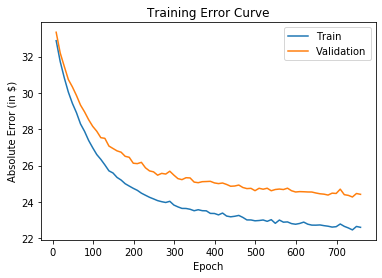

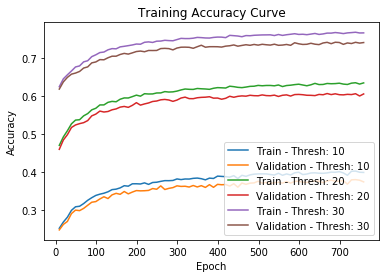

---[ITER 10] loss: 0.336262  time: 0.465
---[ITER 20] loss: 0.332151  time: 0.252
---[ITER 30] loss: 0.331533  time: 0.226
---[ITER 40] loss: 0.333581  time: 0.204
---[ITER 50] loss: 0.330083  time: 0.246
---[ITER 60] loss: 0.337647  time: 0.185
---[ITER 70] loss: 0.330846  time: 0.268
---[ITER 80] loss: 0.327693  time: 0.222
---[ITER 90] loss: 0.332031  time: 0.240
---[ITER 100] loss: 0.331903  time: 0.202
---[ITER 110] loss: 0.324371  time: 0.229
---[ITER 120] loss: 0.327400  time: 0.215
---[ITER 130] loss: 0.331741  time: 0.253
---[ITER 140] loss: 0.337421  time: 0.237
---[ITER 150] loss: 0.330297  time: 0.225
---[ITER 160] loss: 0.331758  time: 0.187
[EPOCH 761] loss: 0.331854  time: 4.073
---[ITER 10] loss: 0.329635  time: 0.451
---[ITER 20] loss: 0.332765  time: 0.240
---[ITER 30] loss: 0.341997  time: 0.204
---[ITER 40] loss: 0.329986  time: 0.226
---[ITER 50] loss: 0.325618  time: 0.213
---[ITER 60] loss: 0.335553  time: 0.206
---[ITER 70] loss: 0.332831  time: 0.227
---[ITER 8

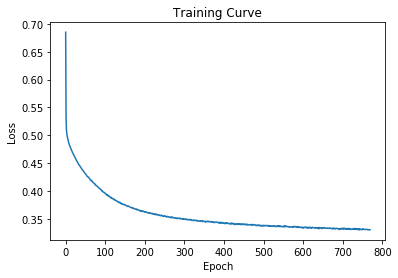

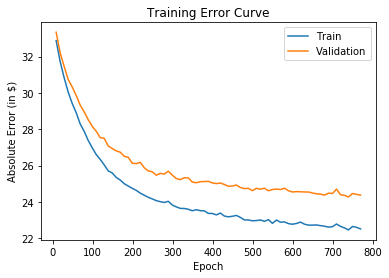

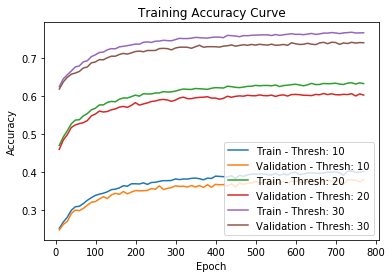

---[ITER 10] loss: 0.328415  time: 0.464
---[ITER 20] loss: 0.329405  time: 0.220
---[ITER 30] loss: 0.332917  time: 0.248
---[ITER 40] loss: 0.320672  time: 0.236
---[ITER 50] loss: 0.333447  time: 0.240
---[ITER 60] loss: 0.330958  time: 0.222
---[ITER 70] loss: 0.336156  time: 0.407
---[ITER 80] loss: 0.326916  time: 0.338
---[ITER 90] loss: 0.329639  time: 0.289
---[ITER 100] loss: 0.332468  time: 0.283
---[ITER 110] loss: 0.333056  time: 0.228
---[ITER 120] loss: 0.332774  time: 0.263
---[ITER 130] loss: 0.330320  time: 0.234
---[ITER 140] loss: 0.332410  time: 0.460
---[ITER 150] loss: 0.325334  time: 0.509
---[ITER 160] loss: 0.332679  time: 0.292
[EPOCH 771] loss: 0.330512  time: 5.160
---[ITER 10] loss: 0.328403  time: 0.538
---[ITER 20] loss: 0.335735  time: 0.316
---[ITER 30] loss: 0.329485  time: 0.307
---[ITER 40] loss: 0.324967  time: 0.292
---[ITER 50] loss: 0.333361  time: 0.303
---[ITER 60] loss: 0.331911  time: 0.325
---[ITER 70] loss: 0.328416  time: 0.299
---[ITER 8

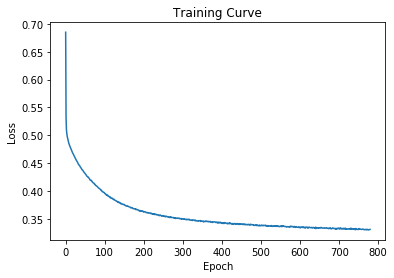

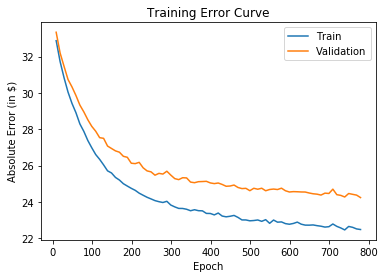

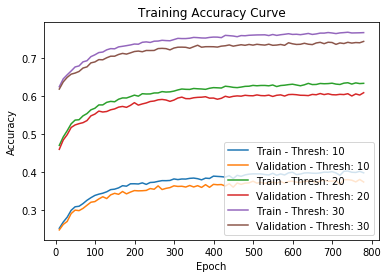

---[ITER 10] loss: 0.334501  time: 0.316
---[ITER 20] loss: 0.325388  time: 0.180
---[ITER 30] loss: 0.328419  time: 0.356
---[ITER 40] loss: 0.332218  time: 0.229
---[ITER 50] loss: 0.335718  time: 0.184
---[ITER 60] loss: 0.326878  time: 0.193
---[ITER 70] loss: 0.332285  time: 0.281
---[ITER 80] loss: 0.324329  time: 0.215
---[ITER 90] loss: 0.323895  time: 0.210
---[ITER 100] loss: 0.332434  time: 0.171
---[ITER 110] loss: 0.329095  time: 0.197
---[ITER 120] loss: 0.335128  time: 0.190
---[ITER 130] loss: 0.327520  time: 0.229
---[ITER 140] loss: 0.328512  time: 0.265
---[ITER 150] loss: 0.330172  time: 0.197
---[ITER 160] loss: 0.336917  time: 0.224
[EPOCH 781] loss: 0.330473  time: 3.809
---[ITER 10] loss: 0.335422  time: 0.303
---[ITER 20] loss: 0.328150  time: 0.231
---[ITER 30] loss: 0.333358  time: 0.362
---[ITER 40] loss: 0.327748  time: 0.277
---[ITER 50] loss: 0.331796  time: 0.221
---[ITER 60] loss: 0.326160  time: 0.232
---[ITER 70] loss: 0.332609  time: 0.238
---[ITER 8

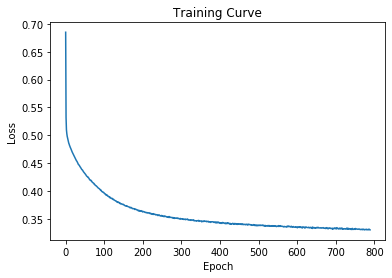

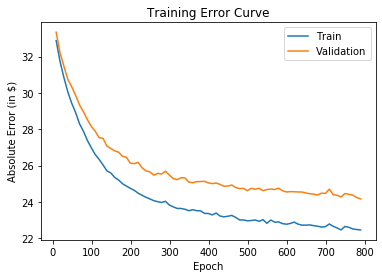

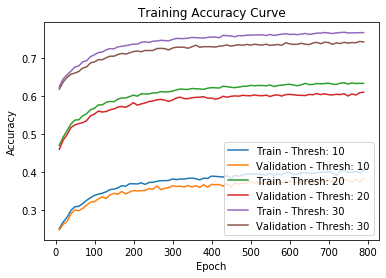

---[ITER 10] loss: 0.331503  time: 0.290
---[ITER 20] loss: 0.334100  time: 0.371
---[ITER 30] loss: 0.330516  time: 0.251
---[ITER 40] loss: 0.324179  time: 0.237
---[ITER 50] loss: 0.337791  time: 0.254
---[ITER 60] loss: 0.329108  time: 0.234
---[ITER 70] loss: 0.332901  time: 0.238
---[ITER 80] loss: 0.340136  time: 0.220
---[ITER 90] loss: 0.329604  time: 0.218
---[ITER 100] loss: 0.323805  time: 0.246
---[ITER 110] loss: 0.326820  time: 0.245
---[ITER 120] loss: 0.333539  time: 0.209
---[ITER 130] loss: 0.329695  time: 0.291
---[ITER 140] loss: 0.330853  time: 0.353
---[ITER 150] loss: 0.328965  time: 0.223
---[ITER 160] loss: 0.330748  time: 0.266
[EPOCH 791] loss: 0.331047  time: 4.337
---[ITER 10] loss: 0.327637  time: 0.274
---[ITER 20] loss: 0.331211  time: 0.500
---[ITER 30] loss: 0.332063  time: 0.280
---[ITER 40] loss: 0.334125  time: 0.324
---[ITER 50] loss: 0.337328  time: 0.239
---[ITER 60] loss: 0.324597  time: 0.218
---[ITER 70] loss: 0.331251  time: 0.226
---[ITER 8

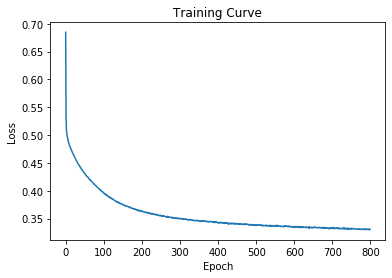

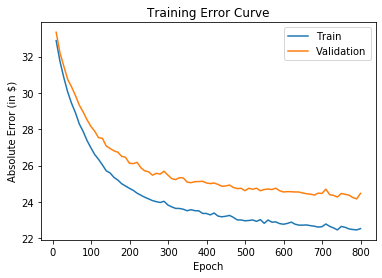

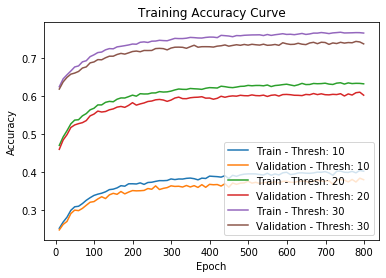

---[ITER 10] loss: 0.330080  time: 0.413
---[ITER 20] loss: 0.336520  time: 0.231
---[ITER 30] loss: 0.329788  time: 0.246
---[ITER 40] loss: 0.331357  time: 0.226
---[ITER 50] loss: 0.335191  time: 0.271
---[ITER 60] loss: 0.337726  time: 0.257
---[ITER 70] loss: 0.331284  time: 0.233
---[ITER 80] loss: 0.330089  time: 0.214
---[ITER 90] loss: 0.336089  time: 0.227
---[ITER 100] loss: 0.328210  time: 0.174
---[ITER 110] loss: 0.327523  time: 0.206
---[ITER 120] loss: 0.334185  time: 0.206
---[ITER 130] loss: 0.320250  time: 0.223
---[ITER 140] loss: 0.328474  time: 0.216
---[ITER 150] loss: 0.334222  time: 0.193
---[ITER 160] loss: 0.324006  time: 0.215
[EPOCH 801] loss: 0.330866  time: 3.935
---[ITER 10] loss: 0.334093  time: 0.426
---[ITER 20] loss: 0.330450  time: 0.203
---[ITER 30] loss: 0.332568  time: 0.234
---[ITER 40] loss: 0.336436  time: 0.209
---[ITER 50] loss: 0.325922  time: 0.186
---[ITER 60] loss: 0.322825  time: 0.222
---[ITER 70] loss: 0.323737  time: 0.220
---[ITER 8

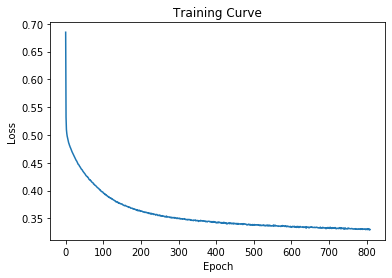

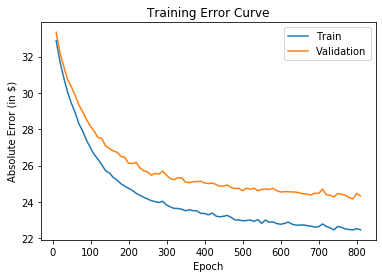

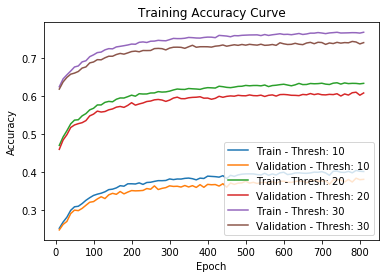

---[ITER 10] loss: 0.336892  time: 0.262
---[ITER 20] loss: 0.327596  time: 0.224
---[ITER 30] loss: 0.330993  time: 0.188
---[ITER 40] loss: 0.331310  time: 0.296
---[ITER 50] loss: 0.338163  time: 0.199
---[ITER 60] loss: 0.326386  time: 0.209
---[ITER 70] loss: 0.332802  time: 0.209
---[ITER 80] loss: 0.327977  time: 0.199
---[ITER 90] loss: 0.324030  time: 0.191
---[ITER 100] loss: 0.325766  time: 0.219
---[ITER 110] loss: 0.331635  time: 0.200
---[ITER 120] loss: 0.329002  time: 0.197
---[ITER 130] loss: 0.328702  time: 0.204
---[ITER 140] loss: 0.332084  time: 0.198
---[ITER 150] loss: 0.332752  time: 0.216
---[ITER 160] loss: 0.329631  time: 0.235
[EPOCH 811] loss: 0.330217  time: 3.600
---[ITER 10] loss: 0.324057  time: 0.323
---[ITER 20] loss: 0.331693  time: 0.159
---[ITER 30] loss: 0.336447  time: 0.198
---[ITER 40] loss: 0.324956  time: 0.375
---[ITER 50] loss: 0.329554  time: 0.222
---[ITER 60] loss: 0.339817  time: 0.194
---[ITER 70] loss: 0.332077  time: 0.197
---[ITER 8

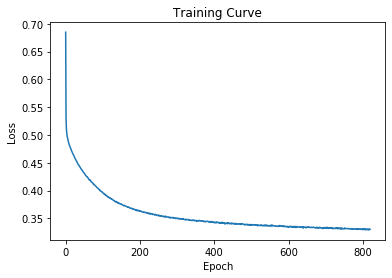

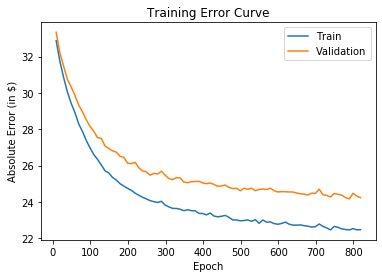

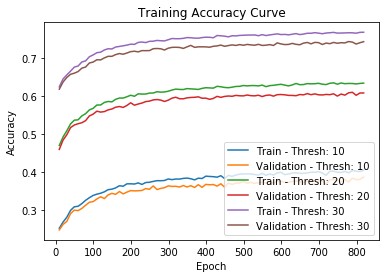

---[ITER 10] loss: 0.326380  time: 0.292
---[ITER 20] loss: 0.325197  time: 0.221
---[ITER 30] loss: 0.329221  time: 0.344
---[ITER 40] loss: 0.338750  time: 0.186
---[ITER 50] loss: 0.326225  time: 0.174
---[ITER 60] loss: 0.327765  time: 0.179
---[ITER 70] loss: 0.332336  time: 0.238
---[ITER 80] loss: 0.333925  time: 0.215
---[ITER 90] loss: 0.330086  time: 0.197
---[ITER 100] loss: 0.329678  time: 0.191
---[ITER 110] loss: 0.328699  time: 0.172
---[ITER 120] loss: 0.331665  time: 0.202
---[ITER 130] loss: 0.330100  time: 0.195
---[ITER 140] loss: 0.329173  time: 0.220
---[ITER 150] loss: 0.337943  time: 0.220
---[ITER 160] loss: 0.327746  time: 0.217
[EPOCH 821] loss: 0.330139  time: 3.648
---[ITER 10] loss: 0.326140  time: 0.297
---[ITER 20] loss: 0.323827  time: 0.219
---[ITER 30] loss: 0.331380  time: 0.348
---[ITER 40] loss: 0.332854  time: 0.239
---[ITER 50] loss: 0.324336  time: 0.215
---[ITER 60] loss: 0.328981  time: 0.202
---[ITER 70] loss: 0.331964  time: 0.203
---[ITER 8

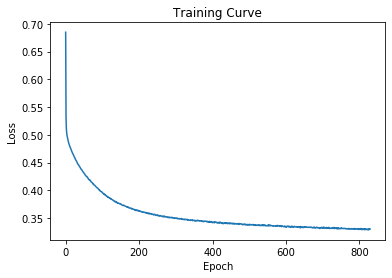

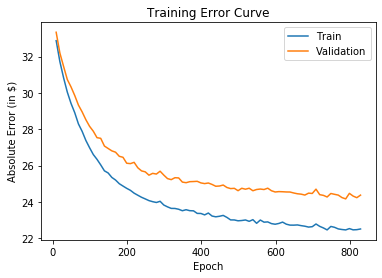

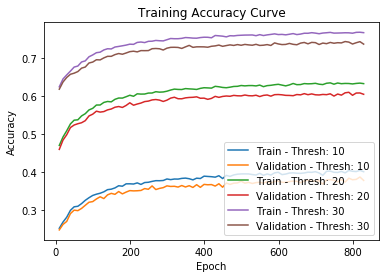

---[ITER 10] loss: 0.325065  time: 0.292
---[ITER 20] loss: 0.325938  time: 0.321
---[ITER 30] loss: 0.327364  time: 0.221
---[ITER 40] loss: 0.325477  time: 0.210
---[ITER 50] loss: 0.331965  time: 0.198
---[ITER 60] loss: 0.326758  time: 0.181
---[ITER 70] loss: 0.323004  time: 0.219
---[ITER 80] loss: 0.335096  time: 0.244
---[ITER 90] loss: 0.325954  time: 0.172
---[ITER 100] loss: 0.337585  time: 0.208
---[ITER 110] loss: 0.332174  time: 0.220
---[ITER 120] loss: 0.332239  time: 0.203
---[ITER 130] loss: 0.332680  time: 0.327
---[ITER 140] loss: 0.334950  time: 0.253
---[ITER 150] loss: 0.328728  time: 0.277
---[ITER 160] loss: 0.328072  time: 0.272
[EPOCH 831] loss: 0.329397  time: 4.009
---[ITER 10] loss: 0.335078  time: 0.379
---[ITER 20] loss: 0.331430  time: 0.368
---[ITER 30] loss: 0.332814  time: 0.226
---[ITER 40] loss: 0.329219  time: 0.217
---[ITER 50] loss: 0.328400  time: 0.208
---[ITER 60] loss: 0.326277  time: 0.225
---[ITER 70] loss: 0.335979  time: 0.221
---[ITER 8

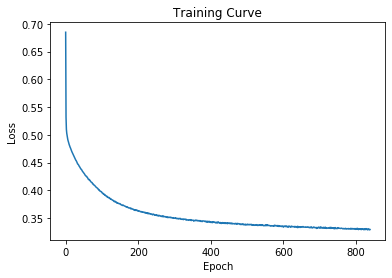

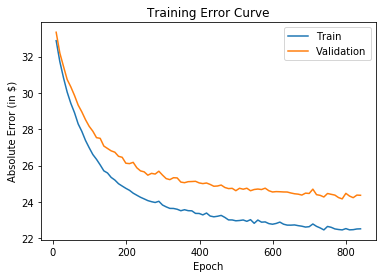

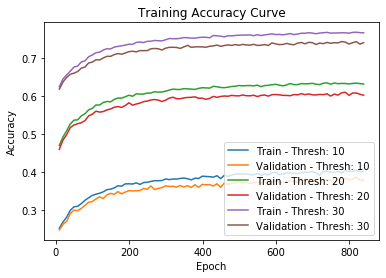

---[ITER 10] loss: 0.336009  time: 0.542
---[ITER 20] loss: 0.330903  time: 0.246
---[ITER 30] loss: 0.330971  time: 0.237
---[ITER 40] loss: 0.325199  time: 0.286
---[ITER 50] loss: 0.329565  time: 0.289
---[ITER 60] loss: 0.330875  time: 0.556
---[ITER 70] loss: 0.329966  time: 0.518
---[ITER 80] loss: 0.330640  time: 0.536
---[ITER 90] loss: 0.326998  time: 0.480
---[ITER 100] loss: 0.329545  time: 0.520
---[ITER 110] loss: 0.328300  time: 0.489
---[ITER 120] loss: 0.327509  time: 0.547
---[ITER 130] loss: 0.333765  time: 0.435
---[ITER 140] loss: 0.330051  time: 0.216
---[ITER 150] loss: 0.323894  time: 0.221
---[ITER 160] loss: 0.328757  time: 0.267
[EPOCH 841] loss: 0.329294  time: 6.562
---[ITER 10] loss: 0.331207  time: 1.098
---[ITER 20] loss: 0.324984  time: 0.422
---[ITER 30] loss: 0.332195  time: 0.458
---[ITER 40] loss: 0.330146  time: 0.535
---[ITER 50] loss: 0.328448  time: 0.398
---[ITER 60] loss: 0.328347  time: 0.514
---[ITER 70] loss: 0.334618  time: 0.447
---[ITER 8

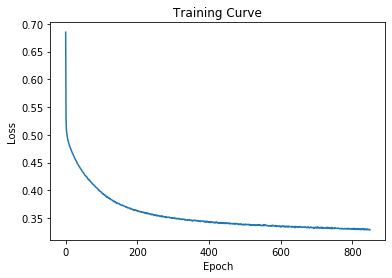

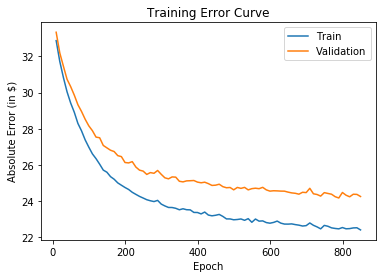

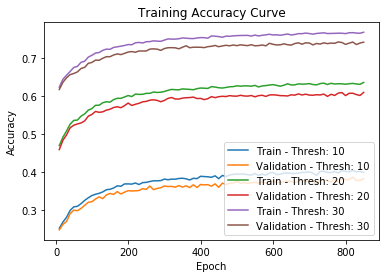

---[ITER 10] loss: 0.326878  time: 0.484
---[ITER 20] loss: 0.326827  time: 0.345
---[ITER 30] loss: 0.329277  time: 0.377
---[ITER 40] loss: 0.333715  time: 0.245
---[ITER 50] loss: 0.322741  time: 0.219
---[ITER 60] loss: 0.334597  time: 0.213
---[ITER 70] loss: 0.328726  time: 0.172
---[ITER 80] loss: 0.333044  time: 0.191
---[ITER 90] loss: 0.332608  time: 0.151
---[ITER 100] loss: 0.331286  time: 0.280
---[ITER 110] loss: 0.336112  time: 0.202
---[ITER 120] loss: 0.329176  time: 0.246
---[ITER 130] loss: 0.324815  time: 0.215
---[ITER 140] loss: 0.323091  time: 0.186
---[ITER 150] loss: 0.336866  time: 0.352
---[ITER 160] loss: 0.327531  time: 0.297
[EPOCH 851] loss: 0.330157  time: 4.374
---[ITER 10] loss: 0.326196  time: 0.302
---[ITER 20] loss: 0.334619  time: 0.224
---[ITER 30] loss: 0.324672  time: 0.315
---[ITER 40] loss: 0.331409  time: 0.174
---[ITER 50] loss: 0.329147  time: 0.170
---[ITER 60] loss: 0.326281  time: 0.185
---[ITER 70] loss: 0.325951  time: 0.172
---[ITER 8

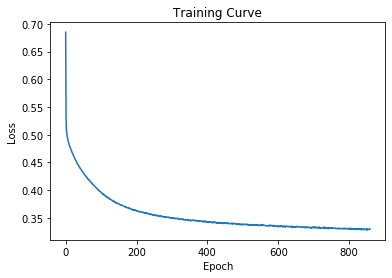

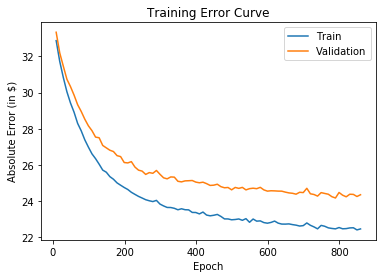

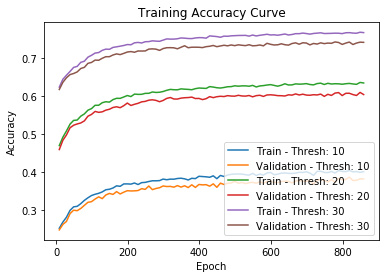

---[ITER 10] loss: 0.329546  time: 0.386
---[ITER 20] loss: 0.321113  time: 0.546
---[ITER 30] loss: 0.328921  time: 0.402
---[ITER 40] loss: 0.326780  time: 0.388
---[ITER 50] loss: 0.323701  time: 0.223
---[ITER 60] loss: 0.326849  time: 0.215
---[ITER 70] loss: 0.328999  time: 0.242
---[ITER 80] loss: 0.333597  time: 0.217
---[ITER 90] loss: 0.335568  time: 0.157
---[ITER 100] loss: 0.333574  time: 0.229
---[ITER 110] loss: 0.323349  time: 0.192
---[ITER 120] loss: 0.328484  time: 0.170
---[ITER 130] loss: 0.330251  time: 0.172
---[ITER 140] loss: 0.328261  time: 0.225
---[ITER 150] loss: 0.323678  time: 0.229
---[ITER 160] loss: 0.334351  time: 0.184
[EPOCH 861] loss: 0.328666  time: 4.317
---[ITER 10] loss: 0.333525  time: 0.280
---[ITER 20] loss: 0.335482  time: 0.288
---[ITER 30] loss: 0.322304  time: 0.201
---[ITER 40] loss: 0.332316  time: 0.170
---[ITER 50] loss: 0.325460  time: 0.162
---[ITER 60] loss: 0.330957  time: 0.182
---[ITER 70] loss: 0.330447  time: 0.161
---[ITER 8

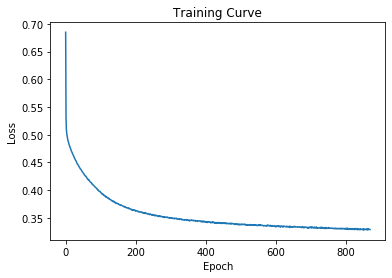

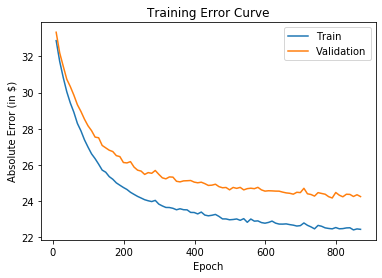

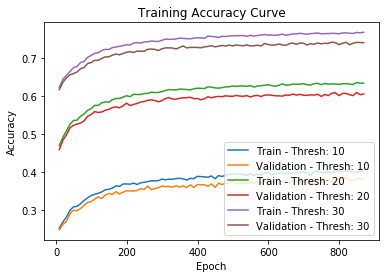

---[ITER 10] loss: 0.327609  time: 0.460
---[ITER 20] loss: 0.331767  time: 0.253
---[ITER 30] loss: 0.330583  time: 0.229
---[ITER 40] loss: 0.322566  time: 0.224
---[ITER 50] loss: 0.329279  time: 0.187
---[ITER 60] loss: 0.330351  time: 0.177
---[ITER 70] loss: 0.336232  time: 0.175
---[ITER 80] loss: 0.334396  time: 0.171
---[ITER 90] loss: 0.325296  time: 0.190
---[ITER 100] loss: 0.330131  time: 0.201
---[ITER 110] loss: 0.332749  time: 0.219
---[ITER 120] loss: 0.328122  time: 0.171
---[ITER 130] loss: 0.333374  time: 0.199
---[ITER 140] loss: 0.324030  time: 0.178
---[ITER 150] loss: 0.331595  time: 0.191
---[ITER 160] loss: 0.328336  time: 0.167
[EPOCH 871] loss: 0.329528  time: 3.597
---[ITER 10] loss: 0.330846  time: 0.360
---[ITER 20] loss: 0.328961  time: 0.172
---[ITER 30] loss: 0.331618  time: 0.174
---[ITER 40] loss: 0.334292  time: 0.164
---[ITER 50] loss: 0.320909  time: 0.197
---[ITER 60] loss: 0.329469  time: 0.161
---[ITER 70] loss: 0.322301  time: 0.179
---[ITER 8

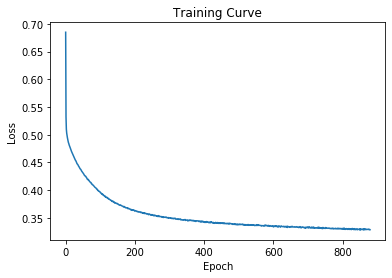

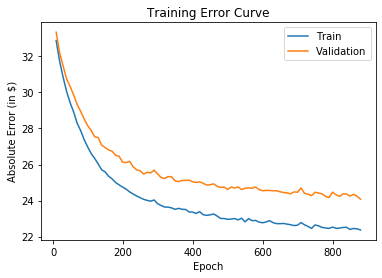

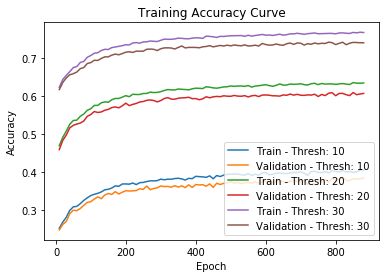

---[ITER 10] loss: 0.321721  time: 0.448
---[ITER 20] loss: 0.326614  time: 0.155
---[ITER 30] loss: 0.330776  time: 0.198
---[ITER 40] loss: 0.331381  time: 0.159
---[ITER 50] loss: 0.326325  time: 0.194
---[ITER 60] loss: 0.330812  time: 0.189
---[ITER 70] loss: 0.329857  time: 0.197
---[ITER 80] loss: 0.330002  time: 0.173
---[ITER 90] loss: 0.330442  time: 0.199
---[ITER 100] loss: 0.335096  time: 0.156
---[ITER 110] loss: 0.333886  time: 0.186
---[ITER 120] loss: 0.320890  time: 0.232
---[ITER 130] loss: 0.334286  time: 0.164
---[ITER 140] loss: 0.330289  time: 0.226
---[ITER 150] loss: 0.327207  time: 0.273
---[ITER 160] loss: 0.331774  time: 0.328
[EPOCH 881] loss: 0.329186  time: 3.640
---[ITER 10] loss: 0.323984  time: 0.419
---[ITER 20] loss: 0.334012  time: 0.175
---[ITER 30] loss: 0.328380  time: 0.204
---[ITER 40] loss: 0.327189  time: 0.171
---[ITER 50] loss: 0.334874  time: 0.176
---[ITER 60] loss: 0.333712  time: 0.202
---[ITER 70] loss: 0.327864  time: 0.196
---[ITER 8

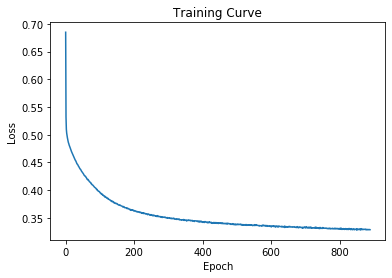

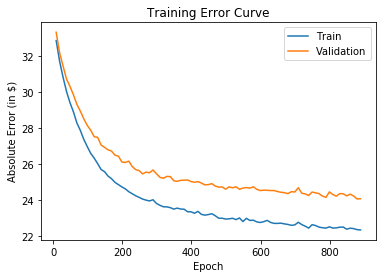

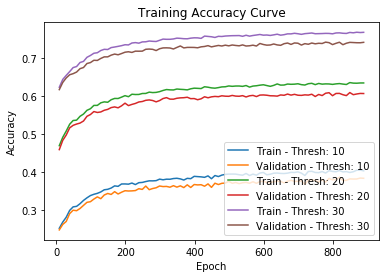

---[ITER 10] loss: 0.335076  time: 0.278
---[ITER 20] loss: 0.322451  time: 0.179
---[ITER 30] loss: 0.329013  time: 0.332
---[ITER 40] loss: 0.329565  time: 0.228
---[ITER 50] loss: 0.325680  time: 0.224
---[ITER 60] loss: 0.326944  time: 0.302
---[ITER 70] loss: 0.325214  time: 0.312
---[ITER 80] loss: 0.328464  time: 0.314
---[ITER 90] loss: 0.335295  time: 0.321
---[ITER 100] loss: 0.329189  time: 0.350
---[ITER 110] loss: 0.326915  time: 0.308
---[ITER 120] loss: 0.322689  time: 0.306
---[ITER 130] loss: 0.332294  time: 0.253
---[ITER 140] loss: 0.332418  time: 0.278
---[ITER 150] loss: 0.332703  time: 0.374
---[ITER 160] loss: 0.328978  time: 0.276
[EPOCH 891] loss: 0.328836  time: 4.921
---[ITER 10] loss: 0.320706  time: 0.290
---[ITER 20] loss: 0.326996  time: 0.242
---[ITER 30] loss: 0.327913  time: 0.299
---[ITER 40] loss: 0.330117  time: 0.185
---[ITER 50] loss: 0.328287  time: 0.190
---[ITER 60] loss: 0.330268  time: 0.163
---[ITER 70] loss: 0.334806  time: 0.194
---[ITER 8

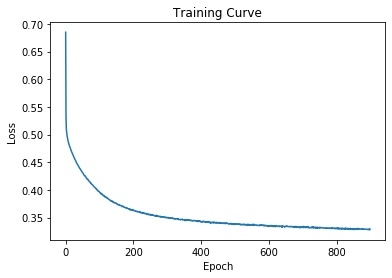

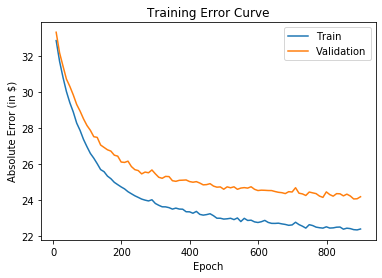

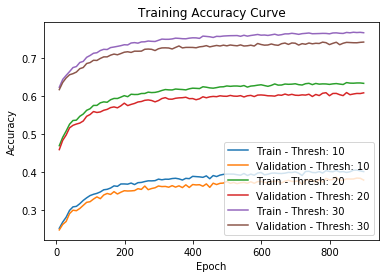

---[ITER 10] loss: 0.326718  time: 0.246
---[ITER 20] loss: 0.327660  time: 0.310
---[ITER 30] loss: 0.322880  time: 0.198
---[ITER 40] loss: 0.326159  time: 0.206
---[ITER 50] loss: 0.328121  time: 1.264
---[ITER 60] loss: 0.327537  time: 0.639
---[ITER 70] loss: 0.333849  time: 1.251
---[ITER 80] loss: 0.327758  time: 0.371
---[ITER 90] loss: 0.327455  time: 0.254
---[ITER 100] loss: 0.323016  time: 0.336
---[ITER 110] loss: 0.331766  time: 0.256
---[ITER 120] loss: 0.335132  time: 0.264
---[ITER 130] loss: 0.334963  time: 0.870
---[ITER 140] loss: 0.333358  time: 0.764
---[ITER 150] loss: 0.329604  time: 0.497
---[ITER 160] loss: 0.327952  time: 0.859
[EPOCH 901] loss: 0.328977  time: 8.817
---[ITER 10] loss: 0.330612  time: 0.382
---[ITER 20] loss: 0.329928  time: 0.635
---[ITER 30] loss: 0.328861  time: 0.294
---[ITER 40] loss: 0.332823  time: 0.213
---[ITER 50] loss: 0.330475  time: 0.256
---[ITER 60] loss: 0.328086  time: 0.551
---[ITER 70] loss: 0.325075  time: 0.790
---[ITER 8

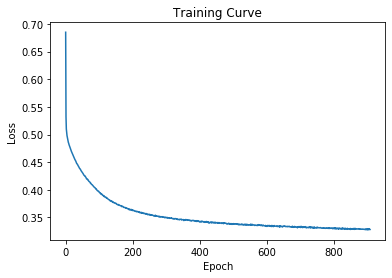

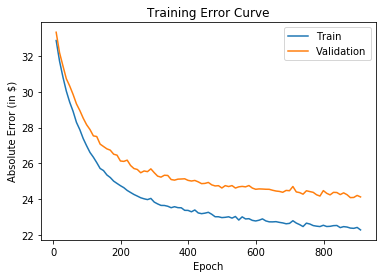

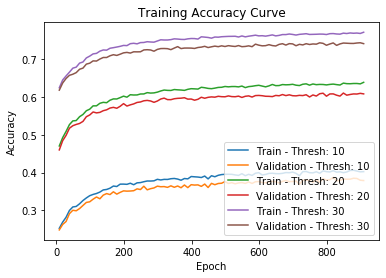

---[ITER 10] loss: 0.330124  time: 0.560
---[ITER 20] loss: 0.325889  time: 0.164
---[ITER 30] loss: 0.328729  time: 0.162
---[ITER 40] loss: 0.324209  time: 0.138
---[ITER 50] loss: 0.324201  time: 0.154
---[ITER 60] loss: 0.331665  time: 0.180
---[ITER 70] loss: 0.332308  time: 0.184
---[ITER 80] loss: 0.327726  time: 0.156
---[ITER 90] loss: 0.333002  time: 0.208
---[ITER 100] loss: 0.329156  time: 0.157
---[ITER 110] loss: 0.322776  time: 0.162
---[ITER 120] loss: 0.325096  time: 0.199
---[ITER 130] loss: 0.326928  time: 0.163
---[ITER 140] loss: 0.329769  time: 0.194
---[ITER 150] loss: 0.335499  time: 0.192
---[ITER 160] loss: 0.333572  time: 0.156
[EPOCH 911] loss: 0.328454  time: 3.263
---[ITER 10] loss: 0.323266  time: 0.348
---[ITER 20] loss: 0.332389  time: 0.167
---[ITER 30] loss: 0.329466  time: 0.192
---[ITER 40] loss: 0.329320  time: 0.148
---[ITER 50] loss: 0.335729  time: 0.170
---[ITER 60] loss: 0.331795  time: 0.168
---[ITER 70] loss: 0.324018  time: 0.162
---[ITER 8

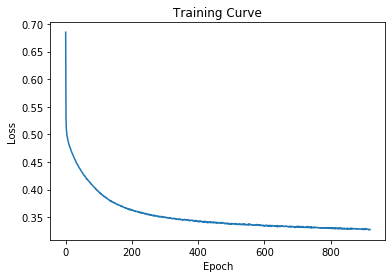

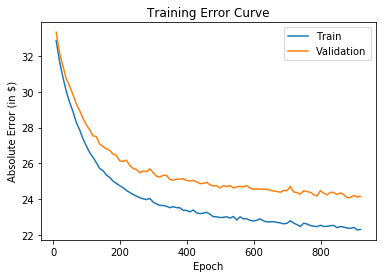

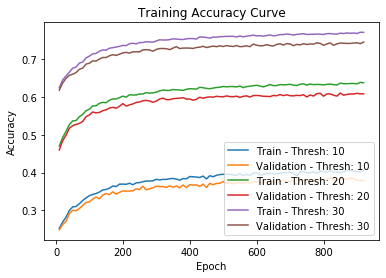

---[ITER 10] loss: 0.321560  time: 0.274
---[ITER 20] loss: 0.336394  time: 0.166


In [ ]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1500)

In [ ]:
# THIS IS nov20_test05

In [ ]:
checkpoint = torch.load("../test/Brian/nov20_test05/final/checkpoint_final.tar")

In [ ]:
print("Minimum Train Error:\t\t", min(checkpoint["train_error"]))
print("Index of Min Train Error:\t", checkpoint["train_error"].index(min(checkpoint["train_error"])))
print("Minimum Val Error:\t\t", min(checkpoint["val_error"]))
print("Index of Min Val Error:\t\t", checkpoint["val_error"].index(min(checkpoint["val_error"])))

In [ ]:
print("For Threshold=20")
print("Maximum Train Accuracy:\t", max(checkpoint["train_acc"][1]))
print("Index of Max Train Acc:\t", checkpoint["train_acc"][1].index(max(checkpoint["train_acc"][1])))
print("Maximum Val Accuracy:\t", max(checkpoint["val_acc"][1]))
print("Index of Max Val Acc:\t", checkpoint["val_acc"][1].index(max(checkpoint["val_acc"][1])))